In [1]:
import tensorflow as tf
import pickle
import tensorflow.keras as keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.layers.experimental import preprocessing
#from keras import backend as K
import numpy as np
#import pandas as pd
import sys
import os
import time
import math
sys.path.append(os.path.abspath('../'))
import helpers
import helpers.data_generator
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
# from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
# from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
#from utils.callbacks import CyclicLR, TensorBoardWrapper
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import linear_model

In [2]:
print(tf.__version__)
#print(h5py.__version__)

2.1.3


In [2]:
#conda install hdf5=1.10.5

In [2]:
def convert_attrs(f):
    for key in f:
        s = f[key]
        if isinstance(s, str):
            f[key] = np.string_(s)

def convert_groups(f):
    convert_attrs(f.attrs)
    for key in f:
        s = f[key]
        if isinstance(s,str):
            f[key] = np.string_(s)
        elif isinstance(s, h5py.Group):
            convert_groups(f[key])

def convert_h5py(file_in, file_out=None):
    if file_out:
        shutil.copy(file_in, file_out)
    else:
        file_out = file_in
    f = h5py.File(file_out, 'a')
    convert_groups(f)
    f.close()

In [3]:
"""THIS IS THE ONE FROM THE PAPER AS OF 3/5"""
import h5py
import shutil
import numpy as np
import sys

file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'

base_path = os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_03_10/')
"""good but overfit"""
#model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-19-50_Scenario-93.h5'
"""good val but looks bad?"""
# model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-02-31_Scenario-71.h5'

model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5'
file_path = base_path + model_path

convert_h5py(file_path)

model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265.h5
loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_15Mar20-03-48_Scenario-265_params.pkl
with parameters: dict_keys(['model_type', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'sample_weightin', 'scalar_input_names', 'std_activation', 'batch_size', 'process_data', 'predict_deltas', 'epochs', 'loss_function', 'actuator_names', 'profile_downsample', 'sample_weighting', 'loss_function_kwargs', 'flattop_only', 'raw_data_path', 'invert_q', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'val_idx', 'nshots', 'excluded_shots', 'lookbac

In [4]:
orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
_, traindata, normalization_dict = helpers.data_generator.process_data(orig_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 0)

traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])


Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  6378
Number of shots used:  6378
Total number of timesteps:  671222
Shots with Complete NaN: 
454582 samples total
Removing ECH
Removed 194246 samples
260336 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 52091 samples
208245 samples remaining
Removing weird I-coils
Removed 46528 samples
161717 samples remaining
Removing NaN
Removed 0 samples
161717 samples remaining
Removing dudtrip
Removed 9571 samples
152146 samples remaining
152146 samples remaining after pruning


Normalizing:  58%|#####8    | 14/24 [00:00<00:00, 126.82it/s]

Total number of samples:  152146
Number of training samples:  137014
Number of validation samples:  15132


Normalizing: 100%|##########| 24/24 [00:00<00:00, 92.15it/s] 


In [5]:
traindatafull = copy.deepcopy(traindata)
#traindata = {sig:traindatafull[sig][:,-1,::2] for sig in scenario['target_profile_names']}

In [6]:
train_generator = DataGenerator(traindata,
                                1, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = 'std') #scenario['shuffle_generators'])

In [7]:
train_generator_batch = DataGenerator(traindatafull,
                                128, #scenario['batch_size'],
                                scenario['input_profile_names'],
                                #all_profiles,
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                #all_profiles,
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                shuffle=False,
                                sample_weights = None) #scenario['shuffle_generators'])

In [8]:

orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
testdata, valdata, test_normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [],
                                                      invert_q=scenario.setdefault('invert_q',False),
                                                      val_idx = 1)

testdata = helpers.normalization.renormalize(helpers.normalization.denormalize(testdata.copy(),test_normalization_dict),scenario['normalization_dict'])

Loading
Signals: curr_target, dens, density_estimate, kappa_EFIT01, li_EFIT01, pinj, press_EFIT01, q_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01, volume_EFIT01
Number of useable shots:  1116
Number of shots used:  1116
Total number of timesteps:  124182
Shots with Complete NaN: 
85701 samples total
Removing ECH
Removed 46375 samples
39326 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 5176 samples
34150 samples remaining
Removing weird I-coils
Removed 7495 samples
26655 samples remaining
Removing NaN
Removed 0 samples
26655 samples remaining
Removing dudtrip
Removed 620 samples
26035 samples remaining
26035 samples remaining after pruning


Normalizing:  42%|####1     | 10/24 [00:00<00:00, 99.93it/s]

Total number of samples:  26035
Number of training samples:  23469
Number of validation samples:  2566


Normalizing: 100%|##########| 24/24 [00:00<00:00, 54.43it/s]


In [9]:
testdata = copy.deepcopy(traindata)
testdatafull = copy.deepcopy(testdata)

In [10]:
#all_profiles = ['C_coil_method', 'I_coil_method', 'bt', 'curr', 'curr_target', 'dens', 'density_estimate', 'dud_trip', 'ech', 'gas_feedback', 'kappa_EFIT01', 'li_EFIT01', 'pinj', 'press_EFIT01', 'q_EFIT01', 'rotation', 'shotnum', 'target_density', 'temp', 'time', 'tinj', 'triangularity_bot_EFIT01', 'triangularity_top_EFIT01', 'volume_EFIT01']
#print(len(all_profiles))

In [10]:
inputs = {sig:[] for sig in scenario['target_profile_names']}
baseline = {sig:[] for sig in scenario['target_profile_names']}
predictions = {sig:[] for sig in scenario['target_profile_names']}
for i in range(len(train_generator_batch)):
    print(i,end=',')
    sample = train_generator_batch[i]
    out = model.predict(sample[0])
    for i, sig in enumerate(scenario['target_profile_names']):
        inputs[sig].append(sample[0]["input_"+sig][:,0,:])
        if scenario['predict_deltas']:
            baseline[sig].append(sample[1]['target_'+sig])
            predictions[sig].append(out[i])
        else:
            baseline[sig].append(sample[1]['target_'+sig].squeeze() - sample[0]['input_'+sig].squeeze())
            predictions[sig].append(out[i].squeeze() - sample[0]['input_'+sig].squeeze())
inputs = {sig:np.concatenate(inputs[sig],axis=0) for sig in scenario['target_profile_names']}
baseline = {sig:np.concatenate(baseline[sig],axis=0) for sig in scenario['target_profile_names']}
predictions = {sig:np.concatenate(predictions[sig],axis=0) for sig in scenario['target_profile_names']}
model_err = {sig: (predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}
model_err_abs = {sig: np.abs(predictions[sig] - baseline[sig]) for sig in scenario['target_profile_names']}

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,

In [19]:
print(len(inputs))
#print(inputs)
print(len(inputs['dens']))
print(len(inputs['dens'][0]))

5
15132
33


In [11]:
inputs = {sig:[] for sig in scenario['target_profile_names']}
#inputs2 = {sig:[] for sig in scenario['target_profile_names']}
for i in range(len(train_generator_batch)):
    print(i,end=',')
    sample = train_generator_batch[i]
    out = model.predict(sample[0])
    for i, sig in enumerate(scenario['target_profile_names']):
        inputs[sig].append(sample[0]["input_"+sig][:,0,:])
#print(inputs)
#print(inputs2)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,

In [12]:
num_components=5
full_pca_fitter_errs = {}
full_pca_fitter_errs_abs = {}
profiles=scenario['target_profile_names']

#delta_pca_fitters = {}

for index in range(5):
    print((profiles[index]))
    comp = str(profiles[index])
    print(model_err[comp])
    full_err = model_err[comp]
    full_err_abs = model_err_abs[comp]
    #delta = np.array([train_generator[i][1]['target_' + profile] for i in range(len(train_generator))]).squeeze()
    #print(profile, ' made arrays')
    full_pca_fitter_errs[comp] = decomposition.IncrementalPCA(n_components=num_components).fit(full_err)
    print(profiles[index], ' done full')
    full_pca_fitter_errs_abs[comp] = decomposition.IncrementalPCA(n_components=num_components).fit(full_err_abs)
    print(profiles[index], ' abs done full')
    #delta_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(delta)
    #print(profile, ' done deltas')
#print(full_err)
print(len(full_err))
print(len(full_err[0]))
print(len(full_err_abs))
print(len(full_err_abs[0]))
print(len(full_pca_fitter_errs['dens'].components_))
print(len(full_pca_fitter_errs['dens'].components_[0]))

dens
[[-0.19179939 -0.19223318 -0.19640917 ... -0.10988498 -0.03226425
  -0.02188848]
 [-0.04788148 -0.04380281 -0.02780114 ... -0.13400432 -0.0671297
  -0.02198732]
 [-0.19918932 -0.19252203 -0.16520585 ... -0.05804753 -0.0260757
  -0.00591744]
 ...
 [-0.00967024 -0.02349172 -0.03609403 ...  0.00894888 -0.0553647
  -0.01310795]
 [ 0.4554379   0.40400216  0.43631625 ... -0.36123112  0.09981754
   0.26035905]
 [ 0.37330228  0.3362379   0.34815234 ... -0.5923827   0.1295886
   0.27777722]]
dens  done full
dens  abs done full
temp
[[ 0.03571714  0.04044812  0.04166773 ... -0.0508806  -0.01156512
  -0.01501347]
 [-0.02424068 -0.02715321 -0.02706435 ... -0.08517351 -0.01160572
  -0.00417028]
 [ 0.0166562   0.01156149  0.01163552 ... -0.07048777 -0.02403783
  -0.0031829 ]
 ...
 [ 0.07307488  0.06901793  0.06557289 ... -0.0009763  -0.01369147
  -0.00068535]
 [ 0.1460197   0.16150248  0.1316756  ... -0.14614005  0.00684145
  -0.04435923]
 [ 0.02700639  0.02727282 -0.00186455 ... -0.1347475   0

In [22]:
print(type(full_pca_fitter_errs))
print(type(full_pca_fitter_errs['dens']))

<class 'dict'>
<class 'sklearn.decomposition._incremental_pca.IncrementalPCA'>


In [13]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

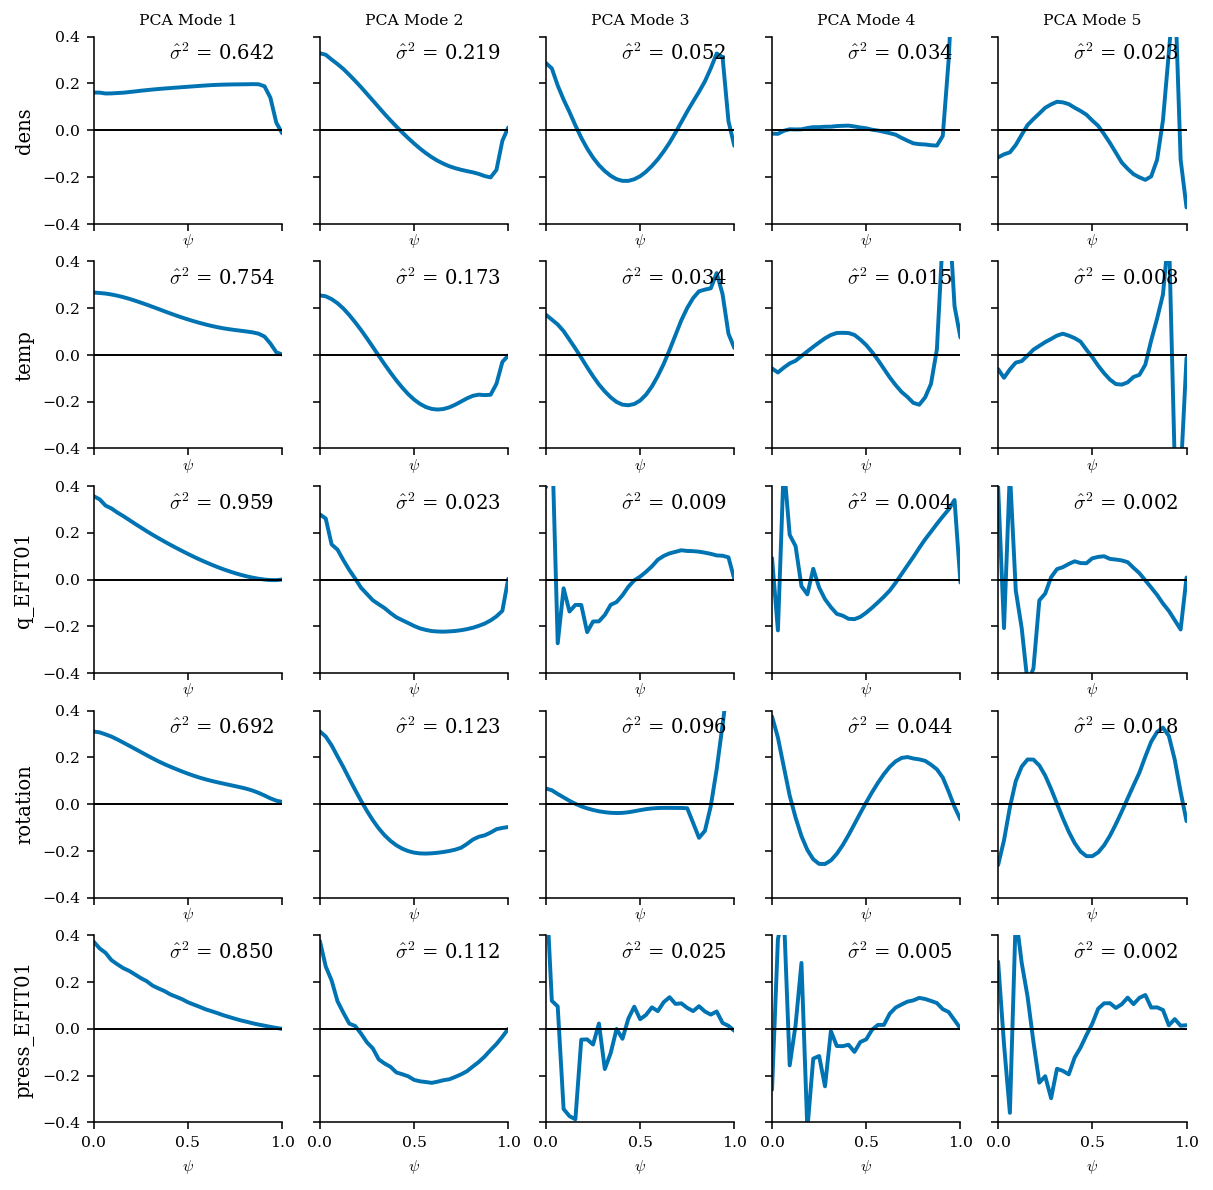

In [14]:
"""plot full pca modes of the errors"""

ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):
    pca=full_pca_fitter_errs[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca.components_[j],lw=2)
        ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        ax.set_xlabel('$\psi$',size=8)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)

# print(pca)
# print(pca.components_)
# print("components_[0] starts below: ")
# print(pca.components_[0])
# print(len(pca.components_))
# print(len(pca.components_[0]))

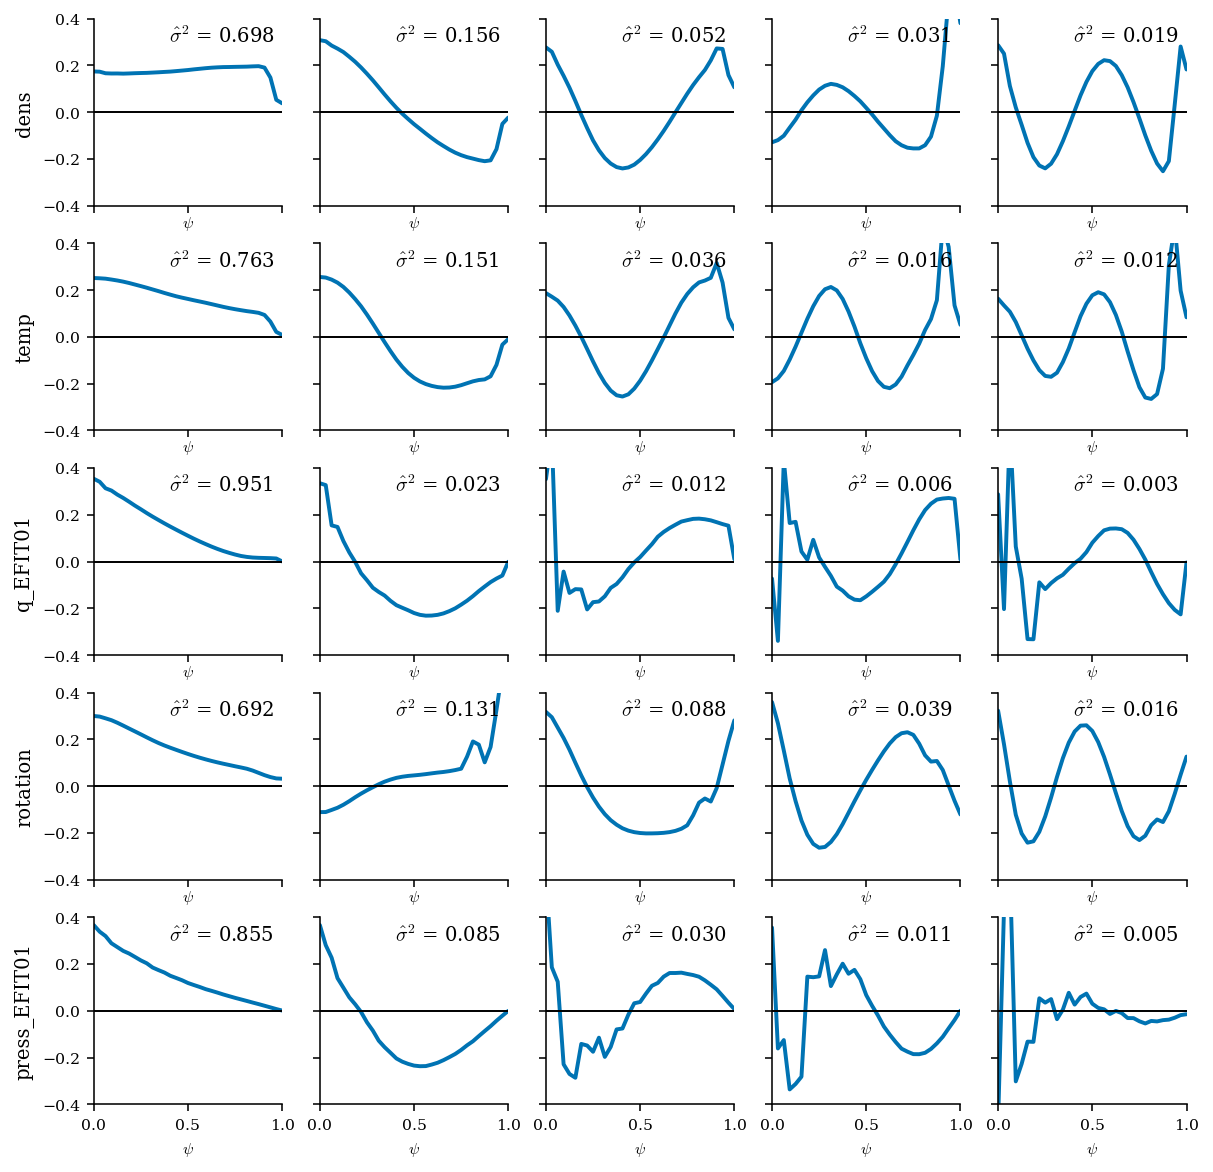

In [15]:
"""plot full pca modes of the abs values of the errors"""

ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):            
    pca_abs=full_pca_fitter_errs_abs[profile]
    for j in range(ncols):
        ax1= axes[i,j]
        ax1.plot(psi,pca_abs.components_[j],lw=2)
        ax1.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca_abs.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax1.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('(abs) PCA Mode {}'.format(j+1), size=8)
        ax1.set_xlabel('$\psi$',size=8)
        ax1.set_ylim(-.4,.4)
        ax1.tick_params(axis='both', which='major', labelsize=ticksize)
        ax1.set_xticks([0,.5,1])
        ax1.set_xlim(0,1)

        ax1.axhline(0,c='k',lw=1)

#print(len(pca_abs.components_))
#print(len(pca_abs.components_[0]))

In [26]:
print(len(train_generator))
print(train_generator[0][0])

15132
{'input_dens': array([[[-0.47336963, -0.47822505, -0.4917607 , -0.5126219 ,
         -0.5394541 , -0.57090366, -0.60561764, -0.6422443 ,
         -0.6794335 , -0.71581167, -0.7500293 , -0.7807496 ,
         -0.80665666, -0.8270383 , -0.842246  , -0.85278904,
         -0.8592171 , -0.86210245, -0.8621945 , -0.86031085,
         -0.8574359 , -0.85477656, -0.85381854, -0.8563667 ,
         -0.8645235 , -0.8806677 , -0.9067473 , -0.9439335 ,
         -0.99181414, -1.0479181 , -1.1079609 , -1.1669533 ,
         -1.2206928 ]]], dtype=float32), 'input_temp': array([[[ 0.3021406 ,  0.29821315,  0.28688347,  0.26868016,
          0.24413064,  0.21376327,  0.17810579,  0.1376864 ,
          0.09303289,  0.04463255, -0.00693288, -0.06113523,
         -0.11744659, -0.17533891, -0.23428431, -0.29375467,
         -0.35322207, -0.4121451 , -0.46999618, -0.5262472 ,
         -0.58037025, -0.63183737, -0.6801205 , -0.72469234,
         -0.76502776, -0.80058414, -0.8315148 , -0.8589096 ,
         

In [16]:
num_components=5
full_pca_fitters = {}
full_profiles = {}
#delta_pca_fitters = {}

for profile in profiles:
    full = np.array([train_generator[i][0]['input_' + profile] for i in range(len(train_generator))]).squeeze()
    #delta = np.array([train_generator[i][1]['target_' + profile] for i in range(len(train_generator))]).squeeze()
    #print(profile, ' made arrays')
    full_profiles[profile] = full
    full_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')
    #delta_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(delta)
    #print(profile, ' done deltas')

dens  done full
temp  done full
q_EFIT01  done full
rotation  done full
press_EFIT01  done full


In [28]:
print(full_profiles)
print(len(full_profiles['dens']))
print(len(full_profiles['dens'][0]))

{'dens': array([[-0.47336963, -0.47822505, -0.4917607 , ..., -1.1079609 ,
        -1.1669533 , -1.2206928 ],
       [-0.58743876, -0.58922505, -0.59449077, ..., -1.0374777 ,
        -1.1687803 , -1.244355  ],
       [-0.47631553, -0.4782117 , -0.48379385, ..., -0.9283383 ,
        -1.1064956 , -1.208051  ],
       ...,
       [ 0.6456899 ,  0.6455357 ,  0.6450064 , ..., -0.03350338,
        -0.2804556 , -0.6546018 ],
       [-0.2811862 , -0.28316817, -0.289028  , ..., -0.8998285 ,
        -0.9700749 , -1.090748  ],
       [-0.12139051, -0.12433622, -0.13304318, ..., -0.9354614 ,
        -1.0027472 , -1.109066  ]], dtype=float32), 'temp': array([[ 0.3021406 ,  0.29821315,  0.28688347, ..., -0.9531213 ,
        -0.9699148 , -0.98008114],
       [ 0.275189  ,  0.2718695 ,  0.26229683, ..., -0.95263565,
        -0.9786926 , -0.98483425],
       [ 0.31304118,  0.31010547,  0.30162188, ..., -0.93328524,
        -0.9722681 , -0.98014206],
       ...,
       [ 0.18577194,  0.18251626,  0.17311

In [29]:
print(len(full_pca_fitters['dens'].components_))
print(len(full_pca_fitters['dens'].components_[0]))

5
33


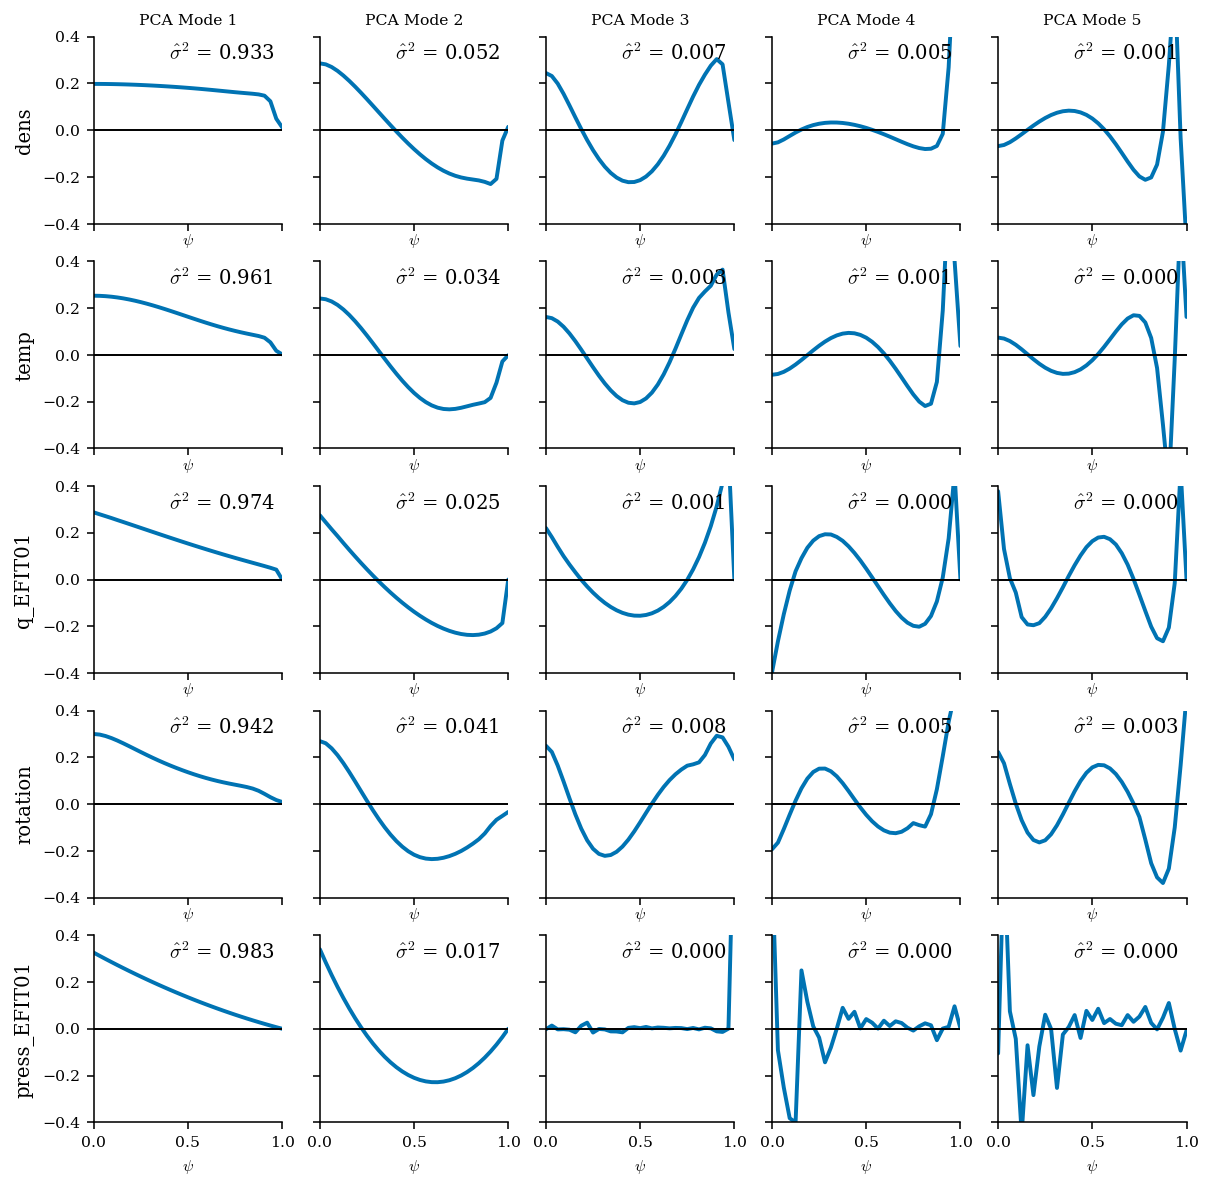

In [17]:
"""plot full pca modes"""

ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):
    pca_og=full_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca_og.components_[j],lw=2)
        ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca_og.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        ax.set_xlabel('$\psi$',size=8)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)

#print(full_pca_fitters['dens'].components_[0])
#print(pca_og.components_[0])
#print(full_pca_fitters['press_EFIT01'].components_[0])
#print(full_pca_fitters.components_['dens'][0])
#print(full_pca_fitters['press_EFIT01'][0])

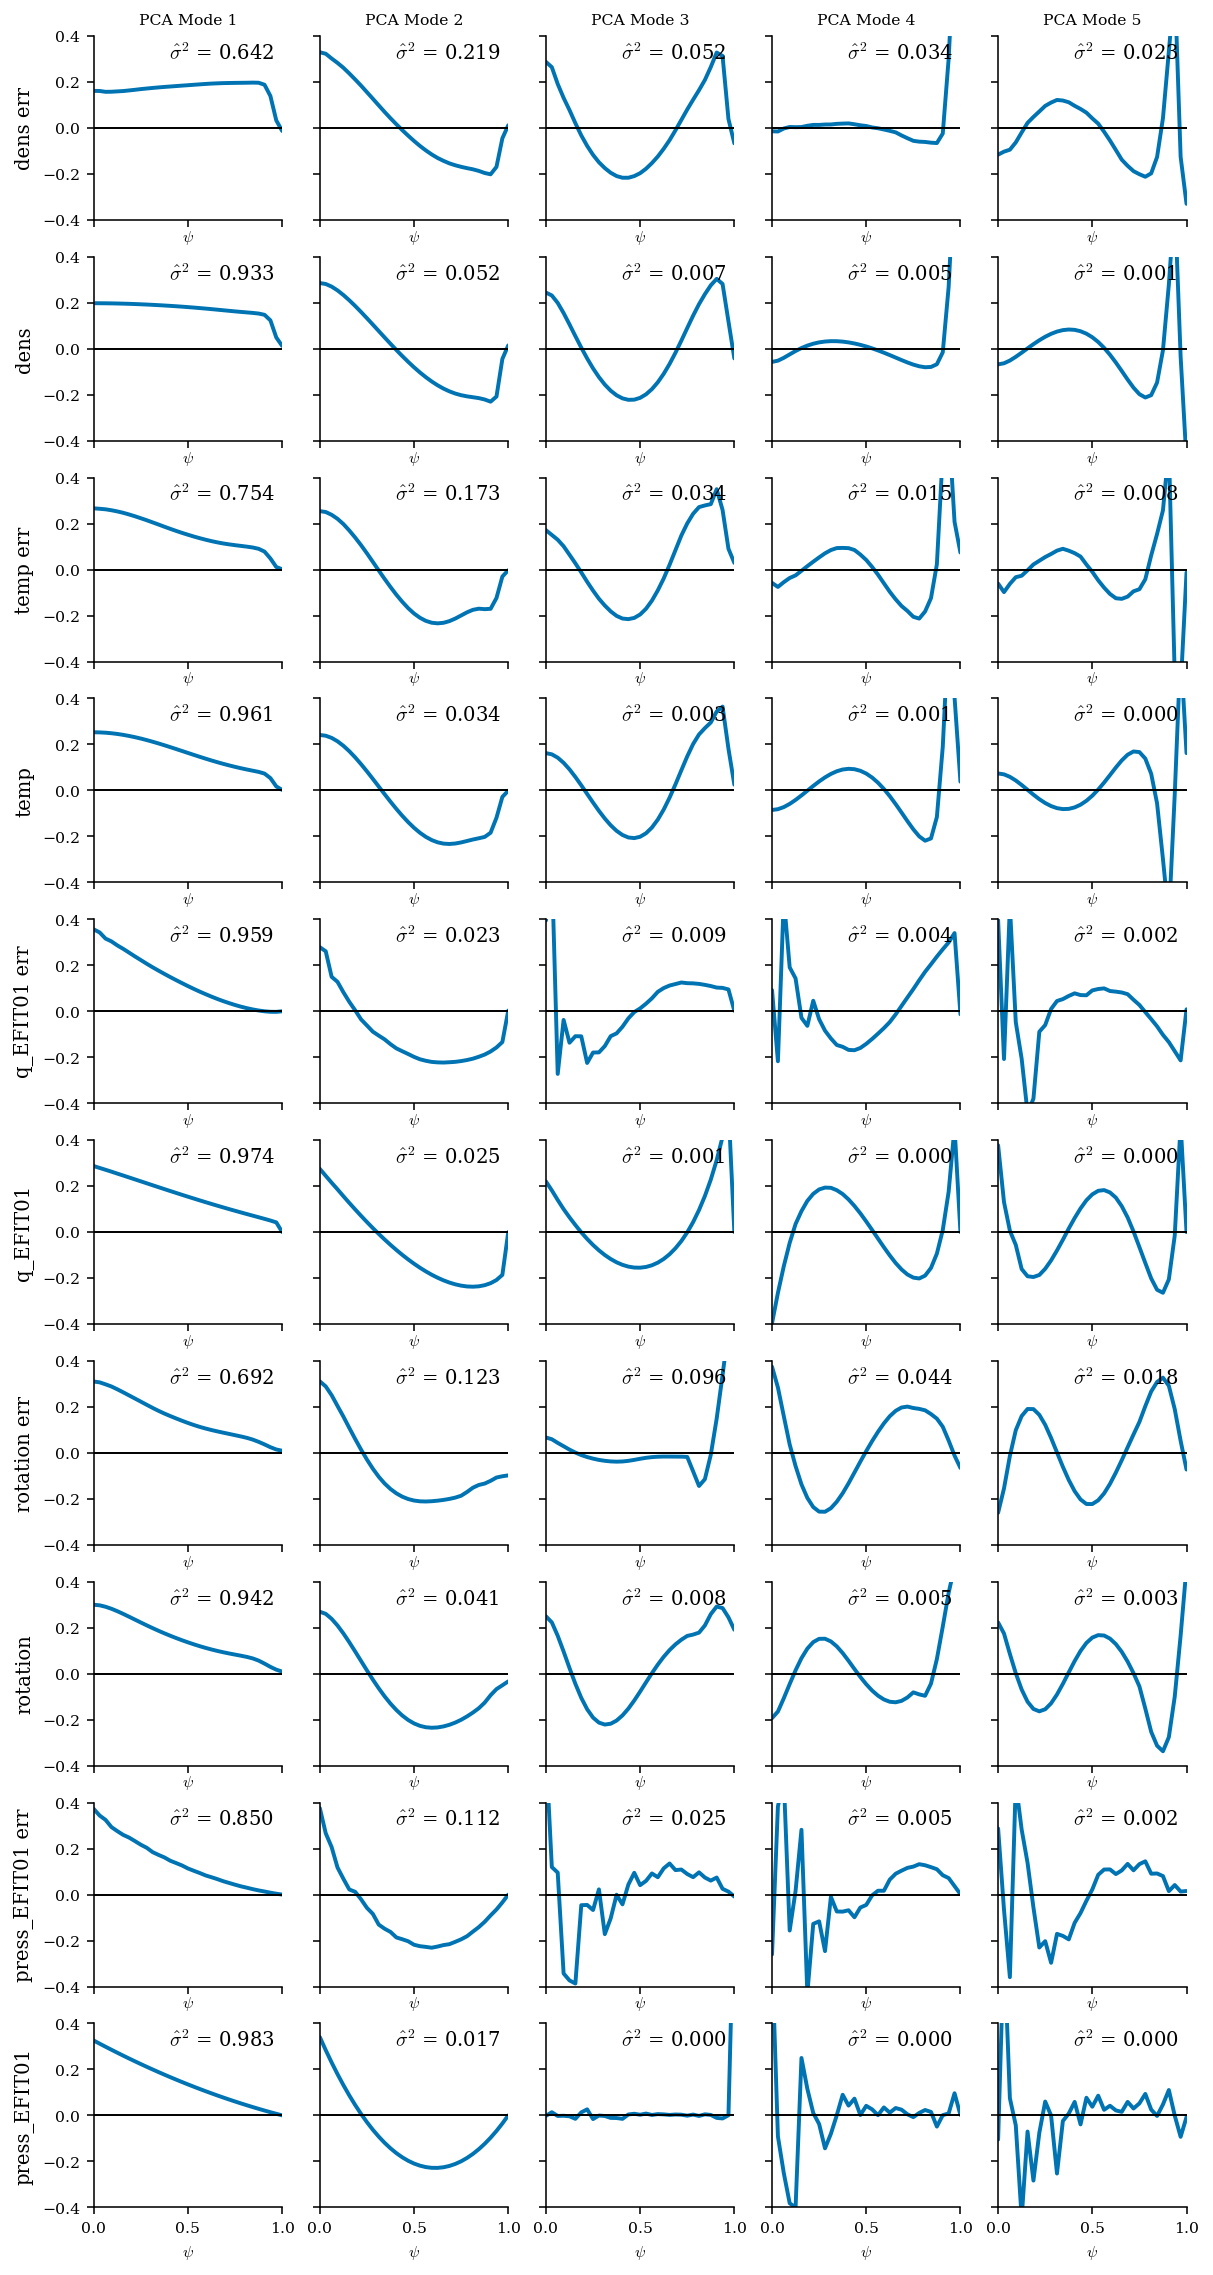

In [24]:
"""plot full pca modes of the errors and normal pca modes side by side"""

ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles*2),ncols, sharex=True, sharey=True,figsize=(10,20))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
counter = 0
for profile in profiles:
    for i in range(2):
        pca=full_pca_fitter_errs[profile]
        pca_og = full_pca_fitters[profile]
        for j in range(ncols):
            ax= axes[counter,j]
            if (counter % 2 == 0):
                ax.plot(psi,pca.components_[j],lw=2)
                ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca.explained_variance_ratio_[j]),fontsize=labelsize)
            elif (counter % 2 == 1):
                ax.plot(psi,pca_og.components_[j],lw=2)
                ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca_og.explained_variance_ratio_[j]),fontsize=labelsize)
            if j==0 and counter % 2 == 0:
                ax.set_ylabel(labels[counter//2]+ ' err', size=labelsize)
            elif j==0 and counter % 2 == 1:
                ax.set_ylabel(labels[counter//2], size=labelsize)
            if counter==0:
                ax.set_title('PCA Mode {}'.format(j+1), size=8)
            ax.set_xlabel('$\psi$',size=8)
            ax.set_ylim(-.4,.4)
            ax.tick_params(axis='both', which='major', labelsize=ticksize)
            ax.set_xticks([0,.5,1])
            ax.set_xlim(0,1)

            ax.axhline(0,c='k',lw=1)
        counter+=1

In [ ]:
"""plot full pca modes of the abs values of errors and normal pca modes side by side"""

ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles*2),ncols, sharex=True, sharey=True,figsize=(10,20))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
counter = 0
for profile in profiles:
    for i in range(2):
        pca_abs=full_pca_fitter_errs_abs[profile]
        pca_og = full_pca_fitters[profile]
        for j in range(ncols):
            ax= axes[counter,j]
            if (counter % 2 == 0):
                ax.plot(psi,pca_abs.components_[j],lw=2)
                ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca_abs.explained_variance_ratio_[j]),fontsize=labelsize)
            elif (counter % 2 == 1):
                ax.plot(psi,pca_og.components_[j],lw=2)
                ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca_og.explained_variance_ratio_[j]),fontsize=labelsize)
            if j==0 and counter % 2 == 0:
                ax.set_ylabel(labels[counter//2]+' abs err', size=labelsize)
            elif j==0 and counter % 2 == 1:
                ax.set_ylabel(labels[counter//2], size=labelsize)
            if counter==0:
                ax.set_title('PCA Mode {}'.format(j+1), size=8)
            ax.set_xlabel('$\psi$',size=8)
            ax.set_ylim(-.4,.4)
            ax.tick_params(axis='both', which='major', labelsize=ticksize)
            ax.set_xticks([0,.5,1])
            ax.set_xlim(0,1)

            ax.axhline(0,c='k',lw=1)
        counter+=1

In [27]:
# print(full_pca_fitters['dens'])
# print("components below:")
# print(full_pca_fitters['dens'].components_)

In [65]:
#print(full_pca_fitters)
#print(type(full_pca_fitters['dens']))
print(type(traindata['dens']))
#print(traindata['dens'])
print(len(traindata['dens']))
print(len(traindata['dens'][0]))
for sig in scenario['target_profile_names']:
    print(sig)

<class 'numpy.ndarray'>
15132
5
dens
temp
q_EFIT01
rotation
press_EFIT01


In [18]:
'''coefficients of PCA decomposition'''
# for profile in profiles:
#     print("Coeffs for " + profile +": " + decomposition.IncrementalPCA(n_components=num_components).fit_transform(full))
#     print("Coeffs for errors in " + profile +": " + decomposition.IncrementalPCA(n_components=num_components).fit_transform(full_errs))
#     print("Coeffs for abs errors in " + profile +": " + decomposition.IncrementalPCA(n_components=num_components).fit_transform(full_errs_abs))

# for profile in profiles:
#     for sig in scenario['target_profile_names']:   
#         print(full_pca_fitters[profile].transform(traindata[sig]))

coeff_og = {}
coeff_err = {}
coeff_err_abs = {}
for profile in profiles:
    full = np.array([train_generator[i][0]['input_' + profile] for i in range(len(train_generator))]).squeeze()
    coeff_og[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(full)
    coeff_err[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(model_err[profile])
    coeff_err_abs[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(model_err_abs[profile])

print(len(coeff_og))
print(len(coeff_og['dens']))
print(len(coeff_og['dens'][0]))
print(len(coeff_err))
print(len(coeff_err['dens']))
print(len(coeff_err['dens'][0]))

5
15132
5
5
15132
5


In [40]:
print(len(coeff_og['press_EFIT01']))
print(len(coeff_og['press_EFIT01'][0]))

15132
5


In [25]:
'''chop off last three pca modes of the pressure profile'''
#coeff_og = np.concatenate((coeff_og[profiles[0]], coeff_og[profiles[1]], coeff_og[profiles[2]], coeff_og[profiles[3]], coeff_og[profiles[4]][:, 0:2]), axis=1)
coeff_og_sliced = coeff_og.copy()
coeff_og_sliced['press_EFIT01'] = coeff_og['press_EFIT01'][:, 0:2]
coeff_err_sliced = coeff_err.copy()
coeff_err_sliced['press_EFIT01'] = coeff_err['press_EFIT01'][:, 0:2]
#print(coeff_og['press_EFIT01'])
print(len(coeff_og['press_EFIT01']))
print(len(coeff_og['press_EFIT01'][0]))
print(len(coeff_og['temp']))
print(len(coeff_og['temp'][0]))
print(len(coeff_og_sliced['press_EFIT01']))
print(len(coeff_og_sliced['press_EFIT01'][0]))
print(len(coeff_og_sliced['temp']))
print(len(coeff_og_sliced['temp'][0]))

15132
5
15132
5
15132
2
15132
5


15132
25
15132
25
15132
25
25
25
Sum of errors for dens: 730.1286
Mean error: 0.0014621402988371393
Sum of errors for temp: 1114.4922
Mean error: 0.002231858041430094
Sum of errors for q_EFIT01: -794.8274
Mean error: -0.001591705271868795
Sum of errors for rotation: 1923.6846
Mean error: 0.00385233074557596
Sum of errors for press_EFIT01: 1495.647
Mean error: 0.0029951527798767405
15132
33


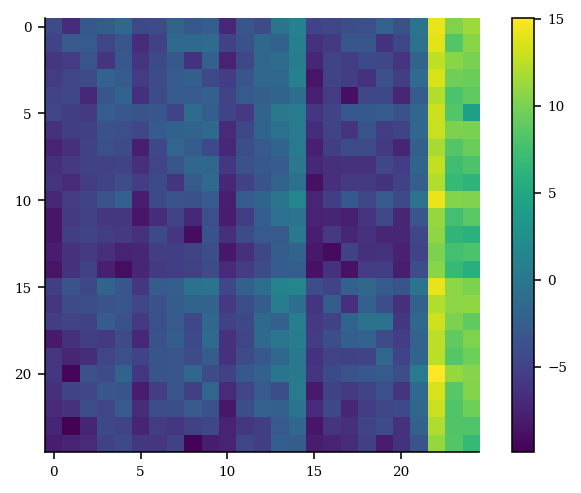

In [33]:
'''lin model, no bias term, 5 pca modes per profile'''
from sklearn.linear_model import LinearRegression
res_og = []
res_err = []
new_errs = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
#res_og = res_og.transpose()
#res_err = res_err.transpose()
#print(res_og)
print(len(res_og))
print(len(res_og[0]))
print(len(res_err))
print(len(res_err[0]))
A = LinearRegression().fit(res_og, res_err)
lin_err = res_og @ A.coef_
print(len(lin_err))
print(len(lin_err[0]))
#print(reg.coef_)
print(len(A.coef_))
print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs[profiles[i]] = model_err[profiles[i]] #- correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs[profiles[i]]/(33*15132))))
print(len(new_errs['dens']))
print(len(new_errs['dens'][0]))
    
coeff_err_new = {}
for profile in profiles:
    coeff_err_new[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(new_errs[profile])
#plt.imshow(A.coef_)
plt.imshow(np.log(abs(A.coef_)))
plt.colorbar()


In [25]:
print(np.shape(new_errs))
a = np.array([[1, 2], [3, 4]])
b = np.array([[5], [6]])
print(a[:, 0:1] + b)
print(a[:, 0:7])
test = np.ones(15132, order='F') * 2
#print(np.shape(test))
#print(test)

()
[[6]
 [9]]
[[1 2]
 [3 4]]


Sum of errors for dens: -730.1285181045523
Mean error: -0.0014621402728805743
Sum of errors for temp: -1114.4916744232166
Mean error: -0.002231857981927155
Sum of errors for q_EFIT01: 794.8275711536389
Mean error: 0.0015917052586804587
Sum of errors for rotation: -1923.6845078468282
Mean error: -0.0038523308177869668
Sum of errors for press_EFIT01: -1495.6475019454963
Mean error: -0.002995152760646703


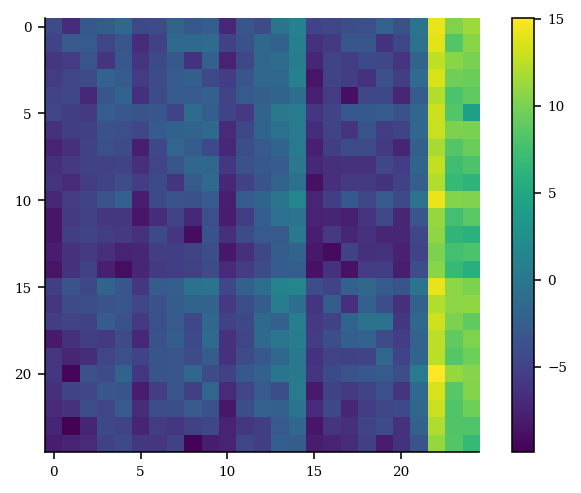

In [31]:
'''lin model, bias term, 5 pca modes per profile'''
from sklearn.linear_model import LinearRegression
res_og = []
res_err = []
new_errs = {}
new_errs_bias = {}
new_errs_bias_pca = {}
coeff_err_bias = {}
errs_concat = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1

for i in range(5):
    for j in range(33):
        bias = np.zeros((15132,1)) + (np.sum(model_err[profiles[i]][:, j:j+1])/15132)
        if j == 0:
            new_errs_bias[profiles[i]] = np.zeros((15132, 33))
        new_errs_bias[profiles[i]][:, j:j+1] = model_err[profiles[i]][:, j:j+1] - bias
    new_errs_bias_pca[profiles[i]] = decomposition.IncrementalPCA(n_components=5).fit_transform(new_errs_bias[profiles[i]])

errs_concat = np.concatenate([i for i in new_errs_bias_pca.values()], axis=1)

A = LinearRegression(fit_intercept=True).fit(res_og, errs_concat)
lin_err = res_og @ A.coef_

for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs[profiles[i]+""] = new_errs_bias[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs[profiles[i]]/(33*15132))))
    
for profile in profiles:
    coeff_err_bias[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(new_errs[profile])

#plt.imshow(A.coef_)
plt.imshow(np.log(abs(A.coef_)))
plt.colorbar()

15132
22
15132
22
15132
22
22
22
Sum of errors for dens: 3.410605131648481e-13
Mean error: 1.3010426069826053e-18
Sum of errors for temp: 1.3642420526593924e-12
Mean error: 2.8866882842426556e-18
Sum of errors for q_EFIT01: -2.0463630789890885e-12
Mean error: -3.7947076036992655e-18
Sum of errors for rotation: 1.8189894035458565e-12
Mean error: 5.421010862427522e-18
Sum of errors for press_EFIT01: 6.821210263296962e-13
Mean error: 5.421010862427522e-18


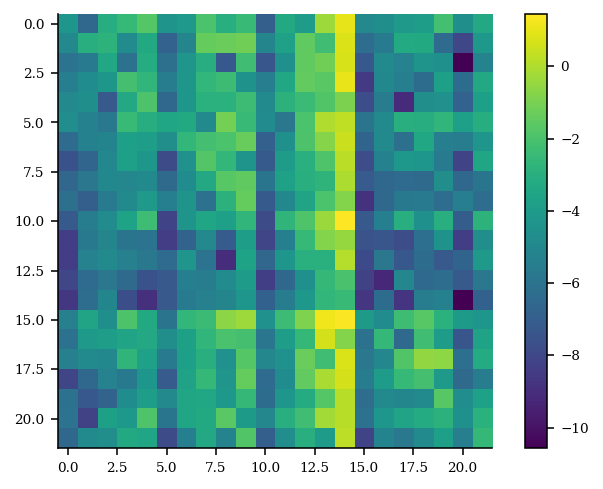

In [32]:
'''lin model, bias term, 2 pca modes for pressure'''
from sklearn.linear_model import LinearRegression
res_og = []
res_err = []
new_errs = {}
new_errs_bias_sliced = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og_sliced[profile+""]
        res_err = coeff_err_sliced[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og_sliced[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err_sliced[profile+""]), axis=1)
    counter += 1
#res_og = res_og.transpose()
#res_err = res_err.transpose()
#print(res_og)
print(len(res_og))
print(len(res_og[0]))
print(len(res_err))
print(len(res_err[0]))
A = LinearRegression().fit(res_og, res_err)
lin_err = res_og @ A.coef_
print(len(lin_err))
print(len(lin_err[0]))
#print(reg.coef_)
print(len(A.coef_))
print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs[profiles[i]] = model_err[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs[profiles[i]]/(33*15132))))
# print(len(new_errs_bias_sliced['dens']))
# print(len(new_errs_bias_sliced['dens'][0]))
# print(len(new_errs_bias_sliced['press_EFIT01']))
# print(len(new_errs_bias_sliced['press_EFIT01'][0]))
    
coeff_err_bias_sliced = {}
for profile in profiles:
    coeff_err_bias_sliced[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(new_errs[profile])
#plt.imshow(A.coef_)
plt.imshow(np.log(abs(A.coef_)))
plt.colorbar()

In [19]:
print(len(coeff_og_sliced['press_EFIT01']))
print(len(coeff_og_sliced['press_EFIT01'][0]))
print(len(coeff_err_sliced['press_EFIT01']))
print(len(coeff_err_sliced['press_EFIT01'][0]))

15132
2
15132
2


In [30]:
from sklearn.linear_model import LinearRegression
res_og = []
res_err = []
new_errs = {}
new_errs_bias_slice = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og_sliced[profile+""]
        res_err = coeff_err_sliced[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og_sliced[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err_sliced[profile+""]), axis=1)
    counter += 1
#res_og = res_og.transpose()
#res_err = res_err.transpose()
#print(res_og)
print(len(res_og))
print(len(res_og[0]))
print(len(res_err))
print(len(res_err[0]))
A = LinearRegression().fit(res_og, res_err)
lin_err = res_og @ A.coef_

res_og2 = []
res_err2 = []
new_errs2 = {}
new_errs_bias2 = {}
counter2 = 0
for profile in profiles:
    if counter2 == 0:
        res_og2 = coeff_og[profile+""]
        res_err2 = coeff_err[profile+""]
    else:
        res_og2 = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err2 = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter2 += 1
A2 = LinearRegression().fit(res_og, res_err)
lin_err2 = res_og @ A2.coef_

print(lin_err2-lin_err)
print(A2.coef_-A.coef_)

15132
22
15132
22
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [19]:
for profile in profiles:
    #print(coeff_err_new[profile]-coeff_err_bias[profile])
    #print('next')
    #print(coeff_err_new[profile]-coeff_err_bias_sliced[profile])

SyntaxError: unexpected EOF while parsing (<ipython-input-19-82afcf6445d7>, line 4)

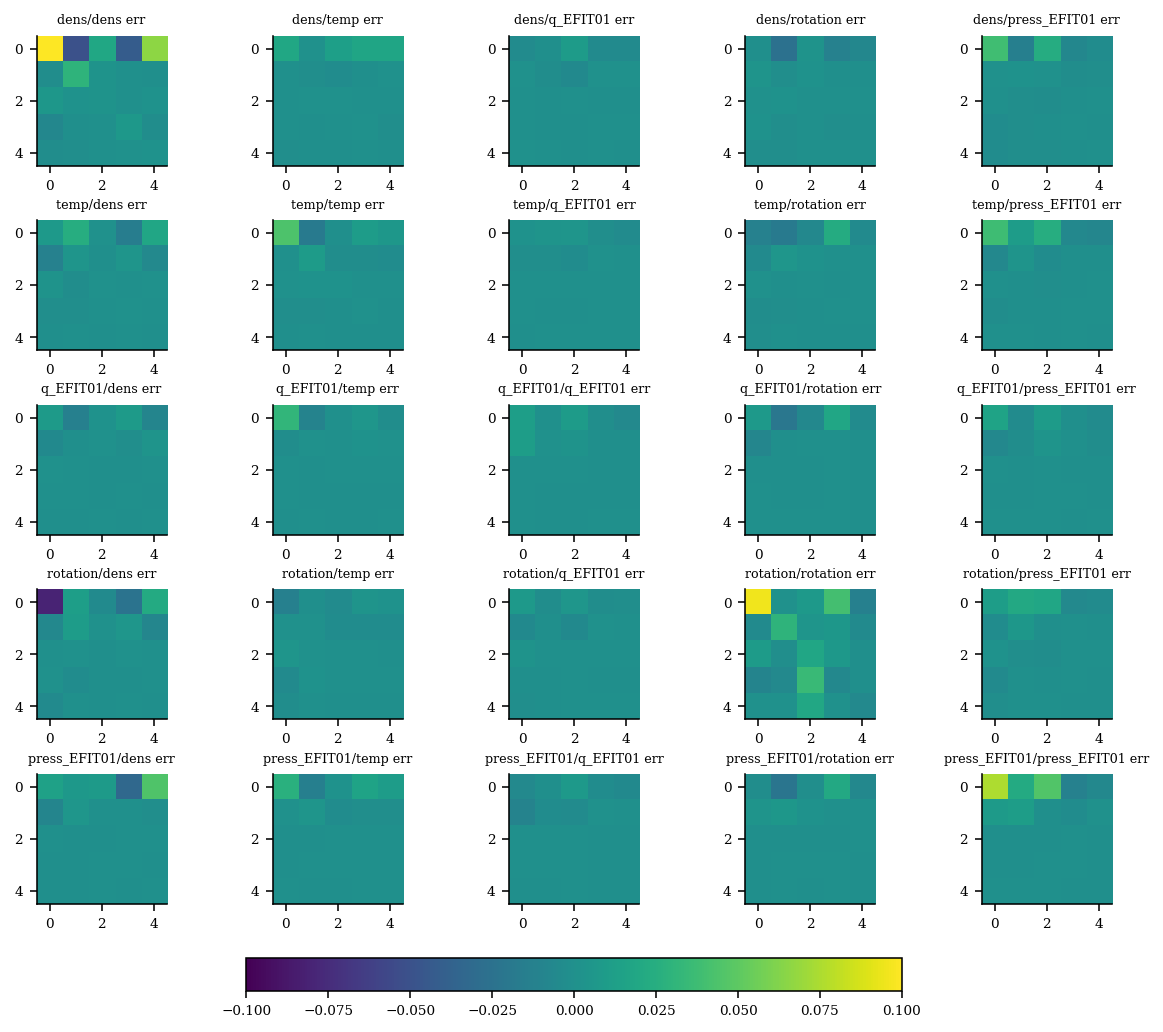

In [54]:
'''correlation coefficient pca graphs with 5 modes before linear model err correction'''
fig = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(10,10,sharex=True, sharey=True, figsize=(8,8))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.cov(coeff_og[profile], coeff_err[profile2], rowvar=False)
        #fig.add_subplot(rows, columns, counter)
        ax.append(fig.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=6.5)
        plt.imshow(corrcoef[0:5, 5:], vmin=-0.1, vmax=0.1)
        counter += 1
plt.subplots_adjust(wspace=0.6, 
                    hspace=0.42)
plt.colorbar(ax=np.array(ax).ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
plt.show()

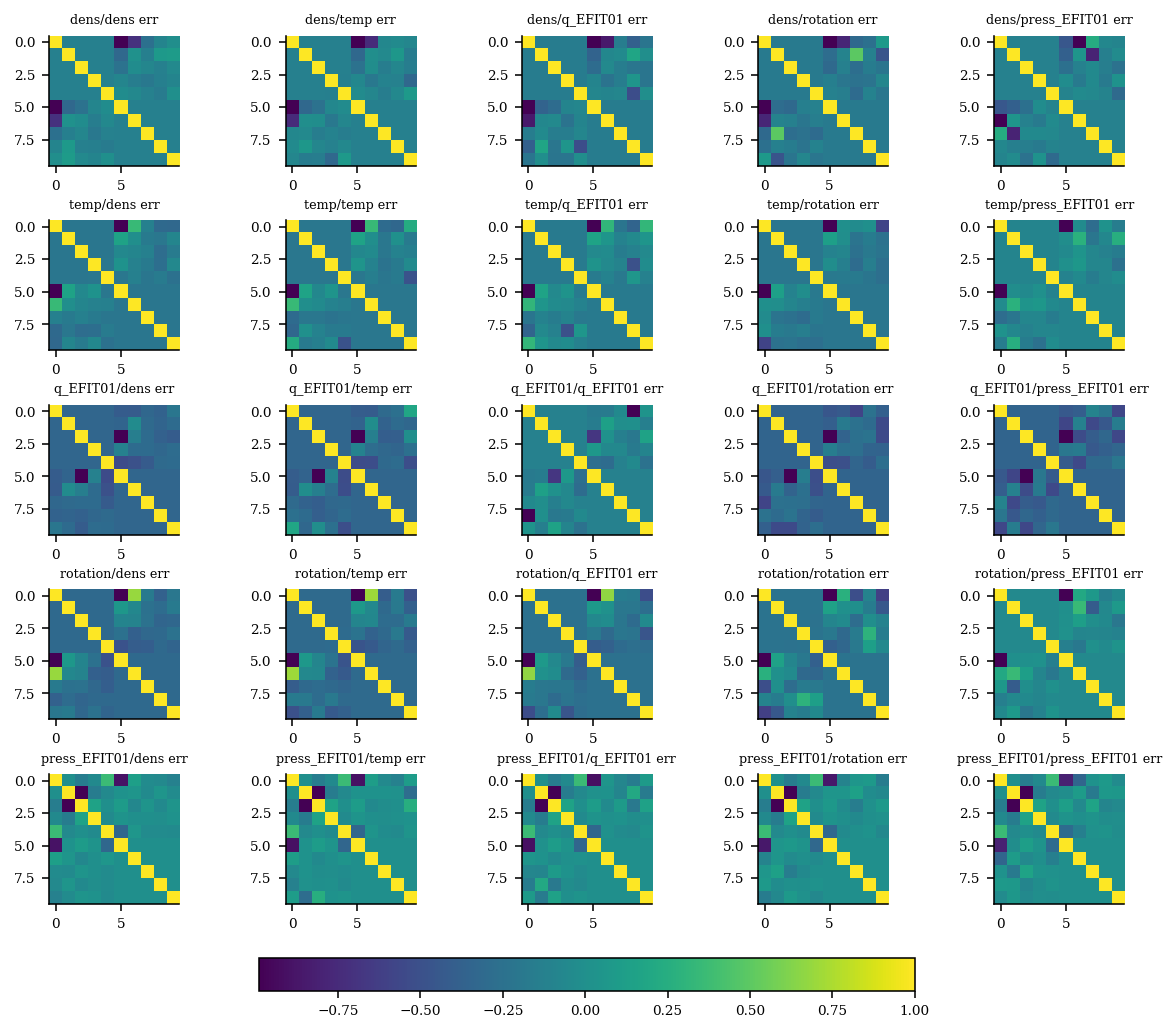

In [48]:
'''corrected error pca graphs (lin model)'''
# make a separate plot w/np.cov w/same color scale
fig_new = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(10,10,sharex=True, sharey=True, figsize=(8,8))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.corrcoef(coeff_og[profile], coeff_err_new[profile2], rowvar=False)
        #fig.add_subplot(rows, columns, counter)
        ax.append(fig_new.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=6.5)
        plt.imshow(corrcoef)
        counter += 1
plt.subplots_adjust(wspace=0.6, 
                    hspace=0.42)
plt.colorbar(ax=np.array(ax).ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
plt.show()

In [77]:
'''corrcoef difs before and after lin model'''
sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
sum5 = 0
sum6 = 0
sum7 = 0
sum8 = 0
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.cov(coeff_og[profile], coeff_err[profile2], rowvar=False)
        corrcoef_lin = np.cov(coeff_og[profile], coeff_err_new[profile2], rowvar=False)
        corrcoef_lin_bias = np.cov(coeff_og[profile], coeff_err_bias[profile2], rowvar=False)
        corrcoef_lin_bias_sliced = np.cov(coeff_og[profile], coeff_err_bias_sliced[profile2], rowvar=False)
        corrcoef_tik = np.cov(coeff_og[profile], coeff_err_tik[profile2], rowvar=False)
        corrcoef_tik_sliced = np.cov(coeff_og[profile], coeff_err_tik_sliced[profile2], rowvar=False)
        corrcoef_ridge = np.cov(coeff_og[profile], coeff_err_ridge[profile2], rowvar=False)
        corrcoef_ridge_sliced = np.cov(coeff_og[profile], coeff_err_ridge_sliced[profile2], rowvar=False)
        sum1 += np.sum(abs(corrcoef))
        sum2 += np.sum(abs(corrcoef_lin))
        sum3 += np.sum(abs(corrcoef_lin_bias))
        sum4 += np.sum(abs(corrcoef_lin_bias_sliced))
        sum5 += np.sum(abs(corrcoef_tik))
        sum6 += np.sum(abs(corrcoef_tik_sliced))
        sum7 += np.sum(abs(corrcoef_ridge))
        sum8 += np.sum(abs(corrcoef_ridge_sliced))
print(sum1)
print(sum2)
print(sum3)
print(sum4)
print(sum5)
print(sum6)
print(sum7)
print(sum8)

259.09952080739373
557.9275645768607
557.9275645768607
557.682242372997
263.8848718883473
259.69828788981044
556.6047065812502
556.6047065812502


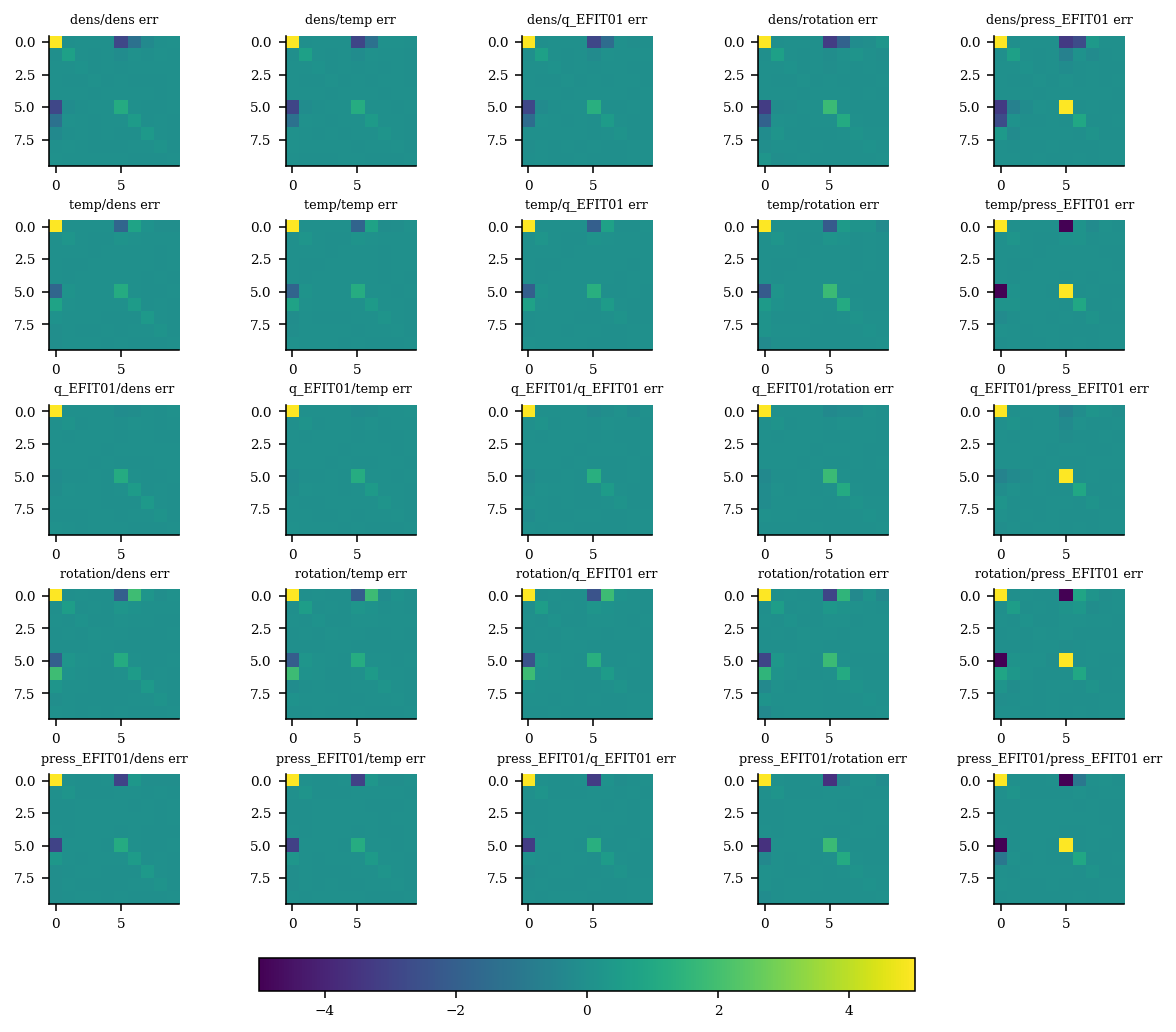

In [55]:
'''corrected error pca graphs (lin model)'''
# make a separate plot w/np.cov w/same color scale
fig_new = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(10,10,sharex=True, sharey=True, figsize=(8,8))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.cov(coeff_og[profile], coeff_err_new[profile2], rowvar=False)
        #fig.add_subplot(rows, columns, counter)
        ax.append(fig_new.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=6.5)
        plt.imshow(corrcoef, vmin=-5, vmax=5)
        counter += 1
plt.subplots_adjust(wspace=0.6, 
                    hspace=0.42)
plt.colorbar(ax=np.array(ax).ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
plt.show()

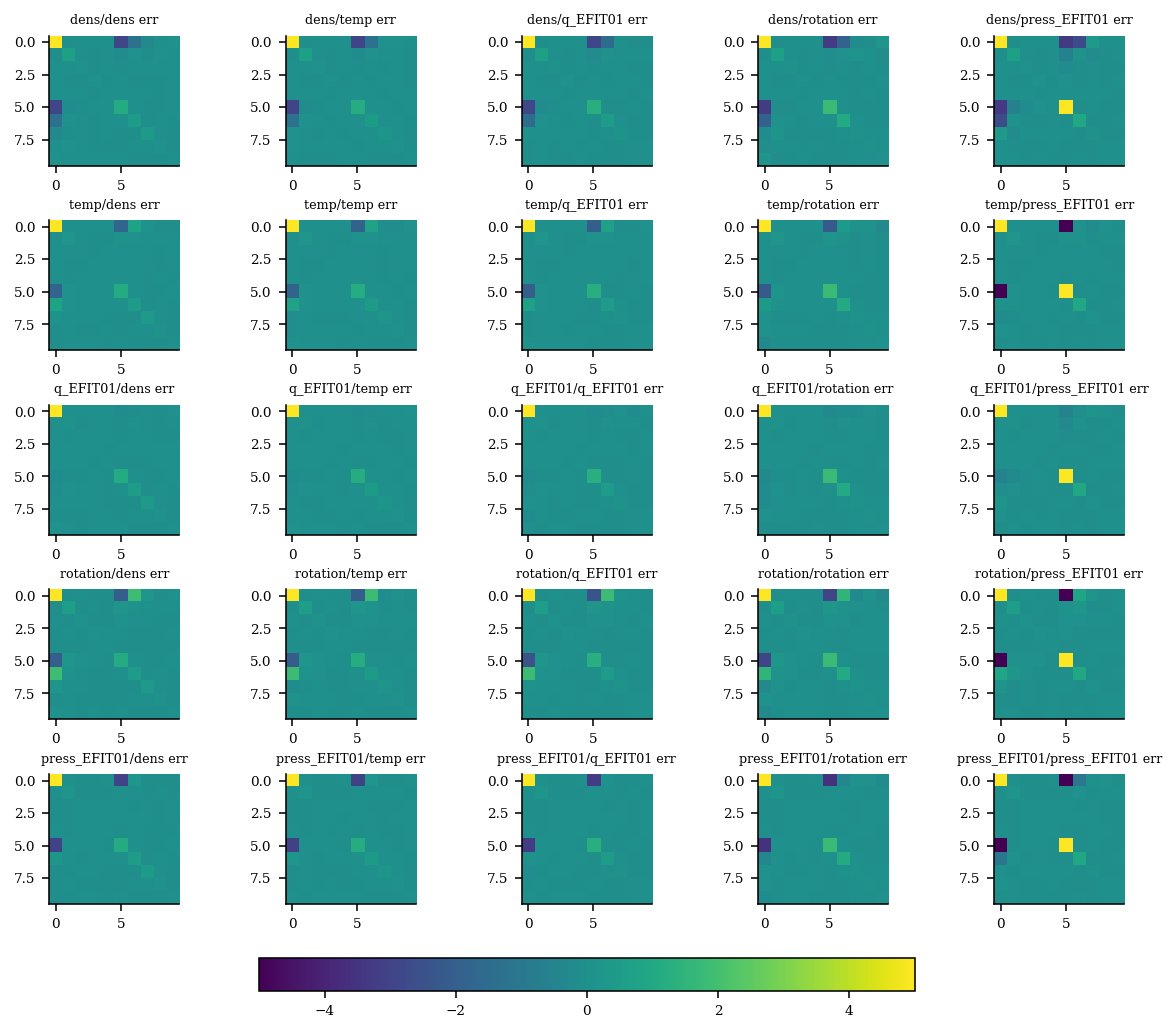

In [56]:
'''corrected error pca graphs (lin model, bias, 5 pca modes per profile)'''
# make a separate plot w/np.cov w/same color scale
fig_new = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(10,10,sharex=True, sharey=True, figsize=(8,8))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.cov(coeff_og[profile], coeff_err_bias[profile2], rowvar=False)
        #fig.add_subplot(rows, columns, counter)
        ax.append(fig_new.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=6.5)
        plt.imshow(corrcoef, vmin=-5, vmax=5)
        counter += 1
plt.subplots_adjust(wspace=0.6, 
                    hspace=0.42)
plt.colorbar(ax=np.array(ax).ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
plt.show()

25
25
Sum of errors for dens: -5.285727411319385e-11
Mean error: -1.060485249962384e-16
Sum of abs errors for dens: 36894.31852650991
Mean abs error: 0.07388379938662981
Mean squared error: 0.017007021767529714

Sum of errors for temp: -3.213784793842933e-11
Mean error: -6.388661301370835e-17
Sum of abs errors for temp: 23595.572132821886
Mean abs error: 0.04725200484788784
Mean squared error: 0.006943787981832693

Sum of errors for q_EFIT01: -1.9525714378687553e-11
Mean error: -3.9180356008194916e-17
Sum of abs errors for q_EFIT01: 15577.745637663307
Mean abs error: 0.031195671299960946
Mean squared error: 0.004365457976927432

Sum of errors for rotation: -3.8539837987627834e-11
Mean error: -7.724940478959219e-17
Sum of abs errors for rotation: 41267.232406977746
Mean abs error: 0.08264090630127156
Mean squared error: 0.029395639243003965

Sum of errors for press_EFIT01: -2.6645352591003757e-11
Mean error: -5.2800645800044066e-17
Sum of abs errors for press_EFIT01: 24144.74017072431
M

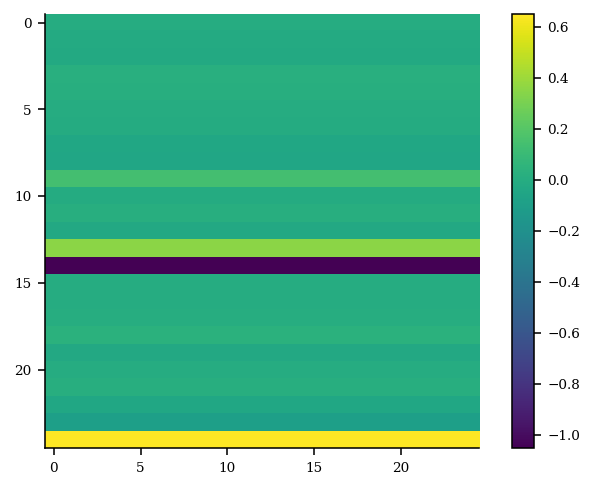

In [25]:
'''Tikhonov regularization'''
# corrcoef2 = np.corrcoef(coeff_og['dens'], coeff_err_new['dens'], rowvar=True)
# corrcoef2 = corrcoef2[0:15132, :]
# corrcoef2 = corrcoef2[:, 15132:]
# print(len(corrcoef2))
# print(len(corrcoef2[0]))
# print(len(coeff_err_new['dens']))
res_og = []
res_err = []
new_errs_tik = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
corrcoef_tik = np.zeros((25,25))
for i in range(5):
    for j in range(5):
        corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5] = (np.cov(coeff_og[profiles[i]], coeff_err[profiles[j]], rowvar=False))[0:5, 5:]
#print(len(Q))
#print(len(Q[0]))
Q = np.linalg.inv(corrcoef_tik) #25x25
P = np.linalg.inv(np.cov(res_err)) #15132x15132
#print(len(P))
#print(len(P[0]))
b = res_err
x_star = np.linalg.inv((np.transpose(res_og) @ P @ res_og)+Q) @ (np.transpose(res_og) @ P @ b)
print(len(x_star))
print(len(x_star[0]))
plt.imshow(x_star)
plt.colorbar()
lin_err = res_og @ x_star
#print(len(lin_err))
#print(len(lin_err[0]))
#print(reg.coef_)
#print(len(A.coef_))
#print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs_tik[profiles[i]] = model_err[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs_tik[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs_tik[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(new_errs_tik[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(new_errs_tik[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(new_errs_tik[profiles[i]])/(33*15132))))
    print("")

In [37]:
#print(Q)

In [23]:
weights_tik = np.zeros((25,25))
counter = 0
for i in range(5):
    for j in range(5):
        weights_tik[counter, counter] = 1.0/(full_pca_fitters[profiles[i]]).explained_variance_ratio_[j]
        counter+=1
#print(weights_tik)

25
25
Sum of errors for dens: -8.384404281969182e-13
Mean error: -1.4230153513872246e-18
Sum of abs errors for dens: 36894.35117625092
Mean abs error: 0.07388386477032605
Mean squared error: 0.017007045404783462

Sum of errors for temp: -6.110667527536862e-13
Mean error: -1.1384122811097797e-18
Sum of abs errors for temp: 23595.641109515225
Mean abs error: 0.04725214297918762
Mean squared error: 0.0069438098294884116

Sum of errors for q_EFIT01: -2.984279490192421e-13
Mean error: -4.607859233063394e-19
Sum of abs errors for q_EFIT01: 15577.811701553665
Mean abs error: 0.031195803598141735
Mean squared error: 0.004365478180946598

Sum of errors for rotation: -6.963318810448982e-13
Mean error: -1.2468324983583301e-18
Sum of abs errors for rotation: 41267.32112807628
Mean abs error: 0.08264108397230889
Mean squared error: 0.029395665530337234

Sum of errors for press_EFIT01: -5.968558980384842e-13
Mean error: -1.328147661294743e-18
Sum of abs errors for press_EFIT01: 24144.793123678744
Me

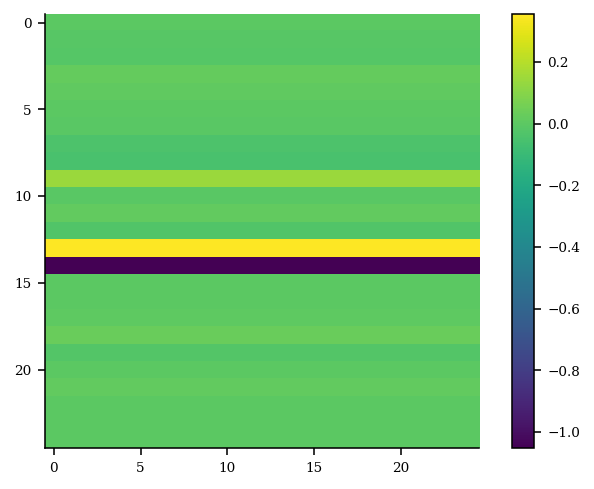

In [24]:
'''Tikhonov regularization weighted by inverse of pca variances'''
# corrcoef2 = np.corrcoef(coeff_og['dens'], coeff_err_new['dens'], rowvar=True)
# corrcoef2 = corrcoef2[0:15132, :]
# corrcoef2 = corrcoef2[:, 15132:]
# print(len(corrcoef2))
# print(len(corrcoef2[0]))
# print(len(coeff_err_new['dens']))
res_og = []
res_err = []
new_errs_tik = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
corrcoef_tik = np.zeros((25,25))
for i in range(5):
    for j in range(5):
        corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5] = (np.cov(coeff_og[profiles[i]], coeff_err[profiles[j]], rowvar=False))[0:5, 5:]
#print(len(Q))
#print(len(Q[0]))
Q = weights_tik @ np.linalg.inv(corrcoef_tik) #25x25
P = np.linalg.inv(np.cov(res_err)) #15132x15132
#print(len(P))
#print(len(P[0]))
b = res_err
x_star = np.linalg.inv((np.transpose(res_og) @ P @ res_og)+Q) @ (np.transpose(res_og) @ P @ b)
print(len(x_star))
print(len(x_star[0]))
plt.imshow(x_star)
plt.colorbar()
lin_err = res_og @ x_star
#print(len(lin_err))
#print(len(lin_err[0]))
#print(reg.coef_)
#print(len(A.coef_))
#print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs_tik[profiles[i]] = model_err[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs_tik[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs_tik[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(new_errs_tik[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(new_errs_tik[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(new_errs_tik[profiles[i]])/(33*15132))))
    print("")
'''smaller sums and means of err, bigger sums of abs err by mags of 0.1 or 0.01'''
'''mean squared err slightly bigger, but only in the 10^-8 range'''

25
25
Sum of errors for dens: -5.7269744502264075e-12
Mean error: -1.1872013788716274e-17
Sum of abs errors for dens: 36894.316342191654
Mean abs error: 0.07388379501235921
Mean squared error: 0.01700702188582789

Sum of errors for temp: -3.801403636316536e-12
Mean error: -7.94178091345632e-18
Sum of abs errors for temp: 23595.570401346333
Mean abs error: 0.047252001380470726
Mean squared error: 0.006943788158023263

Sum of errors for q_EFIT01: -2.1387336346379016e-12
Mean error: -4.431676380034499e-18
Sum of abs errors for q_EFIT01: 15577.74495539712
Mean abs error: 0.031195669933668815
Mean squared error: 0.004365458284478035

Sum of errors for rotation: -4.447997525858227e-12
Mean error: -8.944667923005412e-18
Sum of abs errors for rotation: 41267.233752104745
Mean abs error: 0.08264090899499503
Mean squared error: 0.029395639269184957

Sum of errors for press_EFIT01: -3.097966327914037e-12
Mean error: -6.288372600415926e-18
Sum of abs errors for press_EFIT01: 24144.739154328796
Mea

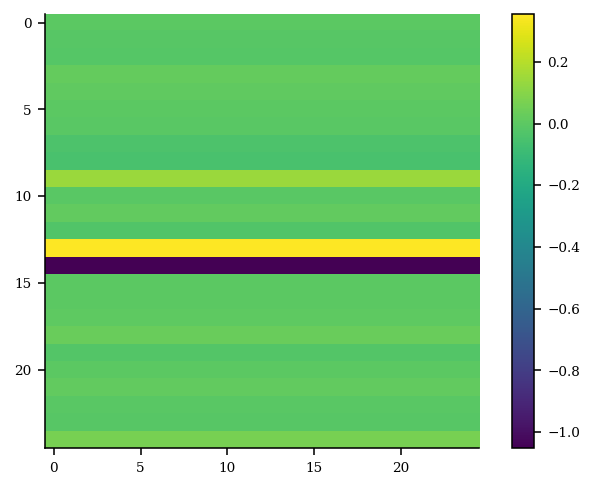

In [29]:
'''Tikhonov regularization- 10Q'''
res_og = []
res_err = []
new_errs_tik = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
corrcoef_tik = np.zeros((25,25))
for i in range(5):
    for j in range(5):
        corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5] = (np.cov(coeff_og[profiles[i]], coeff_err[profiles[j]], rowvar=False))[0:5, 5:]
#print(len(Q))
#print(len(Q[0]))
multiplier = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        if i == j:
            multiplier[i, j] = multiplier[i,j] + 10
Q = multiplier @ np.linalg.inv(corrcoef_tik) #25x25
P = np.linalg.inv(np.cov(res_err)) #15132x15132
#print(len(P))
#print(len(P[0]))
b = res_err
x_star = np.linalg.inv((np.transpose(res_og) @ P @ res_og)+Q) @ (np.transpose(res_og) @ P @ b)
print(len(x_star))
print(len(x_star[0]))
plt.imshow(x_star)
plt.colorbar()
lin_err = res_og @ x_star
#print(len(lin_err))
#print(len(lin_err[0]))
#print(reg.coef_)
#print(len(A.coef_))
#print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs_tik[profiles[i]] = model_err[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs_tik[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs_tik[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(new_errs_tik[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(new_errs_tik[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(new_errs_tik[profiles[i]])/(33*15132))))
    print("")
'''decrease in sum of abs errs by mag of 0.01 or 0.001'''
'''slighty larger mse but by mag 10^-8 range'''

25
25
Sum of errors for dens: -5.225473387326929e-10
Mean error: -1.0459433883239222e-15
Sum of abs errors for dens: 36894.34044227318
Mean abs error: 0.07388384327468414
Mean squared error: 0.01700702060881819

Sum of errors for temp: -3.156657157887821e-10
Mean error: -6.318052634887716e-16
Sum of abs errors for temp: 23595.58949843611
Mean abs error: 0.04725203962390778
Mean squared error: 0.006943786241974303

Sum of errors for q_EFIT01: -1.9311841015223763e-10
Mean error: -3.8669425734411123e-16
Sum of abs errors for q_EFIT01: 15577.752483732489
Mean abs error: 0.031195685009757553
Mean squared error: 0.004365454924182804

Sum of errors for rotation: -3.7978509226377355e-10
Mean error: -7.606220341072056e-16
Sum of abs errors for rotation: 41267.21907035776
Mean abs error: 0.08264087959363214
Mean squared error: 0.02939563900278884

Sum of errors for press_EFIT01: -2.5977442419389263e-10
Mean error: -5.202273074128572e-16
Sum of abs errors for press_EFIT01: 24144.750419077893
Mean

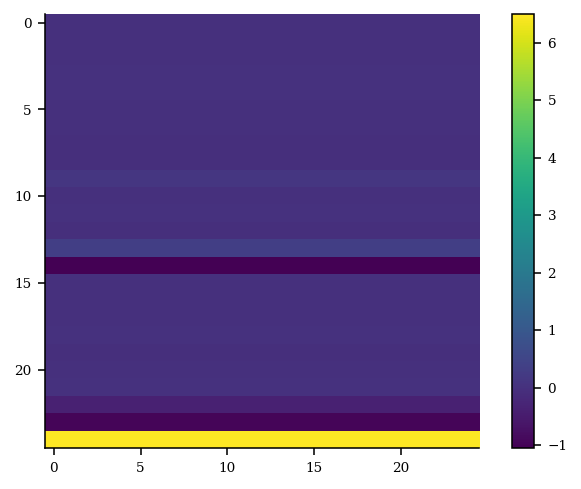

In [31]:
'''Tikhonov regularization- 0.1Q'''
res_og = []
res_err = []
new_errs_tik = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
corrcoef_tik = np.zeros((25,25))
for i in range(5):
    for j in range(5):
        corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5] = (np.cov(coeff_og[profiles[i]], coeff_err[profiles[j]], rowvar=False))[0:5, 5:]
#print(len(Q))
#print(len(Q[0]))
multiplier = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        if i == j:
            multiplier[i, j] = multiplier[i,j] + 0.1
Q = multiplier @ np.linalg.inv(corrcoef_tik) #25x25
P = np.linalg.inv(np.cov(res_err)) #15132x15132
#print(len(P))
#print(len(P[0]))
b = res_err
x_star = np.linalg.inv((np.transpose(res_og) @ P @ res_og)+Q) @ (np.transpose(res_og) @ P @ b)
print(len(x_star))
print(len(x_star[0]))
plt.imshow(x_star)
plt.colorbar()
lin_err = res_og @ x_star
#print(len(lin_err))
#print(len(lin_err[0]))
#print(reg.coef_)
#print(len(A.coef_))
#print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs_tik[profiles[i]] = model_err[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs_tik[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs_tik[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(new_errs_tik[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(new_errs_tik[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(new_errs_tik[profiles[i]])/(33*15132))))
    print("")
'''worse total errs, worse sum of abs err by 0.01, better mse around 10^-8'''

25
25
Sum of errors for dens: -1.0523848459342844e-10
Mean error: -2.106604821139335e-16
Sum of abs errors for dens: 36894.32095467761
Mean abs error: 0.0738838042492282
Mean squared error: 0.01700702163694836

Sum of errors for temp: -6.364331284203217e-11
Mean error: -1.2727178252264215e-16
Sum of abs errors for temp: 23595.574060627023
Mean abs error: 0.04725200870847053
Mean squared error: 0.006943787786851118

Sum of errors for q_EFIT01: -3.8895109355507884e-11
Mean error: -7.77237432400546e-17
Sum of abs errors for q_EFIT01: 15577.746397263447
Mean abs error: 0.03119567282112048
Mean squared error: 0.004365457635980449

Sum of errors for rotation: -7.646860922250198e-11
Mean error: -1.5273698104889544e-16
Sum of abs errors for rotation: 41267.230916431734
Mean abs error: 0.08264090331633492
Mean squared error: 0.029395639214757106

Sum of errors for press_EFIT01: -5.225331278779777e-11
Mean error: -1.0516761073109393e-16
Sum of abs errors for press_EFIT01: 24144.741301654652
Mean

'worse total errs, worse sum of abs err by 0.01, better mse around 10^-8'

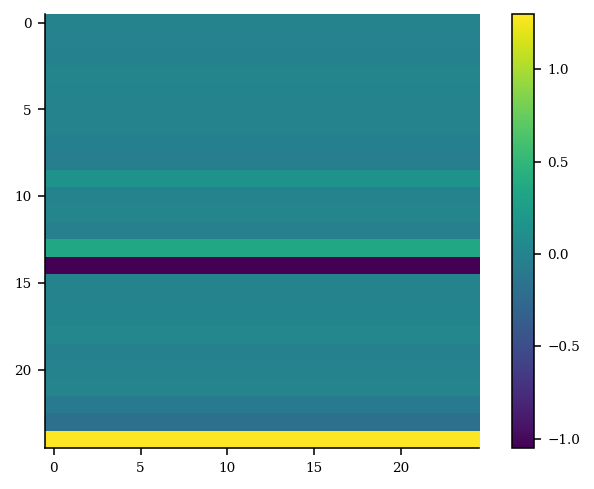

In [32]:
'''Tikhonov regularization- 0.5Q'''
res_og = []
res_err = []
new_errs_tik = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
corrcoef_tik = np.zeros((25,25))
for i in range(5):
    for j in range(5):
        corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5] = (np.cov(coeff_og[profiles[i]], coeff_err[profiles[j]], rowvar=False))[0:5, 5:]
#print(len(Q))
#print(len(Q[0]))
multiplier = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        if i == j:
            multiplier[i, j] = multiplier[i,j] + 0.5
Q = multiplier @ np.linalg.inv(corrcoef_tik) #25x25
P = np.linalg.inv(np.cov(res_err)) #15132x15132
#print(len(P))
#print(len(P[0]))
b = res_err
x_star = np.linalg.inv((np.transpose(res_og) @ P @ res_og)+Q) @ (np.transpose(res_og) @ P @ b)
print(len(x_star))
print(len(x_star[0]))
plt.imshow(x_star)
plt.colorbar()
lin_err = res_og @ x_star
#print(len(lin_err))
#print(len(lin_err[0]))
#print(reg.coef_)
#print(len(A.coef_))
#print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs_tik[profiles[i]] = model_err[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs_tik[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs_tik[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(new_errs_tik[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(new_errs_tik[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(new_errs_tik[profiles[i]])/(33*15132))))
    print("")
'''worse sum of errs, higher sum abs errs except for rotation'''

25
25
Sum of errors for dens: -1.0679457318474306e-11
Mean error: -2.2266802117421047e-17
Sum of abs errors for dens: 36894.31658453464
Mean abs error: 0.07388379549767028
Mean squared error: 0.01700702187248491

Sum of errors for temp: -7.069900220812997e-12
Mean error: -1.39455504435948e-17
Sum of abs errors for temp: 23595.57059304439
Mean abs error: 0.047252001764361284
Mean squared error: 0.006943788138264187

Sum of errors for q_EFIT01: -4.092726157978177e-12
Mean error: -8.090858712173077e-18
Sum of abs errors for q_EFIT01: 15577.745030683069
Mean abs error: 0.0311956700844349
Mean squared error: 0.00436545825013568

Sum of errors for rotation: -8.128608897095546e-12
Mean error: -1.6723818510588906e-17
Sum of abs errors for rotation: 41267.23360195951
Mean abs error: 0.08264090869431734
Mean squared error: 0.02939563926605942

Sum of errors for press_EFIT01: -5.8548721426632255e-12
Mean error: -1.0923336887791457e-17
Sum of abs errors for press_EFIT01: 24144.73926684893
Mean abs

'worse total errs, worse sum of abs err by 0.01, better mse around 10^-8'

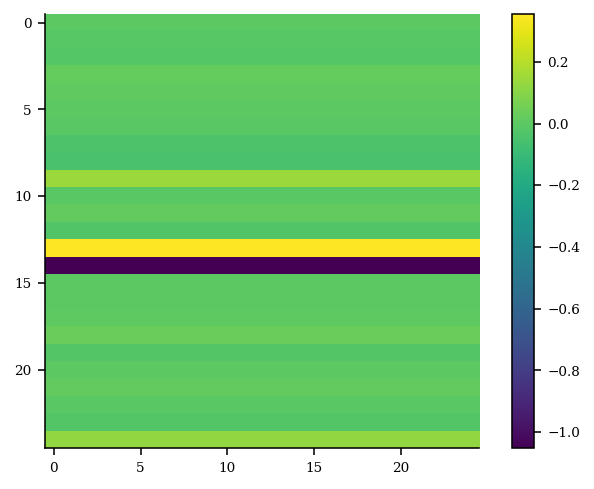

In [33]:
'''Tikhonov regularization- 5Q'''
res_og = []
res_err = []
new_errs_tik = {}
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
corrcoef_tik = np.zeros((25,25))
for i in range(5):
    for j in range(5):
        corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5] = (np.cov(coeff_og[profiles[i]], coeff_err[profiles[j]], rowvar=False))[0:5, 5:]
#print(len(Q))
#print(len(Q[0]))
multiplier = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        if i == j:
            multiplier[i, j] = multiplier[i,j] + 5
Q = multiplier @ np.linalg.inv(corrcoef_tik) #25x25
P = np.linalg.inv(np.cov(res_err)) #15132x15132
#print(len(P))
#print(len(P[0]))
b = res_err
x_star = np.linalg.inv((np.transpose(res_og) @ P @ res_og)+Q) @ (np.transpose(res_og) @ P @ b)
print(len(x_star))
print(len(x_star[0]))
plt.imshow(x_star)
plt.colorbar()
lin_err = res_og @ x_star
#print(len(lin_err))
#print(len(lin_err[0]))
#print(reg.coef_)
#print(len(A.coef_))
#print(len(A.coef_[0]))
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs_tik[profiles[i]] = model_err[profiles[i]] - correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs_tik[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs_tik[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(new_errs_tik[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(new_errs_tik[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(new_errs_tik[profiles[i]])/(33*15132))))
    print("")
'''better sum errs, +/- 0.1/0.01/0.001 for sum abs errs, slightly higher mse'''

In [30]:
test = np.zeros((25,25))
for i in range(25):
    for j in range(25):
        if i == j:
            test[i, j] = test[i,j] + 10
#print(test)

22
22
Sum of errors for dens: 1460.2608943877187
Mean error: 0.002924288272069864
Sum of errors for temp: 2228.9862097750824
Mean error: 0.00446372169309087
Sum of errors for q_EFIT01: -1589.6542288936937
Mean error: -0.003183408688177761
Sum of errors for rotation: 3847.381594090142
Mean error: 0.00770468682481064
Sum of errors for press_EFIT01: 2991.2981323166705
Mean error: 0.0059903117862139844


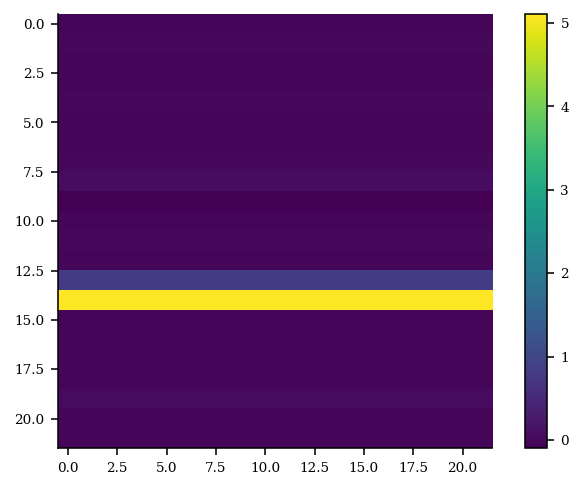

In [30]:
'''Tikhonov regularization, 2 pca modes for pressure'''
# corrcoef2 = np.corrcoef(coeff_og['dens'], coeff_err_new['dens'], rowvar=True)
# corrcoef2 = corrcoef2[0:15132, :]
# corrcoef2 = corrcoef2[:, 15132:]
# print(len(corrcoef2))
# print(len(corrcoef2[0]))
# print(len(coeff_err_new['dens']))
res_og = []
res_err = []
counter = 0
new_errs_tik_sliced = {}
for profile in profiles:
    if counter == 0:
        res_og_sliced = coeff_og_sliced[profile+""]
        res_err_sliced = coeff_err_sliced[profile+""]
    else:
        res_og_sliced = np.concatenate((res_og_sliced, coeff_og_sliced[profile+""]), axis=1)
        res_err_sliced = np.concatenate((res_err_sliced, coeff_err_sliced[profile+""]), axis=1)
    counter += 1
corrcoef_tik = np.zeros((22,22))
for i in range(5):
    for j in range(5):
        if i==4 and j==4:
            corrcoef_tik[i*5:(i+1)*5-3, j*5:(j+1)*5-3] = (np.cov(coeff_og_sliced[profiles[i]], coeff_err_sliced[profiles[j]], rowvar=False))[0:2, 2:]
        elif i==4:
            corrcoef_tik[i*5:(i+1)*5-3, j*5:(j+1)*5] = (np.cov(coeff_og_sliced[profiles[i]], coeff_err_sliced[profiles[j]], rowvar=False))[0:2, 2:]
        elif j==4:
            corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5-3] = (np.cov(coeff_og_sliced[profiles[i]], coeff_err_sliced[profiles[j]], rowvar=False))[0:5, 5:]
        else:
            corrcoef_tik[i*5:(i+1)*5, j*5:(j+1)*5] = (np.cov(coeff_og_sliced[profiles[i]], coeff_err_sliced[profiles[j]], rowvar=False))[0:5, 5:]
Q = np.linalg.inv(corrcoef_tik) #25x25
#print(len(Q))
#print(len(Q[0]))
P = np.linalg.inv(np.cov(res_err_sliced)) #15132x15132
#print(len(P))
#print(len(P[0]))
b = res_err_sliced
x_star = np.linalg.inv((np.transpose(res_og_sliced) @ P @ res_og_sliced)+Q) @ (np.transpose(res_og_sliced) @ P @ b)
print(len(x_star))
print(len(x_star[0]))
plt.imshow(x_star)
plt.colorbar()
lin_err = res_og_sliced @ x_star
for i in range(5):
    correction = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err[:, i:i+5])
    new_errs_tik_sliced[profiles[i]] = model_err[profiles[i]] + correction
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(new_errs_tik_sliced[profiles[i]])))
    print("Mean error: " + str(np.sum(new_errs_tik_sliced[profiles[i]]/(33*15132))))

In [ ]:
plt.imshow(x_star)
plt.colorbar()

In [ ]:
print(Q)

In [71]:
coeff_err_tik = {}
for profile in profiles:
    coeff_err_tik[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(new_errs_tik[profile])
    
coeff_err_tik_sliced = {}
for profile in profiles:
    coeff_err_tik_sliced[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(new_errs_tik_sliced[profile])

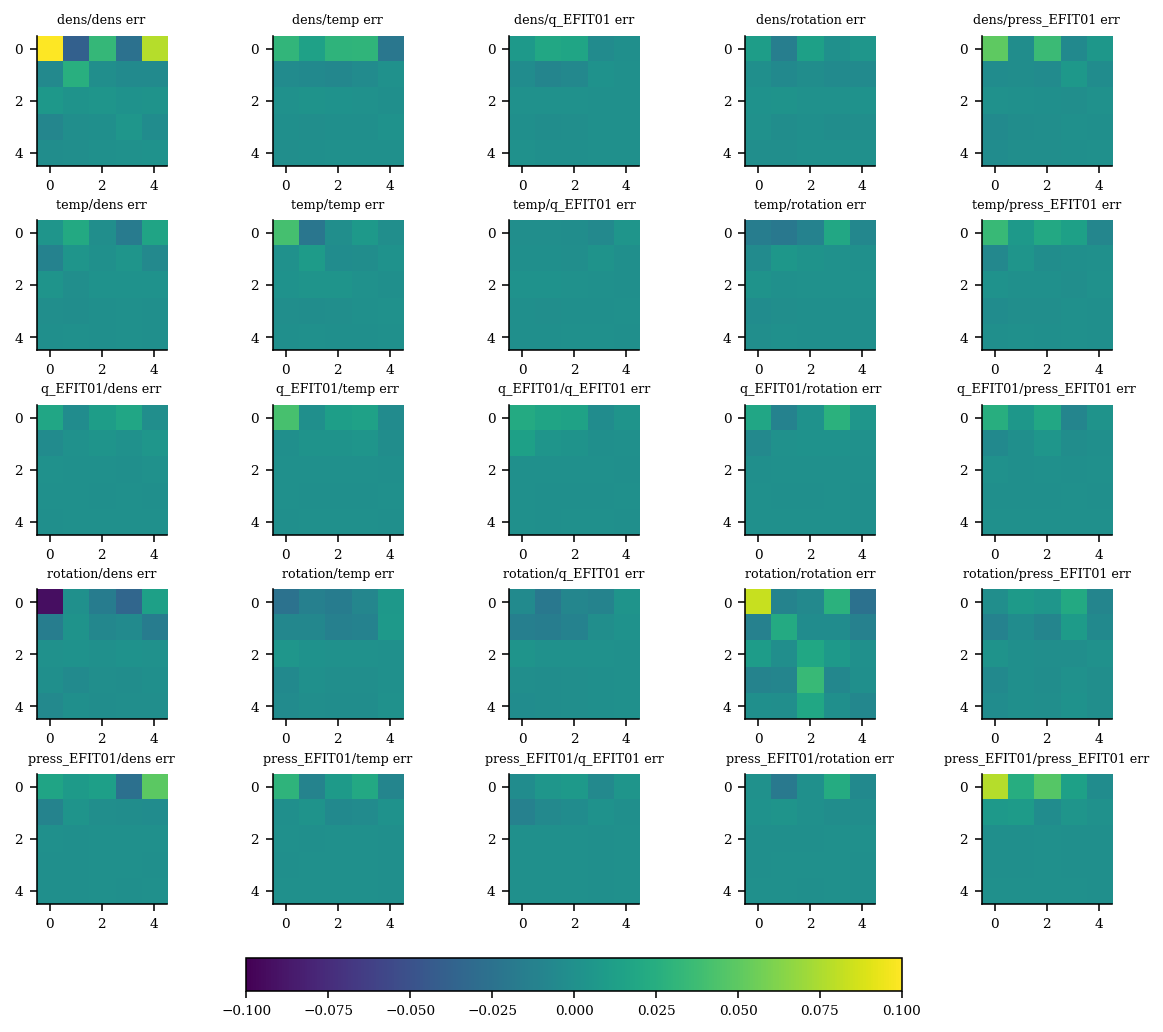

In [46]:
'''corrected error pca graphs (Tikhonov regression)'''
fig_tik = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(10,10,sharex=True, sharey=True, figsize=(8,8))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.cov(coeff_og[profile], coeff_err_tik[profile2], rowvar=False)
        #fig.add_subplot(rows, columns, counter)
        ax.append(fig_tik.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=6.5)
        plt.imshow(corrcoef[0:5, 5:], vmin=-0.1, vmax=0.1)
        counter += 1
plt.subplots_adjust(wspace=0.6, 
                    hspace=0.42)
plt.colorbar(ax=np.array(ax).ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
plt.show()
#print(np.corrcoef(coeff_og['dens'], coeff_err_tik['dens'], rowvar=False))

In [84]:
print(np.corrcoef(coeff_og['dens'], coeff_err_ttik['dens'], rowvar=False))
print(coeff_err_tik['dens']-coeff_err_ttik['dens'])

[[ 1.00000000e+00 -5.19213586e-09  1.24830674e-07  7.68824304e-09
   2.88330897e-07  5.52643943e-02 -4.06931480e-02  3.32789765e-02
  -7.92229617e-02  1.71689912e-01]
 [-5.19213586e-09  1.00000000e+00  1.07406580e-05 -6.84845997e-06
   3.29382404e-05  1.03881316e-02  1.30072812e-01  7.10700721e-02
   5.76525493e-02  5.96398192e-02]
 [ 1.24830674e-07  1.07406580e-05  1.00000000e+00 -5.66931032e-05
   3.49508900e-04  3.19095646e-02  1.78501277e-02  5.42157132e-02
   1.12048204e-02  5.13570014e-02]
 [ 7.68824304e-09 -6.84845997e-06 -5.66931032e-05  1.00000000e+00
  -3.50476905e-04 -5.10837494e-02 -7.93427772e-03  4.25708399e-03
   1.69994480e-01 -7.35501339e-02]
 [ 2.88330897e-07  3.29382404e-05  3.49508900e-04 -3.50476905e-04
   1.00000000e+00 -2.90103520e-02 -3.11185819e-02  1.61149016e-02
   6.06424049e-02  1.04017271e-01]
 [ 5.52643943e-02  1.03881316e-02  3.19095646e-02 -5.10837494e-02
  -2.90103520e-02  1.00000000e+00  2.21329164e-06 -2.00135723e-04
  -2.25647089e-04  5.30614081e-05

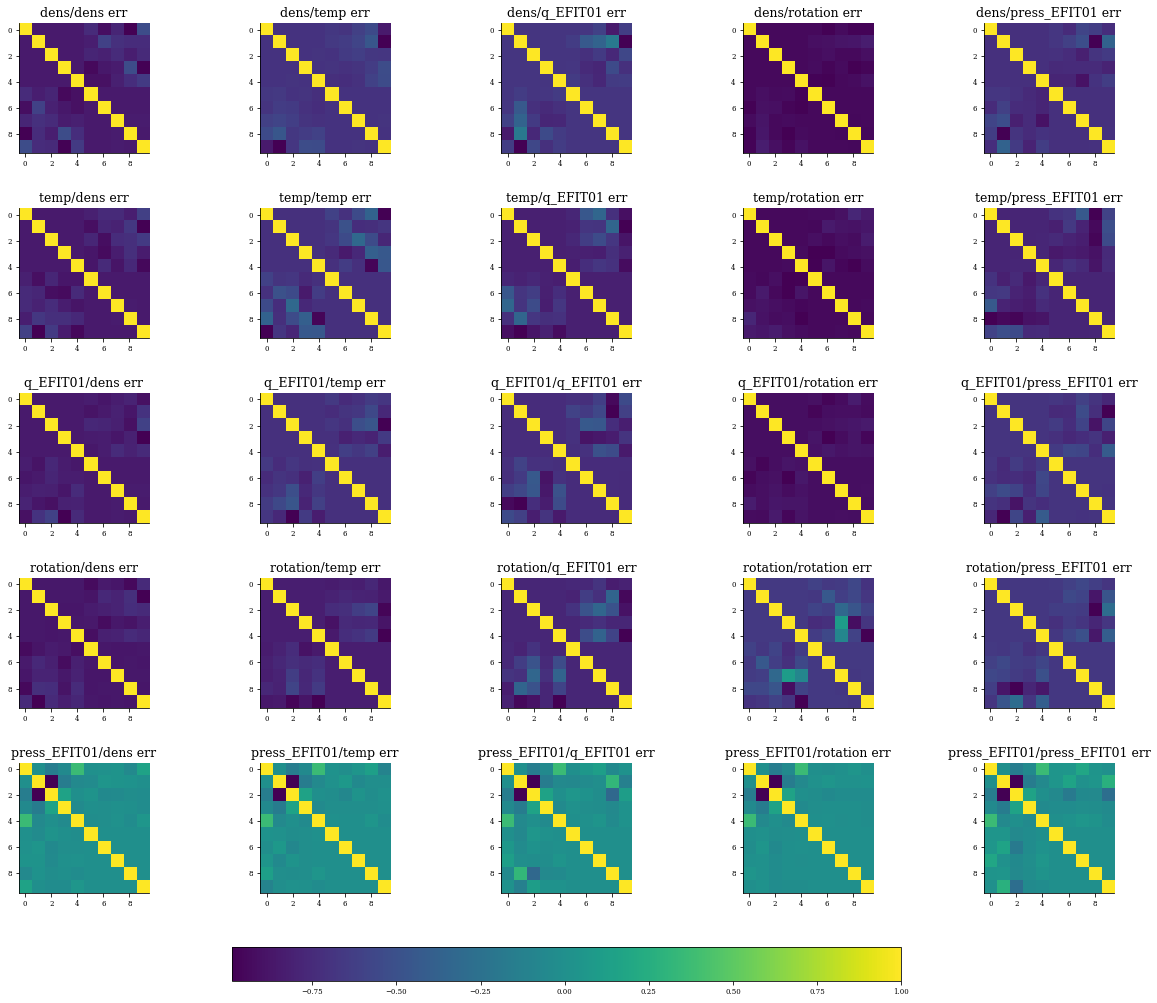

In [78]:
'''corrected error pca graphs (Tikhonov regression, 10Q)'''
fig_ttik = plt.figure(figsize=(20,20))
#fig, ax = plt.subplots(10,10,sharex=True, sharey=True, figsize=(8,8))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.corrcoef(coeff_og[profile], coeff_err_ttik[profile2], rowvar=False)
        #fig.add_subplot(rows, columns, counter)
        ax.append(fig_ttik.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=12.5)
        plt.imshow(corrcoef)
        counter += 1
plt.subplots_adjust(wspace=0.6, 
                    hspace=0.42)
plt.colorbar(ax=np.array(ax).ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
plt.show()

In [46]:
'''Ridge CV'''
ridge_errs = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
ridge.fit(res_og, res_err)
print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=ridge.alpha_)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs[profile])

0.0774263682681127
Sum of errors for dens: 1.5063505998114124e-12
Mean error: 3.198396408832238e-18
Sum of abs errors for dens: 82402.54220211456
Mean abs error: 0.16501762710794415
Mean squared error: 0.06727388857610073

Sum of errors for temp: 2.2382096176443156e-12
Mean error: 3.916680348103885e-18
Sum of abs errors for temp: 77809.58187438933
Mean abs error: 0.1558198597281084
Mean squared error: 0.05669076718320054

Sum of errors for rotation: -1.3642420526593924e-12
Mean error: -2.0599841277224584e-18
Sum of abs errors for rotation: 89966.69735313905
Mean abs error: 0.18016544780304855
Mean squared error: 0.08331087796061466

Sum of errors for q_EFIT01: 3.183231456205249e-12
Mean error: 4.553649124439119e-18
Sum of abs errors for q_EFIT01: 98323.63779968086
Mean abs error: 0.19690088393787378
Mean squared error: 0.07155662030666252

Sum of errors for press_EFIT01: 2.1600499167107046e-12
Mean error: 2.8189256484623115e-18
Sum of abs errors for press_EFIT01: 180104.70889456623
Mea

In [35]:
num_components=5
ridge_pca_fitters = {}
#delta_pca_fitters = {}

for profile in profiles:
    full_ridge = ridge_errs[profile]
    #delta = np.array([train_generator[i][1]['target_' + profile] for i in range(len(train_generator))]).squeeze()
    #print(profile, ' made arrays')
    ridge_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full_ridge)
    print(profile, ' done full')

dens  done full
temp  done full
q_EFIT01  done full
rotation  done full
press_EFIT01  done full


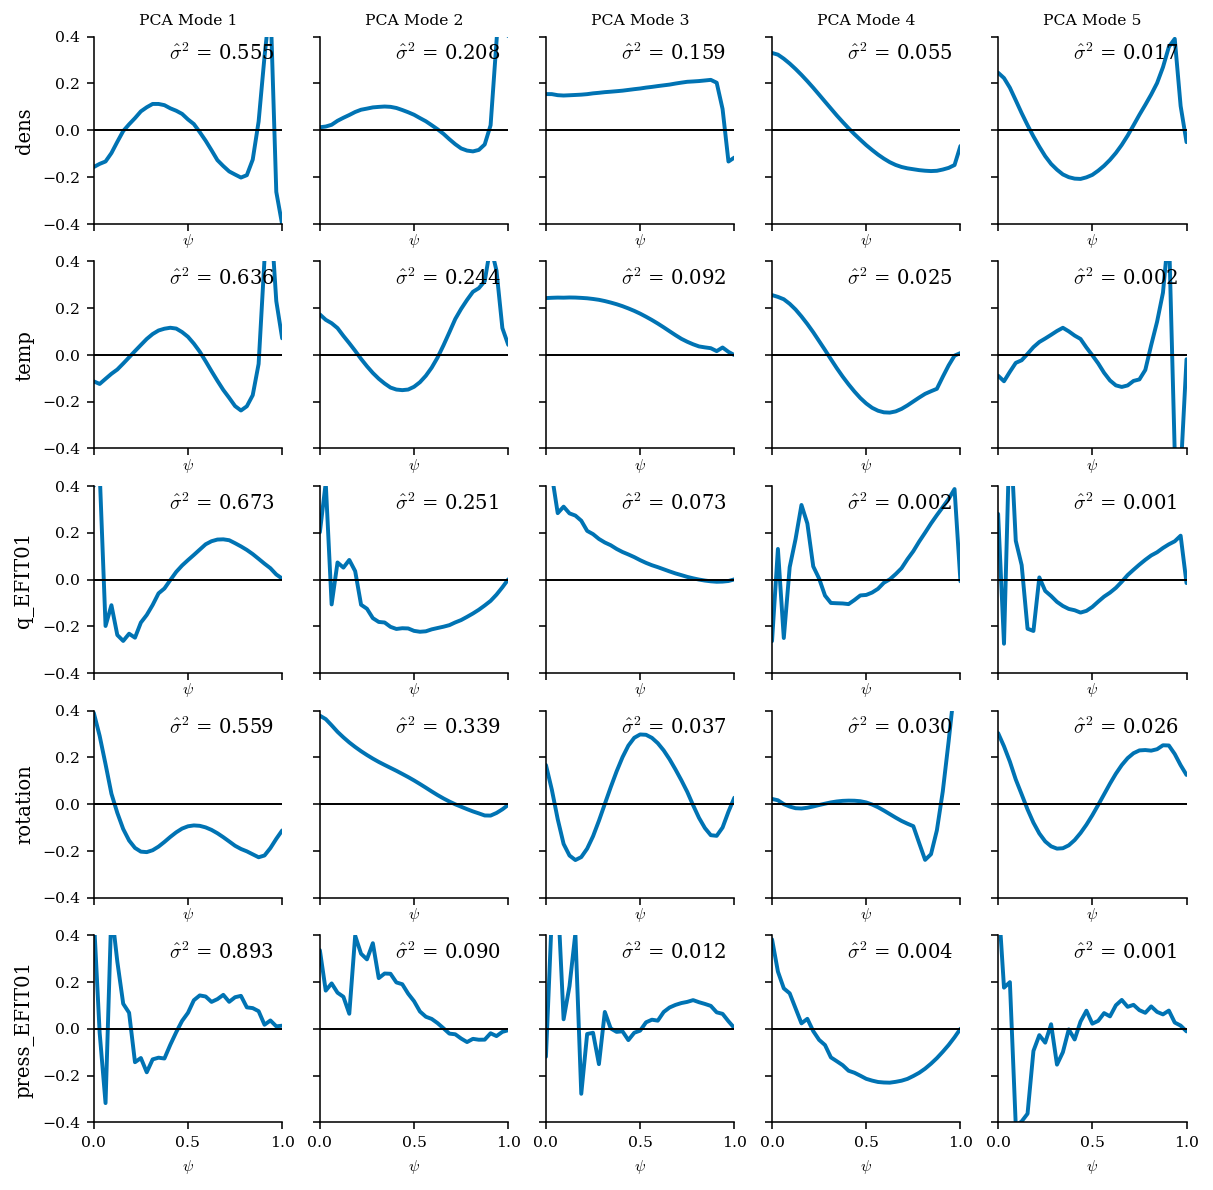

In [36]:
"""og ridge pca modes"""

ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):
    ridge_og=ridge_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,ridge_og.components_[j],lw=2)
        ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(ridge_og.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        ax.set_xlabel('$\psi$',size=8)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)

In [47]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

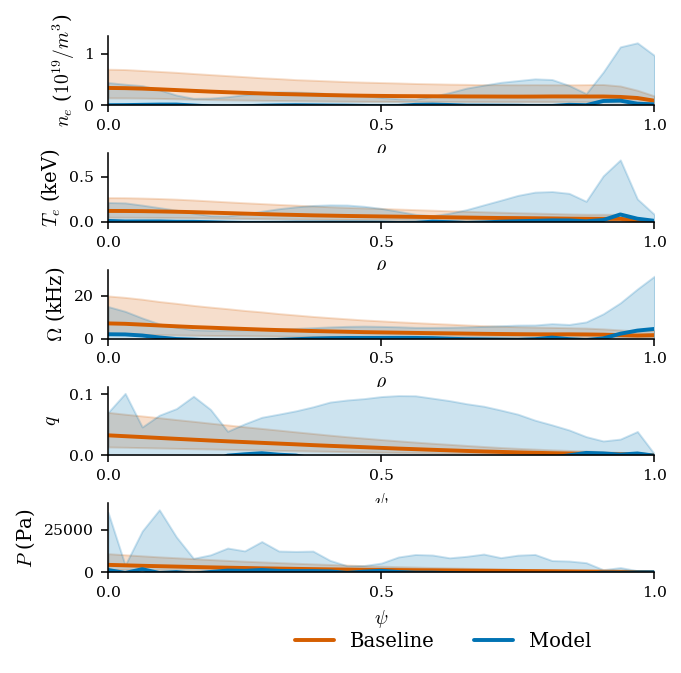

In [48]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [72]:
'''***significant decrease in abs err metrics'''
'''Ridge CV alpha = 10'''
ridge_errs_10 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=10)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_10[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_10[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_10[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_10[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_10[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_10[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_10[profile])

Sum of errors for dens: 1.4210854715202004e-12
Mean error: 1.951563910473908e-18
Sum of abs errors for dens: 81773.39470771473
Mean abs error: 0.1637577093450659
Mean squared error: 0.0658958384839751

Sum of errors for temp: 1.7479351299698465e-12
Mean error: 2.9002408113987244e-18
Sum of abs errors for temp: 76004.87573721146
Mean abs error: 0.15220579253520827
Mean squared error: 0.05529670906050344

Sum of errors for rotation: -1.8189894035458565e-12
Mean error: -2.0599841277224584e-18
Sum of abs errors for rotation: 86841.3240154318
Mean abs error: 0.17390663978290388
Mean squared error: 0.08075298574356589

Sum of errors for q_EFIT01: 2.5011104298755527e-12
Mean error: 7.15573433840433e-18
Sum of abs errors for q_EFIT01: 93429.11750665995
Mean abs error: 0.18709921880714353
Mean squared error: 0.06529764896165655

Sum of errors for press_EFIT01: 1.9326762412674725e-12
Mean error: 2.168404344971009e-18
Sum of abs errors for press_EFIT01: 158372.93713562866
Mean abs error: 0.317154

In [50]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_10[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_10[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_10[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

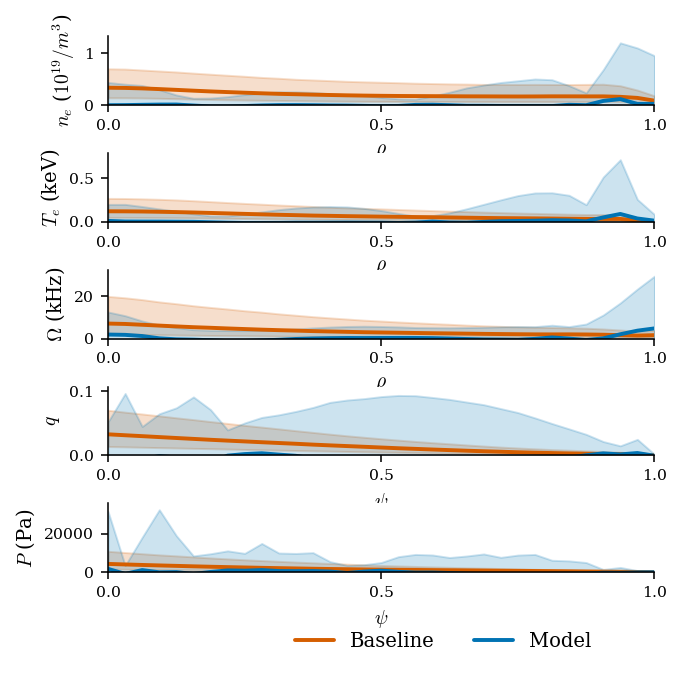

In [51]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

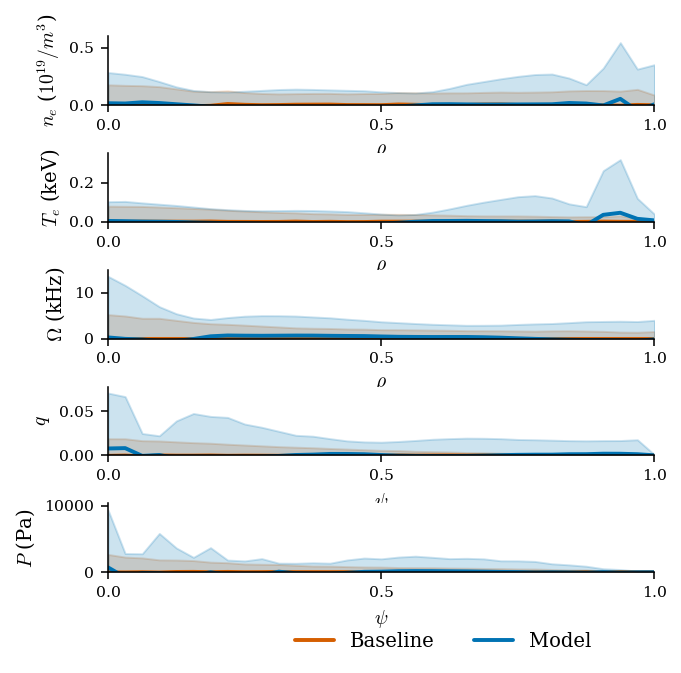

In [73]:
hi_per = 75
low_per = 25
errs=ridge_errs_600

baseline_err = {sig: np.abs(model_err[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(errs[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
#print(med_baseline_err)

med_model_hiper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

plot_ridge()

In [37]:
num_components=5
ridge_10_pca_fitters = {}

for profile in profiles:
    ridge_10 = ridge_errs_10[profile]
    ridge_10_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(ridge_10)
    print(profile, ' done full')

dens  done full
temp  done full
q_EFIT01  done full
rotation  done full
press_EFIT01  done full


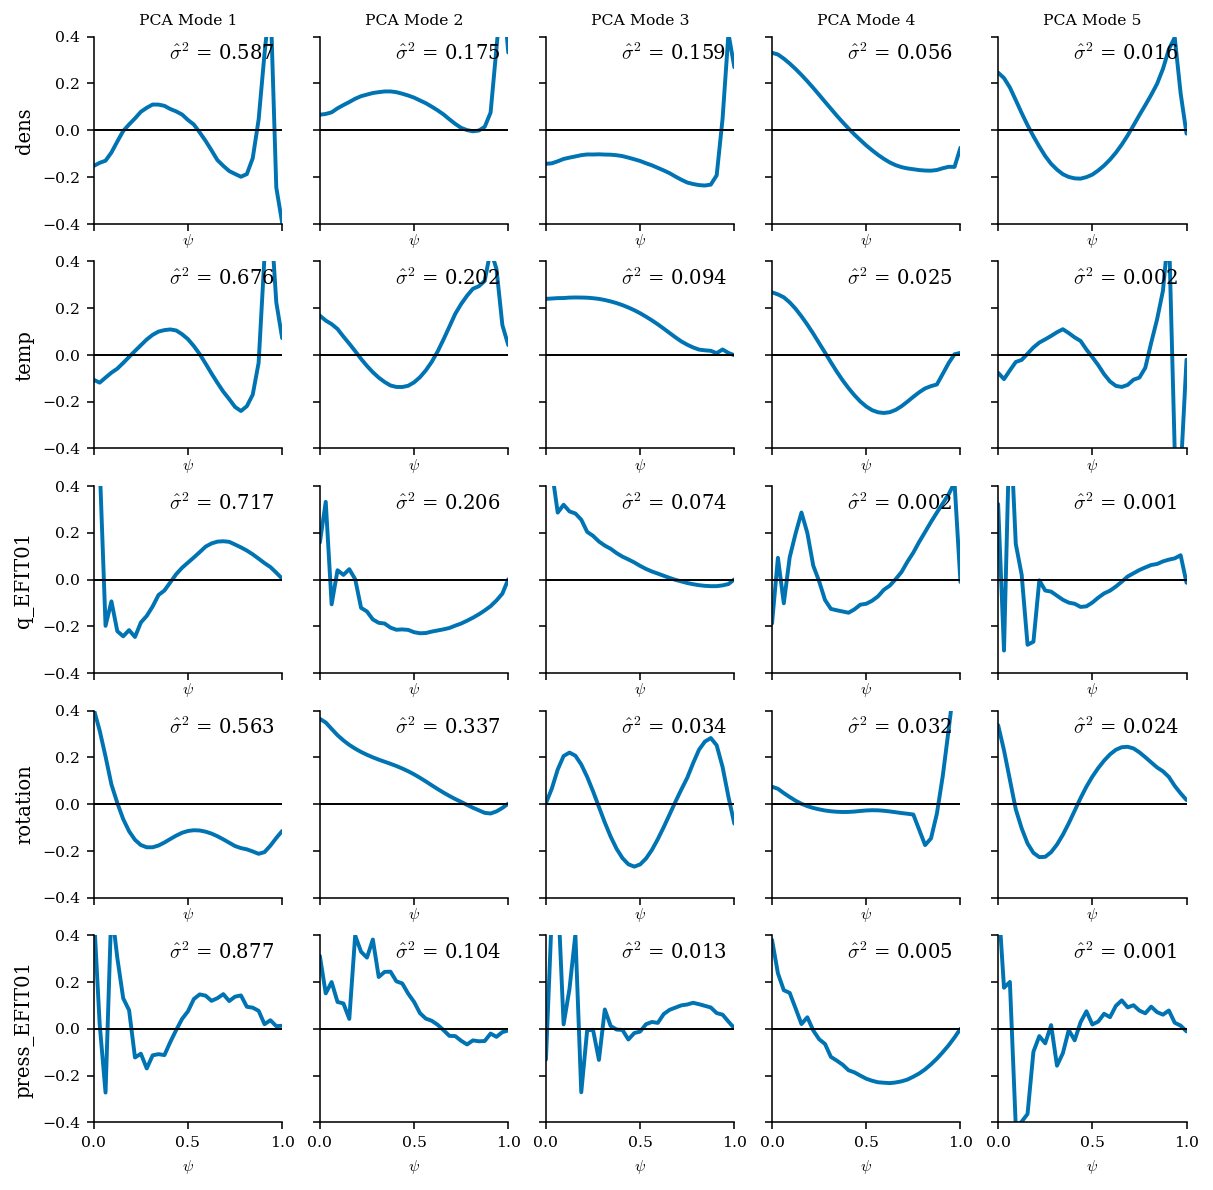

In [38]:
"""a=10 ridge pca modes"""

ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):
    ridge_10=ridge_10_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,ridge_10.components_[j],lw=2)
        ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(ridge_10.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        ax.set_xlabel('$\psi$',size=8)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)

In [28]:
'''Ridge CV alpha = 5'''
ridge_errs_5 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
ridge2 = linear_model.Ridge(alpha=5)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_5[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_5[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_5[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_5[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_5[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_5[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_5[profile])

Sum of errors for dens: 1.2221335055073723e-12
Mean error: 2.710505431213761e-18
Sum of abs errors for dens: 82344.80006669115
Mean abs error: 0.16490199390152746
Mean squared error: 0.06712752400922313

Sum of errors for temp: 1.9113599591946695e-12
Mean error: 3.97089045672816e-18
Sum of abs errors for temp: 77209.46132636422
Mean abs error: 0.15461807072782585
Mean squared error: 0.05651621798653833

Sum of errors for q_EFIT01: -1.3642420526593924e-12
Mean error: -3.686287386450715e-18
Sum of abs errors for q_EFIT01: 83450.93594244307
Mean abs error: 0.16711711873381532
Mean squared error: 0.05745741791641428

Sum of errors for rotation: 3.694822225952521e-12
Mean error: 6.830473686658678e-18
Sum of abs errors for rotation: 108161.86498724156
Mean abs error: 0.21660271427046338
Mean squared error: 0.091893142573605

Sum of errors for press_EFIT01: 1.3642420526593924e-12
Mean error: 2.168404344971009e-18
Sum of abs errors for press_EFIT01: 167202.2957567308
Mean abs error: 0.33483586

In [29]:
'''Ridge CV alpha = 15'''
'''better than 10 and 5 (5 worse than 10), half of signed errs increase, half decrease but only a bit'''
ridge_errs_15 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=15)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_15[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_15[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_15[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_15[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_15[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_15[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_15[profile])

Sum of errors for dens: 1.1652900866465643e-12
Mean error: 1.3552527156068805e-18
Sum of abs errors for dens: 81173.5246925702
Mean abs error: 0.16255642205674947
Mean squared error: 0.06468207810566108

Sum of errors for temp: 1.7550405573274475e-12
Mean error: 3.5101045334218206e-18
Sum of abs errors for temp: 74870.0260442309
Mean abs error: 0.1499331660062779
Mean squared error: 0.05409866795986017

Sum of errors for q_EFIT01: -1.5916157281026244e-12
Mean error: -5.421010862427522e-18
Sum of abs errors for q_EFIT01: 80507.84813566024
Mean abs error: 0.16122335194863022
Mean squared error: 0.05443536916004609

Sum of errors for rotation: 3.126388037344441e-12
Mean error: 2.3852447794681098e-18
Sum of abs errors for rotation: 105081.17643065893
Mean abs error: 0.21043339106901468
Mean squared error: 0.08757805661700406

Sum of errors for press_EFIT01: 1.0231815394945443e-12
Mean error: 1.734723475976807e-18
Sum of abs errors for press_EFIT01: 150819.1634616022
Mean abs error: 0.30202

In [30]:
'''Ridge CV alpha = 20'''
'''signed errs start increasing, some doubling'''
ridge_errs_20 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=20)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_20[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_20[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_20[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_20[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_20[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_20[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_20[profile])

Sum of errors for dens: 1.1368683772161603e-12
Mean error: 2.2768245622195593e-18
Sum of abs errors for dens: 80574.58492212377
Mean abs error: 0.1613569976572301
Mean squared error: 0.06352108114200192

Sum of errors for temp: 1.9468870959826745e-12
Mean error: 3.3068166260807885e-18
Sum of abs errors for temp: 73813.48362013225
Mean abs error: 0.14781735599478577
Mean squared error: 0.05295462011929403

Sum of errors for q_EFIT01: -2.3874235921539366e-12
Mean error: -4.336808689942018e-18
Sum of abs errors for q_EFIT01: 79208.61087662676
Mean abs error: 0.15862152627910103
Mean squared error: 0.05308963156722034

Sum of errors for rotation: 3.637978807091713e-12
Mean error: 5.854691731421724e-18
Sum of abs errors for rotation: 103712.6856274035
Mean abs error: 0.20769287968383973
Mean squared error: 0.08576831029120703

Sum of errors for press_EFIT01: 2.2737367544323206e-12
Mean error: 4.336808689942018e-19
Sum of abs errors for press_EFIT01: 144194.68664904716
Mean abs error: 0.2887

In [32]:
'''Ridge CV alpha = 25'''
ridge_errs_25 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=25)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_25[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_25[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_25[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_25[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_25[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_25[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_25[profile])

Sum of errors for dens: 1.0231815394945443e-12
Mean error: 1.8973538018496328e-18
Sum of abs errors for dens: 79979.14690185332
Mean abs error: 0.16016458579020448
Mean squared error: 0.062406540030024805

Sum of errors for temp: 1.4424017535930034e-12
Mean error: 3.5236570605778894e-18
Sum of abs errors for temp: 72823.17771167491
Mean abs error: 0.14583418985988933
Mean squared error: 0.05185747473215114

Sum of errors for q_EFIT01: -1.7621459846850485e-12
Mean error: -3.144186300207963e-18
Sum of abs errors for q_EFIT01: 77998.82150118549
Mean abs error: 0.156198827091665
Mean squared error: 0.0518281804090834

Sum of errors for rotation: 1.5347723092418164e-12
Mean error: 2.3852447794681098e-18
Sum of abs errors for rotation: 102424.60935550781
Mean abs error: 0.20511340477636752
Mean squared error: 0.08409706020766809

Sum of errors for press_EFIT01: -1.1368683772161603e-13
Mean error: 5.854691731421724e-18
Sum of abs errors for press_EFIT01: 138312.6464267785
Mean abs error: 0.27

In [33]:
'''Ridge CV alpha = 30'''
ridge_errs_30 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=30)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_30[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_30[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_30[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_30[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_30[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_30[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_30[profile])

Sum of errors for dens: 1.2789769243681803e-12
Mean error: 1.951563910473908e-18
Sum of abs errors for dens: 79387.31211181487
Mean abs error: 0.15897938967753444
Mean squared error: 0.061330873455582476

Sum of errors for temp: 1.5702994460298214e-12
Mean error: 2.8731357570865868e-18
Sum of abs errors for temp: 71887.4147095469
Mean abs error: 0.14396025022137898
Mean squared error: 0.0507992742181089

Sum of errors for q_EFIT01: -1.7053025658242404e-12
Mean error: -4.662069341687669e-18
Sum of abs errors for q_EFIT01: 76860.10268816975
Mean abs error: 0.15391845234295723
Mean squared error: 0.05063317644586733

Sum of errors for rotation: 1.7621459846850485e-12
Mean error: 5.637851296924623e-18
Sum of abs errors for rotation: 101200.86694956839
Mean abs error: 0.2026627635385745
Mean squared error: 0.08253242085727222

Sum of errors for press_EFIT01: 7.958078640513122e-13
Mean error: -2.168404344971009e-18
Sum of abs errors for press_EFIT01: 133041.1531579145
Mean abs error: 0.26642

In [34]:
'''Ridge CV alpha = 40'''
ridge_errs_40 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=40)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_40[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_40[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_40[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_40[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_40[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_40[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_40[profile])

Sum of errors for dens: 5.826450433232822e-13
Mean error: 1.6805133673525319e-18
Sum of abs errors for dens: 78214.4549437276
Mean abs error: 0.15663065016486757
Mean squared error: 0.05927689063537709

Sum of errors for temp: 1.6484591469634324e-12
Mean error: 2.778268066994105e-18
Sum of abs errors for temp: 70144.64477317971
Mean abs error: 0.14047021518351585
Mean squared error: 0.04877969106088205

Sum of errors for q_EFIT01: -8.526512829121202e-13
Mean error: -3.144186300207963e-18
Sum of abs errors for q_EFIT01: 74753.51079186457
Mean abs error: 0.14969983497117198
Mean squared error: 0.04839853943701551

Sum of errors for rotation: 2.9558577807620168e-12
Mean error: 5.637851296924623e-18
Sum of abs errors for rotation: 98906.3931839422
Mean abs error: 0.19806789782027687
Mean squared error: 0.07964969257278273

Sum of errors for press_EFIT01: 6.821210263296962e-13
Mean error: 4.336808689942018e-19
Sum of abs errors for press_EFIT01: 123965.51408251512
Mean abs error: 0.24825077

In [36]:
'''Ridge CV alpha = 50'''
ridge_errs_50 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=50)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_50[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_50[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_50[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_50[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_50[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_50[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_50[profile])

Sum of errors for dens: 6.679101716144942e-13
Mean error: 2.9815559743351372e-18
Sum of abs errors for dens: 77059.6013653796
Mean abs error: 0.1543179642687373
Mean squared error: 0.05733631437033253

Sum of errors for temp: 1.4637180356658064e-12
Mean error: 2.9544509200229996e-18
Sum of abs errors for temp: 68539.59783176224
Mean abs error: 0.1372559813675258
Mean squared error: 0.04687221675361909

Sum of errors for q_EFIT01: -2.3305801732931286e-12
Mean error: -3.3610267347050637e-18
Sum of abs errors for q_EFIT01: 72825.99107835973
Mean abs error: 0.14583982384983807
Mean squared error: 0.04632976370101074

Sum of errors for rotation: 1.3073986337985843e-12
Mean error: 7.806255641895632e-18
Sum of abs errors for rotation: 96775.52097886887
Mean abs error: 0.19380065720421674
Mean squared error: 0.0770262922638265

Sum of errors for press_EFIT01: -4.547473508864641e-13
Mean error: -1.0842021724855044e-18
Sum of abs errors for press_EFIT01: 116406.51872795605
Mean abs error: 0.2331

In [44]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_50[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_50[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_50[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

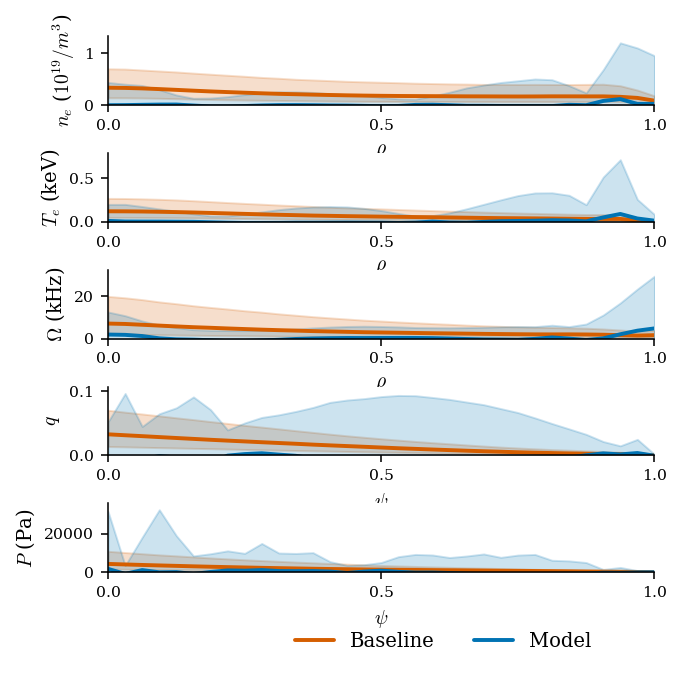

In [52]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [37]:
'''Ridge CV alpha = 100'''
ridge_errs_100 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=100)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_100[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_100[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_100[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_100[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_100[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_100[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_100[profile])

Sum of errors for dens: 5.400124791776761e-13
Mean error: 1.0842021724855044e-18
Sum of abs errors for dens: 71735.4577543589
Mean abs error: 0.14365594436506002
Mean squared error: 0.04912409459335321

Sum of errors for temp: 1.0977885267493548e-12
Mean error: 3.0222135558033436e-18
Sum of abs errors for temp: 61926.919899697845
Mean abs error: 0.12401356927662399
Mean squared error: 0.038801249716412904

Sum of errors for q_EFIT01: -1.8189894035458565e-12
Mean error: -3.144186300207963e-18
Sum of abs errors for q_EFIT01: 64934.21230350445
Mean abs error: 0.13003591086019675
Mean squared error: 0.03782806258025987

Sum of errors for rotation: 2.3305801732931286e-12
Mean error: 5.5294310796760726e-18
Sum of abs errors for rotation: 87879.12934211851
Mean abs error: 0.17598492727056148
Mean squared error: 0.06661193251039549

Sum of errors for press_EFIT01: 1.4779288903810084e-12
Mean error: 2.4936649967166602e-18
Sum of abs errors for press_EFIT01: 91670.29341989484
Mean abs error: 0.1

In [42]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_100[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_100[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_100[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

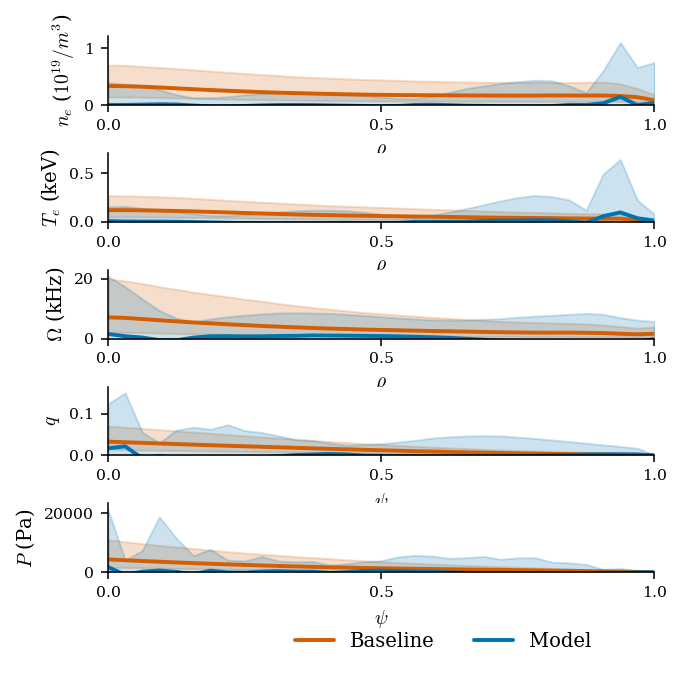

In [43]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center", fo
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [38]:
'''Ridge CV alpha = 200'''
ridge_errs_200 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=200)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_200[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_200[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_200[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_200[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_200[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_200[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_200[profile])

Sum of errors for dens: 6.252776074688882e-13
Mean error: 2.710505431213761e-19
Sum of abs errors for dens: 63744.414934697146
Mean abs error: 0.12765324725185473
Mean squared error: 0.038492195539055175

Sum of errors for temp: 1.2114753644709708e-12
Mean error: 2.425902360936316e-18
Sum of abs errors for temp: 53045.29899858048
Mean abs error: 0.10622741891272057
Mean squared error: 0.02835615839041663

Sum of errors for q_EFIT01: -1.5347723092418164e-12
Mean error: -2.7647155398380363e-18
Sum of abs errors for q_EFIT01: 54353.89257171478
Mean abs error: 0.10884798134339989
Mean squared error: 0.027090989358568685

Sum of errors for rotation: 2.4726887204451486e-12
Mean error: 4.607859233063394e-18
Sum of abs errors for rotation: 75844.48912099168
Mean abs error: 0.15188460561401423
Mean squared error: 0.05405413050018402

Sum of errors for press_EFIT01: -1.3073986337985843e-12
Mean error: 1.0842021724855044e-19
Sum of abs errors for press_EFIT01: 68550.1463509144
Mean abs error: 0.1

In [39]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.9000, 0.6000, 0.0000)] # orange

labelsize=10
ticksize=8

In [40]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_200[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_200[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_200[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

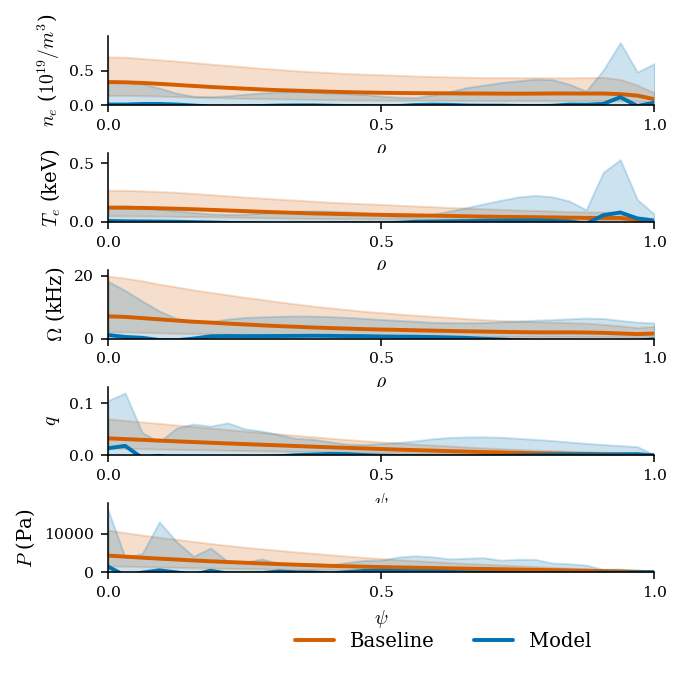

In [41]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [25]:
'''ridge alpha = 300'''
ridge_errs_300 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=300)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_300[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_300[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_300[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_300[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_300[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_300[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_300[profile])

Sum of errors for dens: 1.4210854715202004e-13
Mean error: 1.3010426069826053e-18
Sum of abs errors for dens: 58404.02348903297
Mean abs error: 0.11695868977049032
Mean squared error: 0.03241349222667979

Sum of errors for temp: 4.156675004196586e-13
Mean error: 1.2671612890924333e-18
Sum of abs errors for temp: 47398.15344852126
Mean abs error: 0.09491856200490488
Mean squared error: 0.022389980787537678

Sum of errors for q_EFIT01: -1.3358203432289883e-12
Mean error: -2.4936649967166602e-18
Sum of abs errors for q_EFIT01: 47603.77360028356
Mean abs error: 0.09533033266904489
Mean squared error: 0.021003428608202836

Sum of errors for rotation: 2.1032064978498966e-12
Mean error: 3.144186300207963e-18
Sum of abs errors for rotation: 68266.52017682287
Mean abs error: 0.13670912170239843
Mean squared error: 0.047150742869088165

Sum of errors for press_EFIT01: -9.094947017729282e-13
Mean error: -7.589415207398531e-19
Sum of abs errors for press_EFIT01: 57124.048214602306
Mean abs error: 

In [26]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_300[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_300[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_300[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

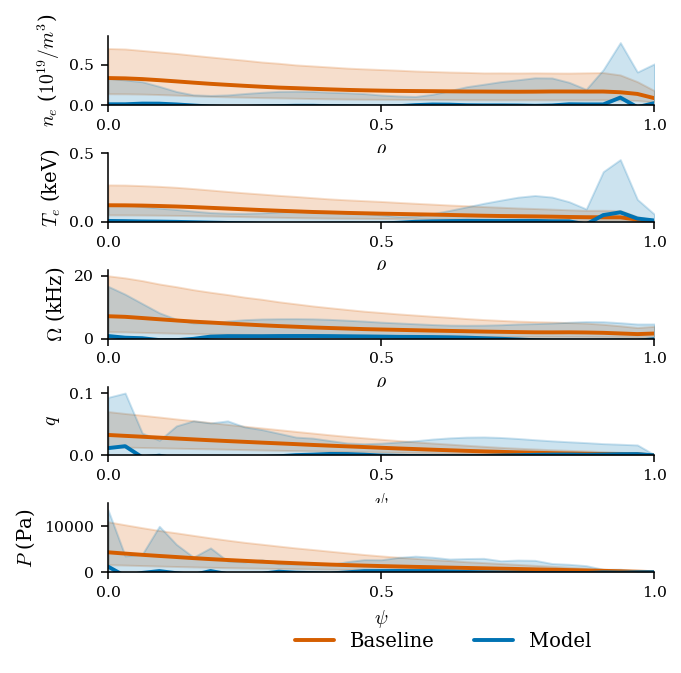

In [27]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [28]:
'''ridge alpha = 400'''
ridge_errs_400 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=400)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_400[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_400[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_400[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_400[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_400[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_400[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_400[profile])

Sum of errors for dens: 4.547473508864641e-13
Mean error: 1.0299920638612292e-18
Sum of abs errors for dens: 54675.64627753353
Mean abs error: 0.10949231866150305
Mean squared error: 0.02865412608741517

Sum of errors for temp: 3.907985046680551e-13
Mean error: 7.792703114739563e-19
Sum of abs errors for temp: 43530.211118859064
Mean abs error: 0.0871727006761891
Mean squared error: 0.018703289128484325

Sum of errors for rotation: -3.979039320256561e-13
Mean error: -2.439454888092385e-18
Sum of abs errors for rotation: 62039.48188158108
Mean abs error: 0.1242389835740055
Mean squared error: 0.04220389964174379

Sum of errors for q_EFIT01: 1.3358203432289883e-12
Mean error: 2.9815559743351372e-18
Sum of abs errors for q_EFIT01: 47835.75110015235
Mean abs error: 0.09579488601349008
Mean squared error: 0.018111610054250604

Sum of errors for press_EFIT01: -1.1368683772161603e-13
Mean error: -5.421010862427522e-19
Sum of abs errors for press_EFIT01: 50202.72582114033
Mean abs error: 0.100

In [29]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_400[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_400[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_400[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

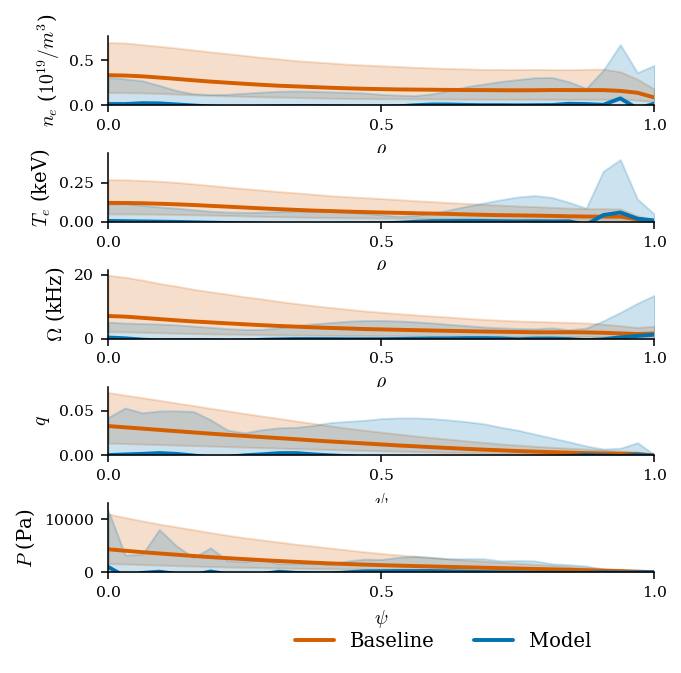

In [30]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [31]:
'''ridge alpha = 500'''
ridge_errs_500 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=500)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_500[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_500[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_500[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_500[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_500[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_500[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_500[profile])

Sum of errors for dens: 2.8421709430404007e-13
Mean error: 5.421010862427522e-19
Sum of abs errors for dens: 51949.53672341446
Mean abs error: 0.1040330680384624
Mean squared error: 0.026163087266611384

Sum of errors for temp: 4.192202140984591e-13
Mean error: 3.7269449679189215e-19
Sum of abs errors for temp: 40726.260632520134
Mean abs error: 0.08155756741186676
Mean squared error: 0.01626159168289103

Sum of errors for rotation: -5.684341886080801e-13
Mean error: -2.222614453595284e-18
Sum of abs errors for rotation: 59687.27344682828
Mean abs error: 0.11952849960114274
Mean squared error: 0.039706162393230625

Sum of errors for q_EFIT01: 1.5063505998114124e-12
Mean error: 2.4665599424045226e-18
Sum of abs errors for q_EFIT01: 43454.4934489535
Mean abs error: 0.08702107003611351
Mean squared error: 0.015318296401137523

Sum of errors for press_EFIT01: -4.547473508864641e-13
Mean error: 3.2526065174565133e-19
Sum of abs errors for press_EFIT01: 45562.46680066589
Mean abs error: 0.09

In [38]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_500[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_500[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_500[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

In [24]:
def plot_ridge():
    labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
    profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
    psi = np.linspace(0,1,33)
    # profiles = ['dens','temp','rotation','q','itemp']
    # labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


    fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
    for i, sig in enumerate(profiles):

        ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
        ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
        ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
        ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

        ax[i].set_ylim(0,None)
        ax[i].set_ylabel(labels[i],size=labelsize)
        ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
    #     if i==2:
    #         ax[i].legend(fontsize=labelsize)
        ax[i].set_xticks([0,.5,1])
        ax[i].set_xlim(0,1)
        if i in [0,1,2]:
            ax[i].set_xlabel('$\\rho$',size=labelsize)
        if i in [3,4]:
            ax[i].set_xlabel('$\psi$',size=labelsize)

    # ax[4].set_yticks([0,10000])
    # ax[4].set_yticklabels(['0',r'$10^4$'])
    plt.subplots_adjust(hspace=0.7, bottom=0.12)
    fig.legend(handles=ax[0].lines,     
               labels=[line._label for line in ax[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.06),
               frameon=False,
               mode=None,
               ncol=2,
              fontsize=labelsize)

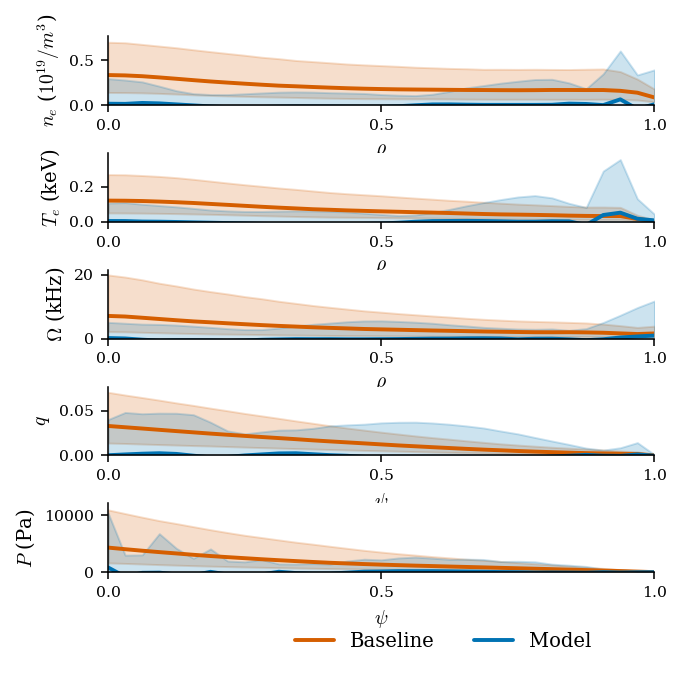

In [40]:
plot_ridge()

In [51]:
'''ridge alpha = 600'''

ridge_errs_600 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=600)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_600[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_600[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_600[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_600[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_600[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_600[profiles[i]])/(33*15132))))
    print("")

coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_600[profile])

Sum of errors for dens: 8.952838470577262e-13
Mean error: 1.599198204416119e-18
Sum of abs errors for dens: 49877.27607588844
Mean abs error: 0.09988320171558654
Mean squared error: 0.02442048554784012

Sum of errors for temp: 9.130474154517287e-13
Mean error: 1.0706496453294356e-18
Sum of abs errors for temp: 38602.64184026131
Mean abs error: 0.07730485233032407
Mean squared error: 0.014553699201622045

Sum of errors for q_EFIT01: -1.4210854715202004e-12
Mean error: -2.222614453595284e-18
Sum of abs errors for q_EFIT01: 36909.89352341828
Mean abs error: 0.07391498955338133
Mean squared error: 0.012974214965184831

Sum of errors for rotation: 1.4210854715202004e-12
Mean error: 4.296151108473811e-18
Sum of abs errors for rotation: 56829.76759131793
Mean abs error: 0.11380611746192681
Mean squared error: 0.038282432500279046

Sum of errors for press_EFIT01: -1.7053025658242404e-13
Mean error: -4.87890977618477e-19
Sum of abs errors for press_EFIT01: 42249.84740107633
Mean abs error: 0.08

In [57]:
print(type(model_err))
print(len(model_err['dens']))
print(len(model_err['dens'][0]))
print(len(ridge_errs_600['dens']))
print(len(ridge_errs_600['dens'][0]))

<class 'dict'>
15132
33
15132
33


In [25]:
def prep_plot(errs):
    hi_per = 75
    low_per = 25

    baseline_err = {sig: np.abs(model_err[sig]) for sig in scenario['target_profile_names']}

    med_model_err = {sig:np.median(errs[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
    med_baseline_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
    #print(med_baseline_err)

    med_model_hiper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
    med_baseline_hiper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

    med_model_lowper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
    med_baseline_lowper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

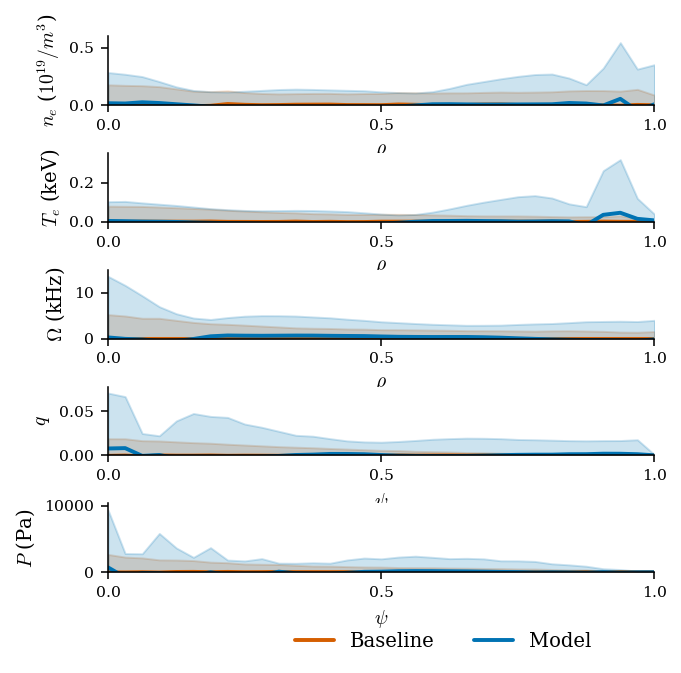

In [69]:
#prep_plot(ridge_errs_600)
'''with model_err as baseline'''
hi_per = 75
low_per = 25
errs=ridge_errs_600

baseline_err = {sig: np.abs(model_err[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(errs[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
#print(med_baseline_err)

med_model_hiper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

plot_ridge()

In [46]:
'''ridge alpha = 700'''

ridge_errs_700 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=700)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_700[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_700[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_700[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_700[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_700[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_700[profiles[i]])/(33*15132))))
    print("")

coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_700[profile])

Sum of errors for dens: 8.668621376273222e-13
Mean error: 5.963111948670274e-19
Sum of abs errors for dens: 48254.29607357763
Mean abs error: 0.09663305552266843
Mean squared error: 0.023148521128898553

Sum of errors for temp: 1.5987211554602254e-13
Mean error: 4.811147140404426e-19
Sum of abs errors for temp: 36938.92367121745
Mean abs error: 0.07397312472708338
Mean squared error: 0.013306776225986031

Sum of errors for rotation: -1.1937117960769683e-12
Mean error: -2.710505431213761e-19
Sum of abs errors for rotation: 56308.91311120762
Mean abs error: 0.1127630650501999
Mean squared error: 0.036656640494014195

Sum of errors for q_EFIT01: 1.6484591469634324e-12
Mean error: 2.574980159653073e-18
Sum of abs errors for q_EFIT01: 37448.06479001333
Mean abs error: 0.0749927202036489
Mean squared error: 0.011950584245638524

Sum of errors for press_EFIT01: 3.126388037344441e-13
Mean error: 5.421010862427522e-20
Sum of abs errors for press_EFIT01: 39780.55443461567
Mean abs error: 0.07966

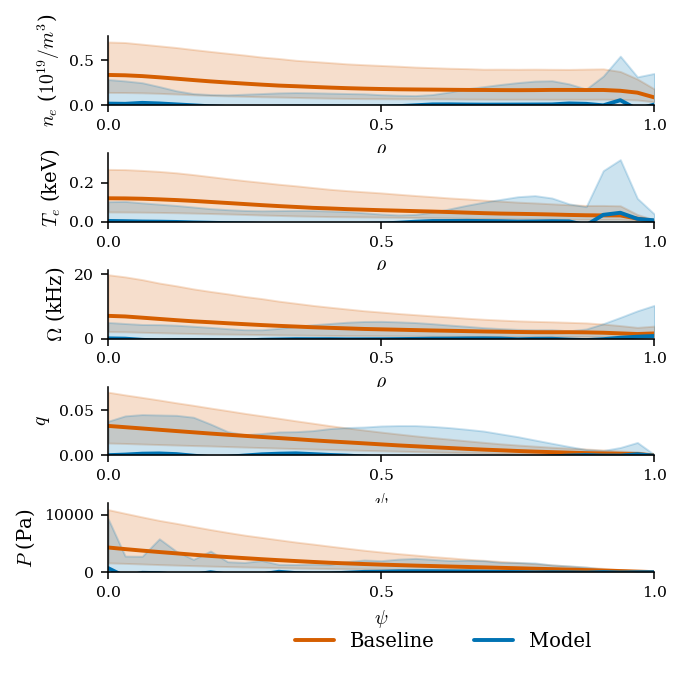

In [47]:
prep_plot(ridge_errs_700)
plot_ridge()

In [48]:
'''ridge alpha = 800'''

ridge_errs_800 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=800)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_800[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_800[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_800[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_800[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_800[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_800[profiles[i]])/(33*15132))))
    print("")

coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_800[profile])

Sum of errors for dens: 7.105427357601002e-13
Mean error: 1.4094628242311558e-18
Sum of abs errors for dens: 46951.14850760226
Mean abs error: 0.09402339915331397
Mean squared error: 0.02218812694330559

Sum of errors for temp: 4.192202140984591e-13
Mean error: 3.5914196963582334e-19
Sum of abs errors for temp: 35601.30592613886
Mean abs error: 0.0712944390898254
Mean squared error: 0.012364772114524313

Sum of errors for rotation: -3.410605131648481e-13
Mean error: -8.673617379884035e-19
Sum of abs errors for rotation: 55048.50137864205
Mean abs error: 0.11023899057714745
Mean squared error: 0.035672375358024346

Sum of errors for q_EFIT01: 1.3500311979441904e-12
Mean error: 2.4665599424045226e-18
Sum of abs errors for q_EFIT01: 35302.01267560587
Mean abs error: 0.07069508061504393
Mean squared error: 0.010876442818690277

Sum of errors for press_EFIT01: 5.115907697472721e-13
Mean error: -7.589415207398531e-19
Sum of abs errors for press_EFIT01: 37879.34185339439
Mean abs error: 0.075

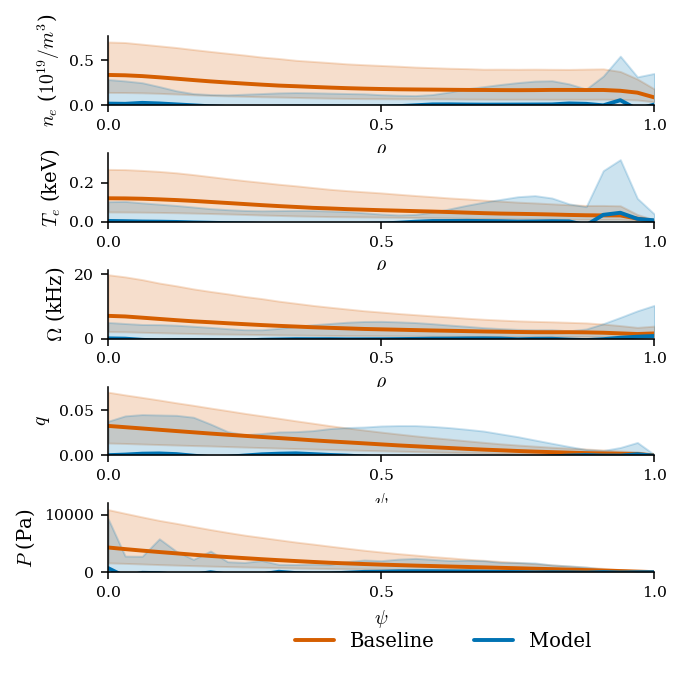

In [49]:
prep_plot(ridge_errs_800)
plot_ridge()

In [50]:
'''ridge alpha = 900'''

ridge_errs_900 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=900)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_900[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_900[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_900[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_900[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_900[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_900[profiles[i]])/(33*15132))))
    print("")

coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_900[profile])

Sum of errors for dens: 4.831690603168681e-13
Mean error: 9.215718466126788e-19
Sum of abs errors for dens: 45883.28926821069
Mean abs error: 0.09188492632152348
Mean squared error: 0.02144282623577544

Sum of errors for temp: 4.334310688136611e-13
Mean error: 6.979551485375435e-19
Sum of abs errors for temp: 34502.664432193385
Mean abs error: 0.06909432235157564
Mean squared error: 0.011633134563702862

Sum of errors for rotation: -4.263256414560601e-13
Mean error: -1.4094628242311558e-18
Sum of abs errors for rotation: 53981.53243838802
Mean abs error: 0.10810230064000038
Mean squared error: 0.03490107775741981

Sum of errors for q_EFIT01: 1.0444978215673473e-12
Mean error: 2.5614276324970042e-18
Sum of abs errors for q_EFIT01: 33530.04663991596
Mean abs error: 0.06714657807238915
Mean squared error: 0.010040315285291508

Sum of errors for press_EFIT01: -5.115907697472721e-13
Mean error: -1.6263032587282567e-19
Sum of abs errors for press_EFIT01: 36375.901080442585
Mean abs error: 0.

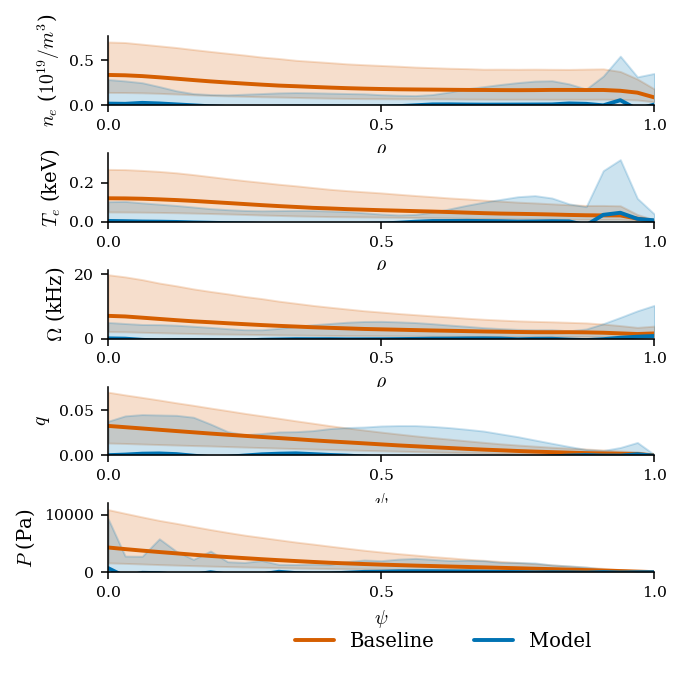

In [51]:
prep_plot(ridge_errs_900)
plot_ridge()

In [19]:
'''ridge alpha = 1000'''

ridge_errs_1000 = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=1000)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs_1000[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_1000[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_1000[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_1000[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_1000[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_1000[profiles[i]])/(33*15132))))
    print("")

coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_1000[profile])

Sum of errors for dens: 5.115907697472721e-13
Mean error: 1.4094628242311558e-18
Sum of abs errors for dens: 44994.05113163873
Mean abs error: 0.0901041564167422
Mean squared error: 0.02085122586679847

Sum of errors for temp: 4.192202140984591e-13
Mean error: 7.453889935837843e-19
Sum of abs errors for temp: 33583.353360927285
Mean abs error: 0.06725332900961896
Mean squared error: 0.011051748717318533

Sum of errors for q_EFIT01: -1.1937117960769683e-12
Mean error: -1.8973538018496328e-18
Sum of abs errors for q_EFIT01: 30550.610118800698
Mean abs error: 0.06118002010349472
Mean squared error: 0.009297146297947957

Sum of errors for rotation: 5.542233338928781e-13
Mean error: 8.131516293641283e-19
Sum of abs errors for rotation: 50834.45877169137
Mean abs error: 0.10180003598973755
Mean squared error: 0.03435167522328064

Sum of errors for press_EFIT01: -2.8421709430404007e-13
Mean error: -4.336808689942018e-19
Sum of abs errors for press_EFIT01: 35160.59850666599
Mean abs error: 0.0

In [21]:
def scalarize_median(arr, **kwargs):
    return np.median(arr,axis=-1)

def scalarize_iqr(arr, **kwargs):
    return np.percentile(arr,75,axis=-1) - np.percentile(arr,25,axis=-1)

def scalarize_mean(arr, **kwargs):
    return np.mean(arr,axis=-1)

def scalarize_std(arr, **kwargs):
    return np.std(arr,axis=-1)

def scalarize_pca_1(arr, **kwargs):
    fitter = kwargs.get('fitter')
    #print(type(fitter.transform(arr)))
    #print(np.shape(fitter.transform(arr)))
    ret = fitter.transform(arr).squeeze()[0] #[:,0]
    return ret

def scalarize_pca_2(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[1]
    return ret

def scalarize_pca_3(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[2]
    return ret

def scalarize_pca_4(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[3]
    return ret

def scalarize_pca_5(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[4]
    return ret

def scalarize_pca_6(arr, **kwargs):
    fitter = kwargs.get('fitter')
    ret = fitter.transform(arr).squeeze()[5]
    return ret

In [29]:
import sklearn
print(sklearn.__version__)

0.24.2


In [33]:
from sklearn import decomposition
from sklearn.decomposition import IncrementalPCA
with open(os.path.expanduser('/projects/EKOLEMEN/profile_predictor/full_pca_fitters.pkl'),'rb') as f:
    full_pca_fitter = pickle.load(f, encoding='latin1')
    #error bc trying to unpickle in a dif version than pickled the file in?

ModuleNotFoundError: No module named 'sklearn.decomposition.incremental_pca'

In [23]:
num_components=5
full_pca_fitters = {}
#delta_pca_fitters = {}

for profile in profiles:
    full = np.array([train_generator[i][0]['input_' + profile] for i in range(len(train_generator))]).squeeze()
    #delta = np.array([train_generator[i][1]['target_' + profile] for i in range(len(train_generator))]).squeeze()
    #print(profile, ' made arrays')
    full_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')

dens  done full
temp  done full
q_EFIT01  done full
rotation  done full
press_EFIT01  done full


In [24]:
scalarize_functions=[scalarize_mean, scalarize_pca_1,scalarize_pca_2]
scalarize_function_names=['mean','pca 1','pca 2']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
# profiles = ['dens','temp','rotation','q','itemp']

num_samples = len(traindatafull['time'])
all_true_delta=np.zeros((len(scalarize_functions),len(profiles),num_samples))
all_predicted_delta=np.zeros((len(scalarize_functions),len(profiles),num_samples))

for j,profile in enumerate(profiles):
    for k in range(num_samples):
        target = baseline[profile][k][np.newaxis,:]
        #print(target)
        #print(np.shape(target))
        pred = ridge_errs_1000[profile][k][np.newaxis,:] + baseline[profile][k][np.newaxis,:]
        for i,scalarize in enumerate(scalarize_functions):
            all_true_delta[i][j][k]=scalarize(target, fitter=full_pca_fitter[profile])
            all_predicted_delta[i][j][k]=scalarize(pred, fitter=full_pca_fitter[profile])

NameError: name 'full_pca_fitter' is not defined

In [ ]:
def find_bounds(true,pred,percentile=90):
    arr = np.concatenate([true,pred]).flatten()
  
    true_bounds=(np.percentile(true, 50-percentile/2),np.percentile(true, 50+percentile/2))
    pred_bounds=(np.percentile(pred, 50-percentile/2),np.percentile(pred, 50+percentile/2))
#     bounds=(mean-3*std,mean+3*std)
    return (np.maximum(true_bounds[0],pred_bounds[0]),np.minimum(true_bounds[1],pred_bounds[1]))


In [ ]:
"""Scatter plot of deltas"""

labels = ['$n_e$','$T_e$','$\Omega$','$q$','$P$']
units = ['($10^{19}/m^3$)','(keV)','(kHz)','','(Pa)']
titles = ['Mean','PCA Mode 1', 'PCA Mode 2']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
scalarize_function_names=['mean','pca 1','pca 2']
ylabels = ['$n_e$','$T_e$','$\Omega$','$q$','$P$']

# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']

fig, axes = plt.subplots(len(profiles),len(scalarize_function_names), figsize=(10,10))

for i,profile in enumerate(profiles):
    for j,name in enumerate(titles):

        pred=copy.deepcopy(all_predicted_delta[j][i])
        true=copy.deepcopy(all_true_delta[j][i])
      
        ax = axes[i,j]
        if name in ['Mean','Std. Dev.']:
            pred *= scenario['normalization_dict'][profile]['iqr']
            true *= scenario['normalization_dict'][profile]['iqr']
        bounds = find_bounds(true,pred,95)
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)
        
        r2_model = r2_score(true,pred)
        r2_baseline = r2_score(true, np.zeros(true.shape))
        
        hb = ax.hexbin(true,pred,gridsize=100,bins='log',mincnt=0,cmap='Blues')
        ax.text(0., 1., '$R^2=${:.2f}'.format(r2_model), fontsize=labelsize, horizontalalignment='left',verticalalignment='top', 
                transform=ax.transAxes,bbox=dict(facecolor='blue', alpha=0.5))
        ax.text(0., 0., '$R^2=${:.2f}'.format(r2_baseline), fontsize=labelsize, horizontalalignment='left',verticalalignment='bottom', 
                transform=ax.transAxes,bbox=dict(facecolor='red', alpha=0.5)) 
        
        x_45 = np.linspace(*ax.get_xlim())
        ax.plot(x_45, x_45,color='k', linestyle=':',label='Prediction = True')
        ax.axhline(0,color=colorblind_colors[1],label='Baseline')
        if i==0:
            ax.set_title(name, size=labelsize)
        if i==len(profiles)-1:
            ax.set_xlabel('True',size=labelsize)
        if j in [0]:
            ax.set_ylabel(labels[i] + ' ' + units[i] + '\n Prediction', size=labelsize)
        if j in [1,2,3]:
            if ylabels[i] == '$q$':
                ax.set_ylabel(labels[i] + ' \n Prediction', size=labelsize)
            else:
                ax.set_ylabel(labels[i] + ' (unitless) \n Prediction', size=labelsize)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)

# axes[4,0].set_yticks([0,20000])
# axes[4,0].set_yticklabels(['0',r'2$\times 10^4$'])
# axes[4,0].set_xticks([0,20000])
# axes[4,0].set_xticklabels(['0',r'2$\times 10^4$'])
plt.subplots_adjust(hspace=0.4,wspace=1.6,bottom=0.18)
cbar_ax = fig.add_axes([0.05, 0.05, 0.8, 0.02])
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cb.set_label('counts', size=labelsize)
cb.ax.tick_params(labelsize=ticksize)
fig.legend(handles=axes[0,0].lines,     
           labels=[line._label for line in axes[0,0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.14),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=labelsize)
# fig.savefig('all_pca_acc.pdf',bbox_inches='tight',pad_inches=0.1)
# fig.savefig('all_pca_acc.png',bbox_inches='tight',pad_inches=0.1)

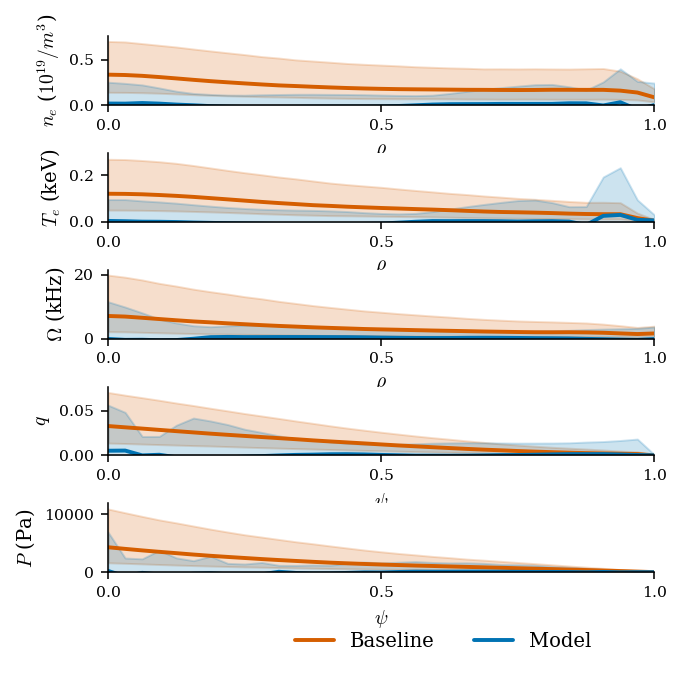

In [28]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
plot_ridge()

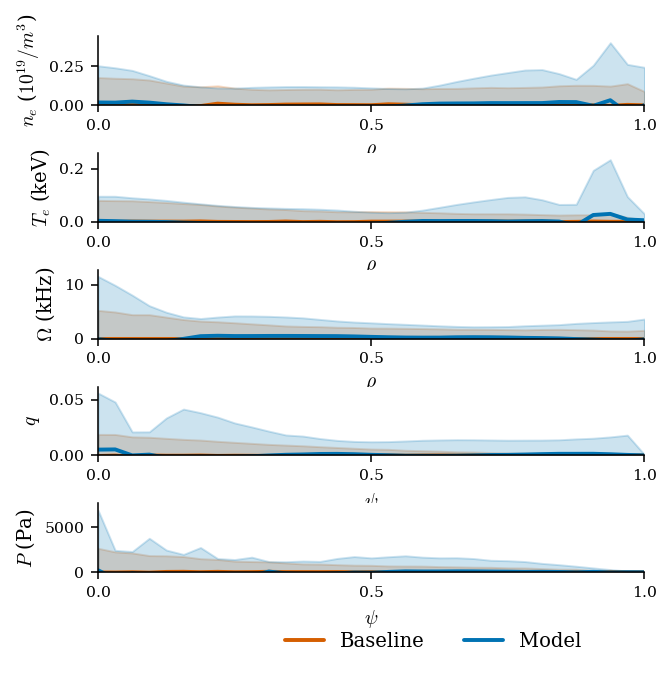

In [29]:
hi_per = 75
low_per = 25
errs=ridge_errs_1000

baseline_err = {sig: np.abs(model_err[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(errs[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
#print(med_baseline_err)

med_model_hiper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(errs[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

plot_ridge()

In [26]:
'''ridge alpha = 1000 w/cross validation'''
from sklearn.model_selection import train_test_split

ridge_errs_1000_val = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1

#get random rows that total apx 80% of data
#res_og_train = res_og[np.random.choice(15132, 12106, replace=False),:]
#res_og_test = res_og.pop(res_og_train)
res_og_train, res_og_test, res_err_train, res_err_test = train_test_split(res_og, res_err, test_size=0.2, random_state=0)
#dummy_train, dummy_test, dummy_train_2, model_err_test = train_test_split(res_og, model_err['dens'], test_size=0.2, random_state=0)
#print(res_og_train)
#print(dummy_train)

ridge2 = linear_model.Ridge(alpha=1000)
ridge2.fit(res_og_train, res_err_train)
lin_err_ridge = res_og_test @ ridge2.coef_
for i in range(5):
    dummy_train, dummy_test, dummy_train_2, model_err_test = train_test_split(res_og, model_err[profiles[i]], test_size=0.2, random_state=0)                                                                                       
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    #print(len(correction_ridge))
    #print(len(correction_ridge[0]))
    ridge_errs_1000_val[profiles[i]] = model_err_test - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs_1000_val[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs_1000_val[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs_1000_val[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs_1000_val[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs_1000_val[profiles[i]])/(33*15132))))
    print("")

coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs_1000_val[profile])

Sum of errors for dens: 234.8597334899294
Mean error: 0.00047032524589657356
Sum of abs errors for dens: 8836.442358944216
Mean abs error: 0.01769567674954184
Mean squared error: 0.0037806060412211694

Sum of errors for temp: 168.21297704225975
Mean error: 0.0003368598295449734
Sum of abs errors for temp: 6403.219400180872
Mean abs error: 0.012822954766100481
Mean squared error: 0.001926215663662558

Sum of errors for q_EFIT01: 1.6367351338348985
Mean error: 3.2776919348819253e-06
Sum of abs errors for q_EFIT01: 6145.627209839679
Mean abs error: 0.012307105972171516
Mean squared error: 0.0018894498827072286

Sum of errors for rotation: 231.6850902274897
Mean error: 0.000463967770943955
Sum of abs errors for rotation: 9952.649936764414
Mean abs error: 0.019930970964130632
Mean squared error: 0.008517750914420894

Sum of errors for press_EFIT01: 156.58892608805283
Mean error: 0.0003135817454642635
Sum of abs errors for press_EFIT01: 6808.270413215165
Mean abs error: 0.013634101549225732


In [38]:
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(baseline[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_model_err_val = {sig:np.median(ridge_errs_1000_val[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_model_hiper_val = {sig:np.percentile(ridge_errs_1000_val[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_model_lowper_val = {sig:np.percentile(ridge_errs_1000_val[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

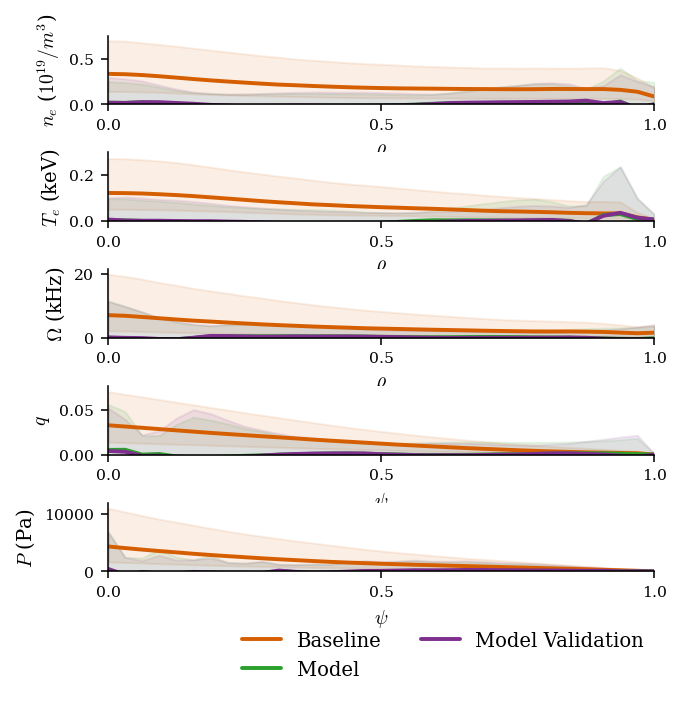

In [33]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.1)   
    ax[i].plot(psi,med_model_err[sig],c=matplotlib_colors[2],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=matplotlib_colors[2],alpha=0.1)    
    ax[i].plot(psi,med_model_err_val[sig],c=matlab_colors[3],label='Model Validation')
    ax[i].fill_between(psi,med_model_lowper_val[sig],med_model_hiper_val[sig],color=matlab_colors[3],alpha=0.1)    

    
    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [34]:
'''plot model and model val against model_err'''
hi_per = 75
low_per = 25

baseline_err = {sig: np.abs(model_err[sig]) for sig in scenario['target_profile_names']}

med_model_err = {sig:np.median(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_model_err_val = {sig:np.median(ridge_errs_1000_val[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
med_baseline_err = {sig:np.median(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}

med_model_hiper = {sig:np.percentile(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_model_hiper_val = {sig:np.percentile(ridge_errs_1000_val[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_hiper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],hi_per,axis=0) for sig in scenario['target_profile_names']}

med_model_lowper = {sig:np.percentile(ridge_errs_1000[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_model_lowper_val = {sig:np.percentile(ridge_errs_1000_val[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}
med_baseline_lowper = {sig:np.percentile(model_err[sig]*scenario['normalization_dict'][sig]['iqr'],low_per,axis=0) for sig in scenario['target_profile_names']}

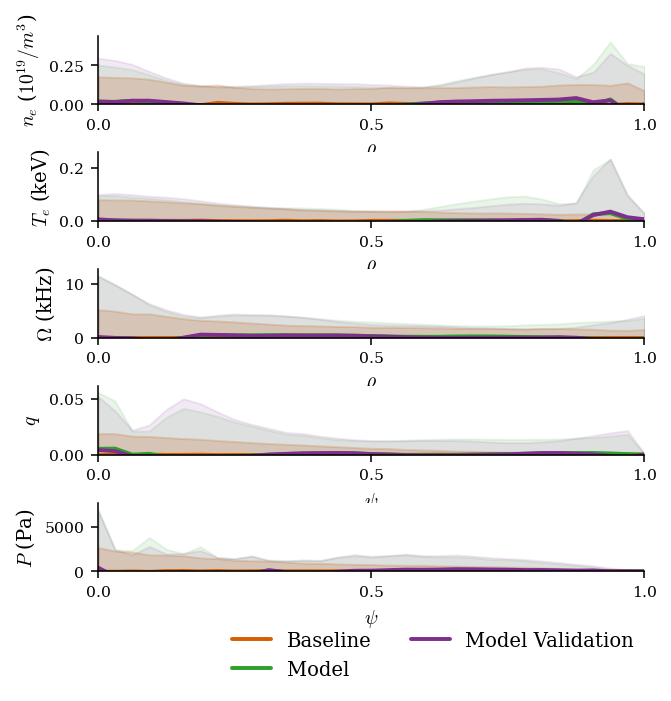

In [37]:
labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
psi = np.linspace(0,1,33)
# profiles = ['dens','temp','rotation','q','itemp']
# labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i, sig in enumerate(profiles):
    
    ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
    ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
    ax[i].plot(psi,med_model_err[sig],c=matplotlib_colors[2],label='Model')
    ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=matplotlib_colors[2],alpha=0.1)    
    ax[i].plot(psi,med_model_err_val[sig],c=matlab_colors[3],label='Model Validation')
    ax[i].fill_between(psi,med_model_lowper_val[sig],med_model_hiper_val[sig],color=matlab_colors[3],alpha=0.1)    

    
    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(labels[i],size=labelsize)
    ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
#     if i==2:
#         ax[i].legend(fontsize=labelsize)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    if i in [0,1,2]:
        ax[i].set_xlabel('$\\rho$',size=labelsize)
    if i in [3,4]:
        ax[i].set_xlabel('$\psi$',size=labelsize)

# ax[4].set_yticks([0,10000])
# ax[4].set_yticklabels(['0',r'$10^4$'])
plt.subplots_adjust(hspace=0.7, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
          fontsize=labelsize)

In [51]:
#ridge_dict = {}

def ridge_metrics(a):
    prof_ridge = {}
    ridge_errs = {}
    res_og = []
    res_err = []
    counter = 0
    for profile in profiles:
        if counter == 0:
            res_og = coeff_og[profile+""]
            res_err = coeff_err[profile+""]
        else:
            res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
            res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
        counter += 1
    # ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
    # ridge.fit(res_og, res_err)
    # print(ridge.alpha_)
    ridge2 = linear_model.Ridge(alpha=a)
    ridge2.fit(res_og, res_err)
    lin_err_ridge = res_og @ ridge2.coef_
    for i in range(5):
        correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
        ridge_errs[profiles[i]] = model_err[profiles[i]] - correction_ridge
        sum_of_errs = np.sum(ridge_errs[profiles[i]])
        mean_err = np.sum(ridge_errs[profiles[i]]/(33*15132))
        sum_of_abs_errs = np.sum(abs(ridge_errs[profiles[i]]))
        mean_abs_err = np.sum(abs(ridge_errs[profiles[i]]/(33*15132)))
        mse = np.sum(np.square(ridge_errs[profiles[i]])/(33*15132))
        #deviations = [(x-mean_err)**2 for x in ridge_errs[profiles[i]]]
        #variance = sum(deviations)/(33*15132)
        variance = np.var(ridge_errs[profiles[i]])
        prof_ridge[profiles[i]] = [sum_of_errs, mean_err, sum_of_abs_errs, mean_abs_err, mse, variance]
    #ridge_dict[a] = prof_ridge
    return prof_ridge

#     coeff_err_ridge = {}
#     for profile in profiles:
#         coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs[profile])

In [45]:
arr = [1]
arr.append(2)
print(arr)

[1, 2]


In [52]:
alphas = []
ridge_dict = {}
mean_err = []
mean_abs_err = []
mse = []
variance = []
counter = 0
for a in range(50, 1001, 50):
    ridge_dict[a] = ridge_metrics(a)
    #print(metrics)
    alphas.append(a)
#print(ridge_dict)
for i in range(5):
    for j in range(50,1001,50):
        mean_err.append((ridge_dict.get(j)).get(profiles[i])[1])
        mean_abs_err.append((ridge_dict.get(j)).get(profiles[i])[3])
        mse.append((ridge_dict.get(j)).get(profiles[i])[4])
        variance.append((ridge_dict.get(j)).get(profiles[i])[5])
    #print(mean_err)
print(len(alphas))
#print(mean_err)
print(type(mean_err))

20
<class 'list'>


In [53]:
model_metrics = {}
for i in range(5):
    sum_of_errs_og = np.sum(model_err[profiles[i]])
    mean_err_og = sum_of_errs_og/(33*15132)
    sum_of_abs_errs_og = np.sum(abs(model_err[profiles[i]]))
    mean_abs_err_og = sum_of_abs_errs_og/(33*15132)
    mse_og = np.sum(np.square(model_err[profiles[i]])/(33*15132))
    variance_og = np.var(model_err[profiles[i]])
    model_metrics[profiles[i]] = [mean_err_og, mean_abs_err_og, mse_og, variance_og]
    print(np.zeros((1,20)) + mean_err_og)

[[0.00146215 0.00146215 0.00146215 0.00146215 0.00146215 0.00146215
  0.00146215 0.00146215 0.00146215 0.00146215 0.00146215 0.00146215
  0.00146215 0.00146215 0.00146215 0.00146215 0.00146215 0.00146215
  0.00146215 0.00146215]]
[[0.00223189 0.00223189 0.00223189 0.00223189 0.00223189 0.00223189
  0.00223189 0.00223189 0.00223189 0.00223189 0.00223189 0.00223189
  0.00223189 0.00223189 0.00223189 0.00223189 0.00223189 0.00223189
  0.00223189 0.00223189]]
[[0.00385234 0.00385234 0.00385234 0.00385234 0.00385234 0.00385234
  0.00385234 0.00385234 0.00385234 0.00385234 0.00385234 0.00385234
  0.00385234 0.00385234 0.00385234 0.00385234 0.00385234 0.00385234
  0.00385234 0.00385234]]
[[-0.00159171 -0.00159171 -0.00159171 -0.00159171 -0.00159171 -0.00159171
  -0.00159171 -0.00159171 -0.00159171 -0.00159171 -0.00159171 -0.00159171
  -0.00159171 -0.00159171 -0.00159171 -0.00159171 -0.00159171 -0.00159171
  -0.00159171 -0.00159171]]
[[0.00299512 0.00299512 0.00299512 0.00299512 0.00299512 0.0

In [50]:
print(profiles)
print(type(mean_err))
print(type(metrics))
#print(mean_err)
print(len(mean_err[0:21]))
print(metrics)
print(metrics.get(o))

['dens', 'temp', 'rotation', 'q_EFIT01', 'press_EFIT01']
<class 'numpy.float64'>
<class 'dict'>


IndexError: invalid index to scalar variable.

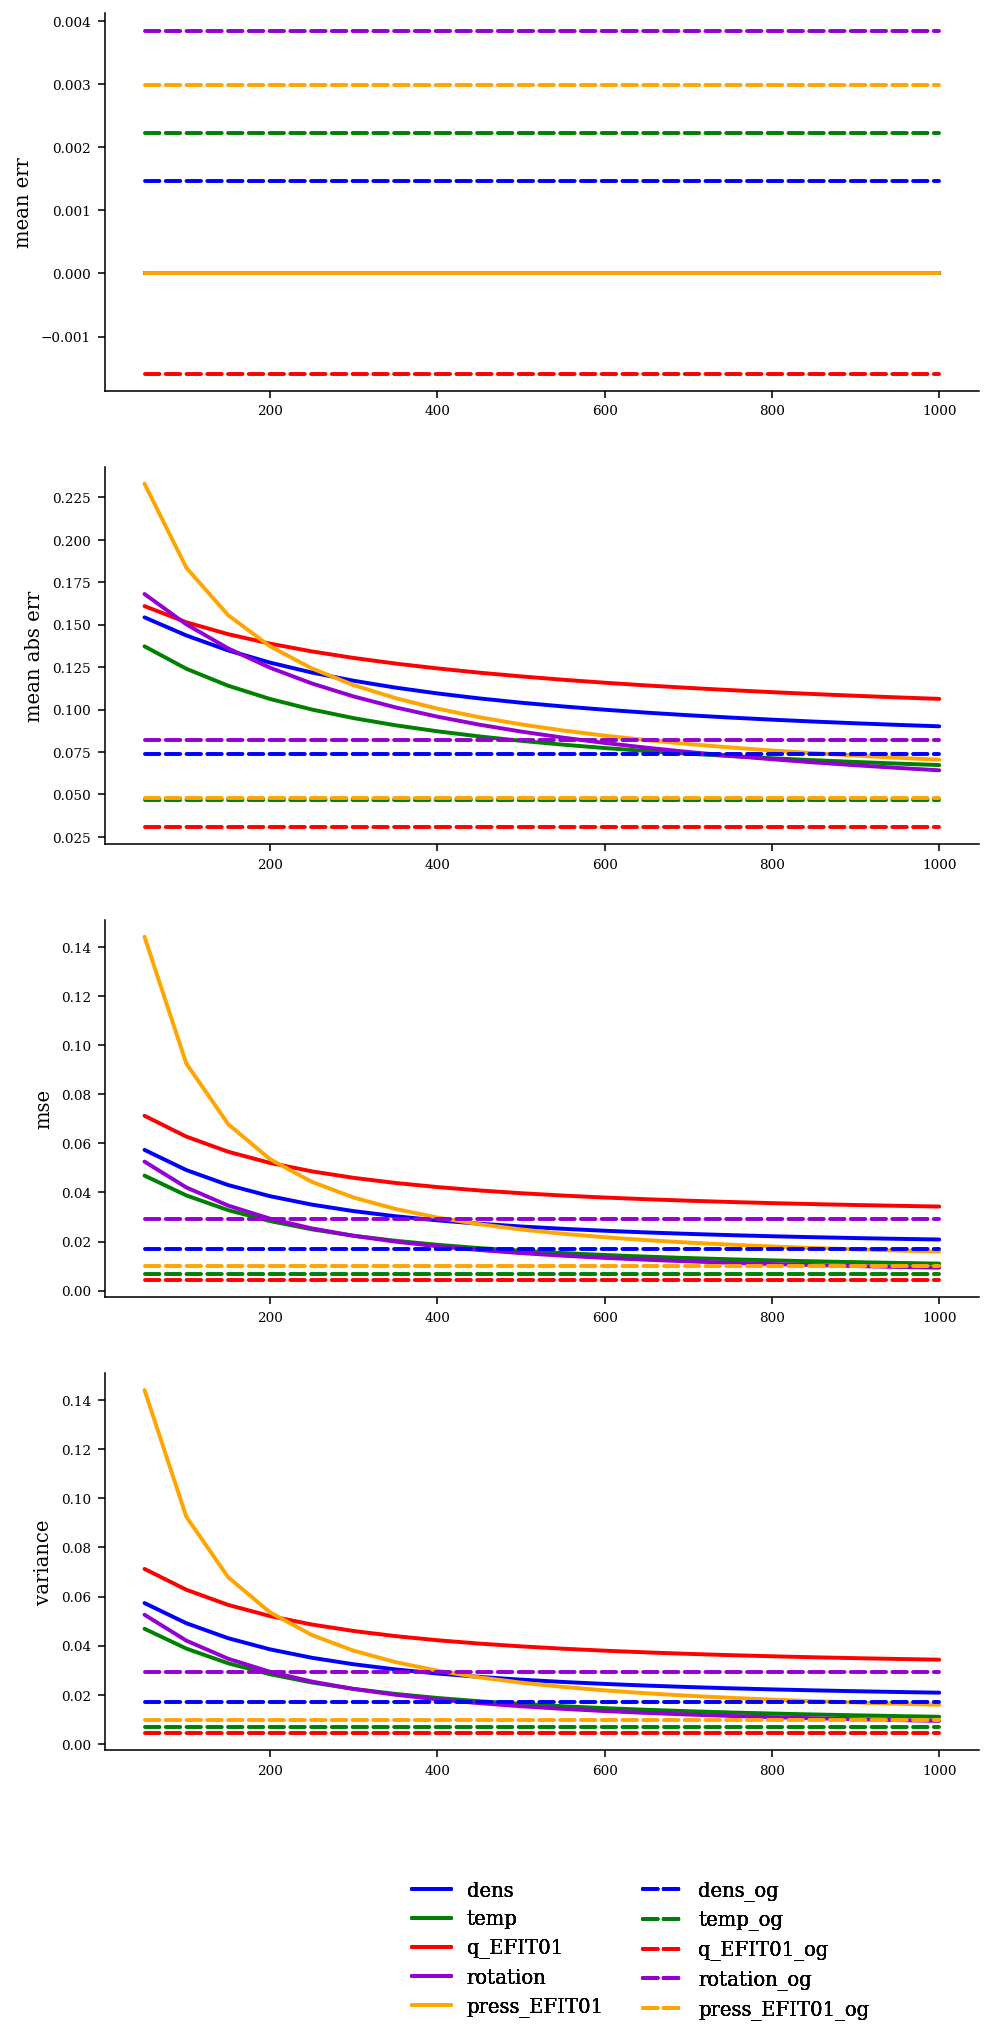

In [56]:
fig, ax = plt.subplots(4,1,figsize=(8,16))
metrics = {}
labels = ["mean err", "mean abs err", "mse", "variance"]
metrics[0] = mean_err
metrics[1] = mean_abs_err
metrics[2] = mse
metrics[3] = variance
for i in range(4):
    ax[i].plot(alphas, metrics.get(i)[0:20], label='dens', color='b')
    ax[i].plot(alphas, metrics.get(i)[20:40], label='temp', color='g')
    ax[i].plot(alphas, metrics.get(i)[40:60], label='q_EFIT01', color='r')
    ax[i].plot(alphas, metrics.get(i)[60:80], label='rotation', color='darkviolet')
    ax[i].plot(alphas, metrics.get(i)[80:100], label='press_EFIT01', color='orange')
    ax[i].plot(alphas, (model_metrics.get('dens')[i] + np.zeros((20,))), label='dens_og', color='b', linestyle='dashed')
    ax[i].plot(alphas, (model_metrics.get('temp')[i] + np.zeros((20,))), label='temp_og', color='g', linestyle='dashed')
    ax[i].plot(alphas, (model_metrics.get('q_EFIT01')[i] + np.zeros((20,))), label='q_EFIT01_og', color='r', linestyle='dashed')
    ax[i].plot(alphas, (model_metrics.get('rotation')[i] + np.zeros((20,))), label='rotation_og', color='darkviolet', linestyle='dashed')
    ax[i].plot(alphas, (model_metrics.get('press_EFIT01')[i] + np.zeros((20,))), label='press_EFIT01_og', color='orange', linestyle='dashed')
    ax[i].set_ylabel(labels[i],size=labelsize)
    fig.legend(handles=ax[0].lines,     
               labels=[line._label for line in ax[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.06),
               frameon=False,
               mode=None,
               ncol=2,
              fontsize=labelsize)

In [38]:
alphas = []
mean_err = {}
mean_abs_err = {}
mse = {}
variance = {}
counter = 0
for a in range(50, 1001, 50):
    metrics = ridge_metrics(a)
    #print(metrics)
    alphas.append(a)
    for i in range(5):
#         print(profiles[i])
#         print(type(profiles[i]))
        if mean_err.get(profiles[i]) is not None:
            #print('if statement')
            first = mean_err.get(profiles[i])
            #print(mean_err.get(profiles[i]))
            second = metrics.get(profiles[i])[1]
            #print(metrics.get(profiles[i])[1])
            mean_err[profiles[i]] = first.append(second)
            #print(mean_err.get(profiles[i]))
            mean_abs_err[profiles[i]] = mean_abs_err.get(profiles[i]).append(metrics.get(profiles[i])[3])
            mse[profiles[i]] = mse.get(profiles[i]).append(metrics.get(profiles[i])[4])
            variance[profiles[i]] = variance.get(profiles[i]).append(metrics.get(profiles[i])[5])
        else:
#             print('else statement')
#             print(mean_err.get(profiles[i]))
#             print(metrics.get(profiles[i])[1])
            mean_err[profiles[i]] = [metrics.get(profiles[i])[1]]
            mean_abs_err[profiles[i]] = [metrics.get(profiles[i])[3]]
            mse[profiles[i]] = [metrics.get(profiles[i])[4]]
            variance[profiles[i]] = [metrics.get(profiles[i])[5]]
    #counter += 1
    #print(mean_err)
            
# print(alphas)
# print(mean_err)

In [67]:
fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
for i in enumerate(profiles):
    ax[i].plot(alphas   
    ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model') 

[1.951563910473908e-18, 2.168404344971009e-18, 0.0, 5.421010862427522e-19, -3.2526065174565133e-19, 1.3010426069826053e-18, 0.0, -5.421010862427522e-19, 9.75781955236954e-19, 3.2526065174565133e-19, -3.2526065174565133e-19, 4.87890977618477e-19, -8.131516293641283e-19, 5.421010862427522e-20, 3.2526065174565133e-19, -7.589415207398531e-19, 5.421010862427522e-20, -1.6263032587282567e-19, -8.131516293641283e-19]


In [ ]:
def plot_ridge():
    labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$P$ (Pa)']
    profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']
    psi = np.linspace(0,1,33)
    # profiles = ['dens','temp','rotation','q','itemp']
    # labels = ['$n_e$ ($10^{19}/m^3$)','$T_e$ (keV)','$\Omega$ (kHz)','$q$','$T_i$ (keV)']


    fig, ax = plt.subplots(len(profiles),1,figsize=(5,5))
    for i, sig in enumerate(profiles):

        ax[i].plot(psi,med_baseline_err[sig],c=colorblind_colors[1],label='Baseline')
        ax[i].fill_between(psi,med_baseline_lowper[sig],med_baseline_hiper[sig],color=colorblind_colors[1],alpha=0.2)   
        ax[i].plot(psi,med_model_err[sig],c=colorblind_colors[0],label='Model')
        ax[i].fill_between(psi,med_model_lowper[sig],med_model_hiper[sig],color=colorblind_colors[0],alpha=0.2)    

        ax[i].set_ylim(0,None)
        ax[i].set_ylabel(labels[i],size=labelsize)
        ax[i].tick_params(axis='both', which='major', labelsize=ticksize)
    #     if i==2:
    #         ax[i].legend(fontsize=labelsize)
        ax[i].set_xticks([0,.5,1])
        ax[i].set_xlim(0,1)
        if i in [0,1,2]:
            ax[i].set_xlabel('$\\rho$',size=labelsize)
        if i in [3,4]:
            ax[i].set_xlabel('$\psi$',size=labelsize)

    # ax[4].set_yticks([0,10000])
    # ax[4].set_yticklabels(['0',r'$10^4$'])
    plt.subplots_adjust(hspace=0.7, bottom=0.12)
    fig.legend(handles=ax[0].lines,     
               labels=[line._label for line in ax[0].lines],  
               loc="upper center",
               bbox_to_anchor=(0.6, 0.06),
               frameon=False,
               mode=None,
               ncol=2,
              fontsize=labelsize)

In [55]:
for i in range(5):
    #correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    #ridge_errs[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(model_err[profiles[i]])))
    print("Mean error: " + str(np.sum(model_err[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(model_err[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(model_err[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(model_err[profiles[i]])/(33*15132))))
    print("")

Sum of errors for dens: 730.1309
Mean error: 0.001462144996505298
Sum of abs errors for dens: 36745.86
Mean abs error: 0.07358650051885318
Mean squared error: 0.016929190292540308

Sum of errors for temp: 1114.5079
Mean error: 0.0022318905180261314
Sum of abs errors for temp: 23256.01
Mean abs error: 0.04657199591079588
Mean squared error: 0.006876741145636396

Sum of errors for rotation: 1923.6868
Mean error: 0.003852335445756542
Sum of abs errors for rotation: 40884.176
Mean abs error: 0.08187379574393908
Mean squared error: 0.02936190906121204

Sum of errors for q_EFIT01: -794.831
Mean error: -0.0015917121014585695
Sum of abs errors for q_EFIT01: 15360.516
Mean abs error: 0.03076064721286484
Mean squared error: 0.004309523818250711

Sum of errors for press_EFIT01: 1495.6315
Mean error: 0.0029951207173669054
Sum of abs errors for press_EFIT01: 23917.283
Mean abs error: 0.04789625405600565
Mean squared error: 0.009897972403501038



In [37]:
'''Ridge CV alpha = 0.1'''
ridge_errs = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og = coeff_og[profile+""]
        res_err = coeff_err[profile+""]
    else:
        res_og = np.concatenate((res_og, coeff_og[profile+""]), axis=1)
        res_err = np.concatenate((res_err, coeff_err[profile+""]), axis=1)
    counter += 1
# ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
# ridge.fit(res_og, res_err)
# print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=0.1)
ridge2.fit(res_og, res_err)
lin_err_ridge = res_og @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs[profiles[i]]/(33*15132))))
    print("Sum of abs errors for " + profiles[i] + ": " +str(np.sum(abs(ridge_errs[profiles[i]]))))
    print("Mean abs error: " + str(np.sum(abs(ridge_errs[profiles[i]]/(33*15132)))))
    print("Mean squared error: " + str(np.sum(np.square(ridge_errs[profiles[i]])/(33*15132))))
    print("")
    
coeff_err_ridge = {}
for profile in profiles:
    coeff_err_ridge[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs[profile])

Sum of errors for dens: 9.947598300641403e-13
Mean error: 2.0599841277224584e-18
Sum of abs errors for dens: 82391.45486280933
Mean abs error: 0.1649954238315136
Mean squared error: 0.06726232651618354

Sum of errors for temp: 8.952838470577262e-13
Mean error: 2.4665599424045226e-18
Sum of abs errors for temp: 77804.12386960512
Mean abs error: 0.15580892964058732
Mean squared error: 0.056677653583852274

Sum of errors for q_EFIT01: -1.4779288903810084e-12
Mean error: -4.553649124439119e-18
Sum of abs errors for q_EFIT01: 84609.20906722556
Mean abs error: 0.16943665254292628
Mean squared error: 0.05846740616966518

Sum of errors for rotation: 2.6147972675971687e-12
Mean error: 5.421010862427522e-18
Sum of abs errors for rotation: 109995.39545936159
Mean abs error: 0.22027450448049413
Mean squared error: 0.09573459290747213

Sum of errors for press_EFIT01: 1.1368683772161603e-12
Mean error: 8.673617379884035e-19
Sum of abs errors for press_EFIT01: 179995.26763037947
Mean abs error: 0.360

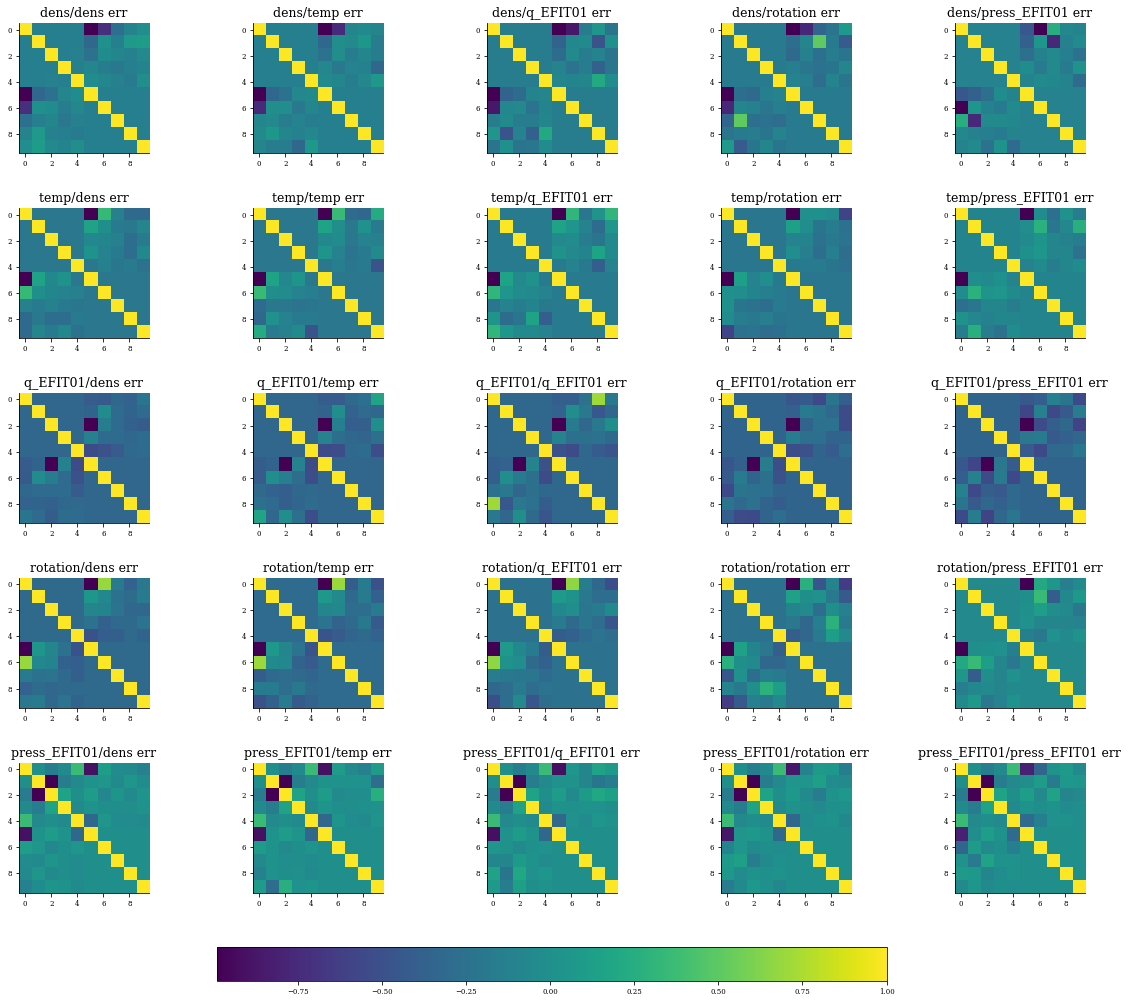

In [70]:
'''corrected error pca graphs (ridge)'''
fig_ridge = plt.figure(figsize=(20,20))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef_ridge = np.corrcoef(coeff_og[profile], coeff_err_ridge[profile2], rowvar=False)
        ax.append(fig_ridge.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=12.5)
        plt.imshow(corrcoef_ridge)
        counter += 1
plt.subplots_adjust(wspace=0.3, 
                    hspace=0.42)
plt.colorbar(ax=np.array(ax).ravel().tolist(), orientation='horizontal', shrink=0.6, pad=0.05)
plt.show()

In [35]:
'''Ridge CV, only 2 pca modes for pressure'''
ridge_errs = {}
res_og = []
res_err = []
counter = 0
for profile in profiles:
    if counter == 0:
        res_og_sliced = coeff_og_sliced[profile+""]
        res_err_sliced = coeff_err_sliced[profile+""]
    else:
        res_og_sliced = np.concatenate((res_og_sliced, coeff_og_sliced[profile+""]), axis=1)
        res_err_sliced = np.concatenate((res_err_sliced, coeff_err_sliced[profile+""]), axis=1)
    counter += 1
ridge = linear_model.RidgeCV(alphas = np.logspace(-2, 2, 10)) #10 alpha values from 1e-2 to 1e+2
ridge.fit(res_og_sliced, res_err_sliced)
print(ridge.alpha_)
ridge2 = linear_model.Ridge(alpha=ridge.alpha_)
ridge2.fit(res_og_sliced, res_err_sliced)
lin_err_ridge = res_og_sliced @ ridge2.coef_
for i in range(5):
    correction_ridge = full_pca_fitter_errs[profiles[i]].inverse_transform(lin_err_ridge[:, i:i+5])
    ridge_errs[profiles[i]] = model_err[profiles[i]] - correction_ridge
    print("Sum of errors for " + profiles[i] + ": " +str(np.sum(ridge_errs[profiles[i]])))
    print("Mean error: " + str(np.sum(ridge_errs[profiles[i]]/(33*15132))))
    
coeff_err_ridge_sliced = {}
for profile in profiles:
    coeff_err_ridge_sliced[profile+""] = decomposition.IncrementalPCA(n_components=5).fit_transform(ridge_errs[profile])

0.0774263682681127
Sum of errors for dens: 7.673861546209082e-13
Mean error: 4.336808689942018e-19
Sum of errors for temp: 1.7408297026122455e-12
Mean error: 3.0899761915836876e-18
Sum of errors for q_EFIT01: -1.7053025658242404e-12
Mean error: -3.0357660829594124e-18
Sum of errors for rotation: 2.4442670110147446e-12
Mean error: 4.662069341687669e-18
Sum of errors for press_EFIT01: 1.5916157281026244e-12
Mean error: 0.0


In [33]:
print(len(coeff_og['dens']))
print(len(coeff_og['dens'][0]))
print(len(model_err['dens']))
print(len(model_err['dens'][0]))
#print(model_err)

15132
5
15132
33


In [35]:
print(coeff_og)
print(len(coeff_og['dens']))
print(len(coeff_og['dens'][0]))

{'dens': array([[-5.05504863, -0.01602864,  0.19151845, -0.11074002, -0.13617393],
       [-4.80945025, -0.56139688,  0.2637393 , -0.18680306, -0.2163891 ],
       [-4.00971247, -0.83076795,  0.36781171, -0.20428207, -0.3373969 ],
       ...,
       [ 1.97432275, -0.66466976, -0.07572927,  0.63495619, -0.19870117],
       [-3.76743005, -0.03264926,  0.10052769,  0.10050197, -0.08201261],
       [-3.45929519,  0.29284818,  0.14931637,  0.04747562, -0.10111666]]), 'temp': array([[-2.30325830e+00,  3.74973624e-01, -1.51858834e-01,
         2.61477774e-02,  1.12132829e-02],
       [-2.08600334e+00, -6.05884447e-02, -4.44912812e-02,
        -9.32172945e-02, -1.76986790e-02],
       [-1.75590744e+00, -2.61117258e-01, -4.35576047e-02,
        -1.12252313e-01, -2.17907209e-02],
       ...,
       [-2.58665081e+00,  1.71786034e-01, -1.17570639e-01,
         5.55792738e-02,  7.68420854e-03],
       [-1.26343814e+00,  7.20612140e-01,  8.48991206e-02,
        -7.07026621e-02,  3.20576459e-02],
   

In [39]:
print(type(dataset))
print(len(dataset))
print(len(dataset[0]))
print(len(dataset_tar))
print(len(dataset_tar[0]))
print(dataset)
print(dataset[0])

<class 'numpy.ndarray'>
75660
5
75660
33
[[-5.05504863e+00 -1.60286390e-02  1.91518449e-01 -1.10740016e-01
  -1.36173928e-01]
 [-4.80945025e+00 -5.61396878e-01  2.63739304e-01 -1.86803064e-01
  -2.16389102e-01]
 [-4.00971247e+00 -8.30767953e-01  3.67811709e-01 -2.04282072e-01
  -3.37396900e-01]
 ...
 [-1.63076218e+00  2.39560752e-01 -9.42917264e-08 -9.06806374e-08
   1.04240140e-08]
 [-2.93174513e+00  2.78454012e-01 -1.02148524e-07  3.09779681e-08
  -7.52145233e-08]
 [-8.95398979e-01  7.37327025e-01 -3.25655681e-07  4.80873203e-08
   3.33363920e-08]]
[-5.05504863 -0.01602864  0.19151845 -0.11074002 -0.13617393]


In [20]:
test_results = {}
test_results_ridge = {}
test_results_reshape = {}
test_results_ridge_reshape = {}
test_results_pca = {}
test_results_ridge_pca = {}
test_results_reshape_pca = {}
test_results_ridge_reshape_pca = {}

In [21]:
'DNN using full profiles to predict model errs'
dataset = []
counter = 0
    
for profile in profiles:
    if counter == 0:
        dataset = full_profiles[profile+""]
    else:
        dataset = np.concatenate((dataset, full_profiles[profile+""]), axis=1)
    counter +=1
    
for profile in profiles:
    dataset = np.concatenate((dataset, np.abs(model_err[profile+""])), axis=1)

ds = pd.DataFrame(dataset)
#print(ds)

train_dataset = ds.sample(frac=0.9, random_state=0)
test_dataset = ds.drop(train_dataset.index)

train_features = train_dataset.copy()
#print(train_features)
#print(type(train_features))
test_features = test_dataset.copy()

#normalizer = preprocessing.Normalization(axis=-1)
#normalizer.adapt(train_features.to_numpy())

In [22]:
'''DNN'''
import tensorflow as tf
import pickle
import tensorflow.keras as keras
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.layers.experimental import preprocessing

def custom_loss_function(y_actual, y_predicted):
    err = y_actual-y_predicted
    is_neg_err = tf.abs(err) < 0
    neg_err_loss = 0.1 * err**2
    pos_err_loss = err**2

    return tf.where(is_neg_err, neg_err_loss, pos_err_loss)

  #model.compile(loss='mean_absolute_error',
                #optimizer=tf.keras.optimizers.Adam(0.001))
#custom_loss = custom_loss_function()

def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [76]:
a1 = np.array([[1, 2, 3], [1,1,1]])
a2 = np.array([[4,5,6],[2,2,2]])
np.concatenate((a1,a2), axis = None)
a3 = np.array([2,3,4])
a4 = [5,6,7]
a5 = np.array([1,2,3])
a6 = [4,5,6]
arr = np.append(a3, a4)
print(np.append(a3, a4))
print(arr[0:3])
print(arr[3:])
print(np.append(a5, a6))
a = np.array([[1, 2],[3,4]])
b = np.array([[5, 6],[7,8]])
print(a)
np.concatenate((a,b), axis=1)

'''full profs, no ridge'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

[2 3 4 5 6 7]
[2 3 4]
[5 6 7]
[1 2 3 4 5 6]
[[1 2]
 [3 4]]


array([[1, 2, 5, 6],
       [3, 4, 7, 8]])

In [23]:
#dnn_err_model = build_and_compile_model(normalizer)
dnn_err_model = build_and_compile_model()
dnn_err_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 165)               0         
_________________________________________________________________
dense (Dense)                (None, 165)               27390     
_________________________________________________________________
dense_1 (Dense)              (None, 330)               54780     
_________________________________________________________________
dense_2 (Dense)              (None, 165)               54615     
Total params: 136,785
Trainable params: 136,785
Non-trainable params: 0
_________________________________________________________________


In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [25]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

In [30]:
# err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
#                               train_features.to_numpy()[:, 165:], 
#                               validation_split=0.2, 
#                               verbose=0, 
#                               epochs=100)

In [52]:
'''plot on log scale'''
def plot_loss(fitted_model):
  plt.plot(fitted_model.history['loss'], label='loss')
  plt.plot(fitted_model.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.02])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

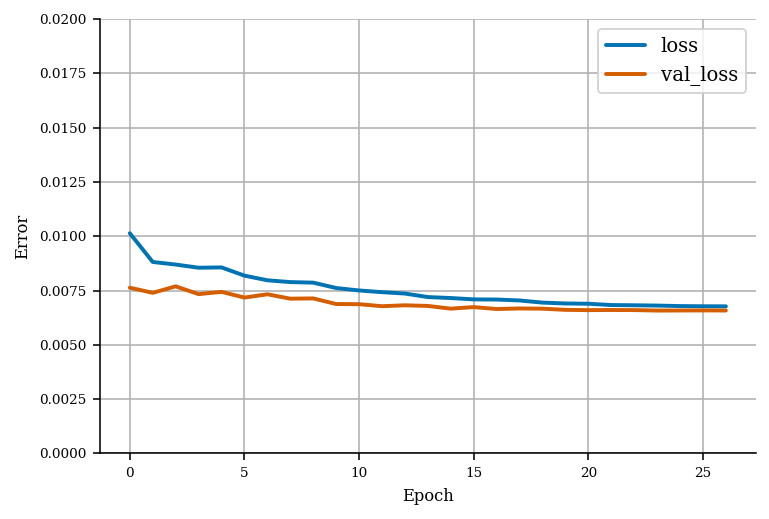

In [53]:
plot_loss(err_model)

In [26]:
test_results['165.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

In [27]:
pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                 0.006445

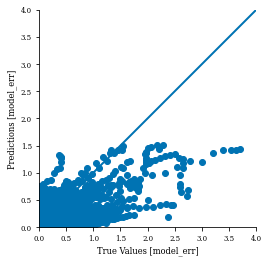

In [42]:
test_predictions = dnn_err_model.predict(test_features.to_numpy()[:, 0:165])

a = plt.axes(aspect='equal')
plt.scatter(test_features.to_numpy()[:, 165:], test_predictions)
plt.xlabel('True Values [model_err]')
plt.ylabel('Predictions [model_err]')
lims = [0, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

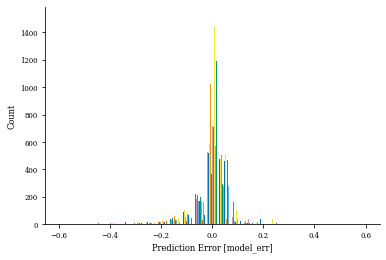

In [43]:
error = test_predictions - (test_features.to_numpy()[:, 165:])
plt.hist(error, bins=25, range=(-0.6,0.6))
plt.xlabel('Prediction Error [model_err]')
_ = plt.ylabel('Count')

In [28]:
'''2'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                     0.006445
165.330.330.165.100e.0.5lr                 0.005192

In [29]:
'''3'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.165.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                     0.006445
165.330.330.165.100e.0.5lr                 0.005192
165.165.165.100e.0.5lr                     0.006789

In [30]:
'''4'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.165.165.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                     0.006445
165.330.330.165.100e.0.5lr                 0.005192
165.165.165.100e.0.5lr                     0.006789
165.165.165.165.100e.0.5lr                 0.005613

In [31]:
'''5'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.165.165.165.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006445
165.330.330.165.100e.0.5lr                     0.005192
165.165.165.100e.0.5lr                         0.006789
165.165.165.165.100e.0.5lr                     0.005613
165.165.165.165.165.100e.0.5lr                 0.005235

In [32]:
'''6'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006445
165.330.330.165.100e.0.5lr                     0.005192
165.165.165.100e.0.5lr                         0.006789
165.165.165.165.100e.0.5lr                     0.005613
165.165.165.165.165.100e.0.5lr                 0.005235
165.330.660.330.165.100e.0.5lr                 0.004850

In [33]:
'''7'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.330.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006445
165.330.330.165.100e.0.5lr                     0.005192
165.165.165.100e.0.5lr                         0.006789
165.165.165.165.100e.0.5lr                     0.005613
165.165.165.165.165.100e.0.5lr                 0.005235
165.330.660.330.165.100e.0.5lr                 0.004850
165.330.330.330.165.100e.0.5lr                 0.005253

In [34]:
'''8'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=200, callbacks=[callback,reduce_lr])

test_results['165.330.330.330.165.200e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006445
165.330.330.165.100e.0.5lr                     0.005192
165.165.165.100e.0.5lr                         0.006789
165.165.165.165.100e.0.5lr                     0.005613
165.165.165.165.165.100e.0.5lr                 0.005235
165.330.660.330.165.100e.0.5lr                 0.004850
165.330.330.330.165.100e.0.5lr                 0.005253
165.330.330.330.165.200e.0.5lr                 0.005217

In [35]:
'''9'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=200, callbacks=[callback,reduce_lr])

test_results['165.330.660.330.165.200e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006445
165.330.330.165.100e.0.5lr                     0.005192
165.165.165.100e.0.5lr                         0.006789
165.165.165.165.100e.0.5lr                     0.005613
165.165.165.165.165.100e.0.5lr                 0.005235
165.330.660.330.165.100e.0.5lr                 0.004850
165.330.330.330.165.100e.0.5lr                 0.005253
165.330.330.330.165.200e.0.5lr                 0.005217
165.330.660.330.165.200e.0.5lr                 0.005123

In [36]:
'''10'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.660.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                             0.006445
165.330.330.165.100e.0.5lr                         0.005192
165.165.165.100e.0.5lr                             0.006789
165.165.165.165.100e.0.5lr                         0.005613
165.165.165.165.165.100e.0.5lr                     0.005235
165.330.660.330.165.100e.0.5lr                     0.004850
165.330.330.330.165.100e.0.5lr                     0.005253
165.330.330.330.165.200e.0.5lr                     0.005217
165.330.660.330.165.200e.0.5lr                     0.005123
165.330.660.660.330.165.100e.0.5lr                 0.005466

In [37]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3)

In [38]:
'''11'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.660.330.165.100e.0.7lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                             0.006445
165.330.330.165.100e.0.5lr                         0.005192
165.165.165.100e.0.5lr                             0.006789
165.165.165.165.100e.0.5lr                         0.005613
165.165.165.165.165.100e.0.5lr                     0.005235
165.330.660.330.165.100e.0.5lr                     0.004850
165.330.330.330.165.100e.0.5lr                     0.005253
165.330.330.330.165.200e.0.5lr                     0.005217
165.330.660.330.165.200e.0.5lr                     0.005123
165.330.660.660.330.165.100e.0.5lr                 0.005466
165.330.660.660.330.165.100e.0.7lr                 0.005179

In [39]:
'''12'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.330.165.100e.0.7lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                             0.006445
165.330.330.165.100e.0.5lr                         0.005192
165.165.165.100e.0.5lr                             0.006789
165.165.165.165.100e.0.5lr                         0.005613
165.165.165.165.165.100e.0.5lr                     0.005235
165.330.660.330.165.100e.0.5lr                     0.004850
165.330.330.330.165.100e.0.5lr                     0.005253
165.330.330.330.165.200e.0.5lr                     0.005217
165.330.660.330.165.200e.0.5lr                     0.005123
165.330.660.660.330.165.100e.0.5lr                 0.005466
165.330.660.660.330.165.100e.0.7lr                 0.005179
165.330.660.330.165.100e.0.7lr                     0.004690

In [40]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)

In [41]:
'''13'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.330.165.100e.0.9lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                             0.006445
165.330.330.165.100e.0.5lr                         0.005192
165.165.165.100e.0.5lr                             0.006789
165.165.165.165.100e.0.5lr                         0.005613
165.165.165.165.165.100e.0.5lr                     0.005235
165.330.660.330.165.100e.0.5lr                     0.004850
165.330.330.330.165.100e.0.5lr                     0.005253
165.330.330.330.165.200e.0.5lr                     0.005217
165.330.660.330.165.200e.0.5lr                     0.005123
165.330.660.660.330.165.100e.0.5lr                 0.005466
165.330.660.660.330.165.100e.0.7lr                 0.005179
165.330.660.330.165.100e.0.7lr                     0.004690
165.330.660.330.165.100e.0.9lr                     0.004786

In [42]:
'''14'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.660.330.165.100e.0.9lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                             0.006445
165.330.330.165.100e.0.5lr                         0.005192
165.165.165.100e.0.5lr                             0.006789
165.165.165.165.100e.0.5lr                         0.005613
165.165.165.165.165.100e.0.5lr                     0.005235
165.330.660.330.165.100e.0.5lr                     0.004850
165.330.330.330.165.100e.0.5lr                     0.005253
165.330.330.330.165.200e.0.5lr                     0.005217
165.330.660.330.165.200e.0.5lr                     0.005123
165.330.660.660.330.165.100e.0.5lr                 0.005466
165.330.660.660.330.165.100e.0.7lr                 0.005179
165.330.660.330.165.100e.0.7lr                     0.004690
165.330.660.330.165.100e.0.9lr                     0.004786
165.330.660.660.330.165.100e.0.9lr                 0.004928

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

In [44]:
'''15'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.660.330.165.100e.0.3lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                             0.006445
165.330.330.165.100e.0.5lr                         0.005192
165.165.165.100e.0.5lr                             0.006789
165.165.165.165.100e.0.5lr                         0.005613
165.165.165.165.165.100e.0.5lr                     0.005235
165.330.660.330.165.100e.0.5lr                     0.004850
165.330.330.330.165.100e.0.5lr                     0.005253
165.330.330.330.165.200e.0.5lr                     0.005217
165.330.660.330.165.200e.0.5lr                     0.005123
165.330.660.660.330.165.100e.0.5lr                 0.005466
165.330.660.660.330.165.100e.0.7lr                 0.005179
165.330.660.330.165.100e.0.7lr                     0.004690
165.330.660.330.165.100e.0.9lr                     0.004786
165.330.660.660.330.165.100e.0.9lr                 0.004928
165.330.660.660.330.165.100e.0.3lr                 0.005892

In [45]:
'''16'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results['165.330.660.330.165.100e.0.3lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                             0.006445
165.330.330.165.100e.0.5lr                         0.005192
165.165.165.100e.0.5lr                             0.006789
165.165.165.165.100e.0.5lr                         0.005613
165.165.165.165.165.100e.0.5lr                     0.005235
165.330.660.330.165.100e.0.5lr                     0.004850
165.330.330.330.165.100e.0.5lr                     0.005253
165.330.330.330.165.200e.0.5lr                     0.005217
165.330.660.330.165.200e.0.5lr                     0.005123
165.330.660.660.330.165.100e.0.5lr                 0.005466
165.330.660.660.330.165.100e.0.7lr                 0.005179
165.330.660.330.165.100e.0.7lr                     0.004690
165.330.660.330.165.100e.0.9lr                     0.004786
165.330.660.660.330.165.100e.0.9lr                 0.004928
165.330.660.660.330.165.100e.0.3lr                 0.005892
165.330.660.330.165.100e.0.3lr                     0.005222

In [46]:
'DNN using full profiles to predict model errs w/ridge 1000 correction'
dataset = []
counter = 0
    
for profile in profiles:
    if counter == 0:
        dataset = full_profiles[profile+""]
    else:
        dataset = np.concatenate((dataset, full_profiles[profile+""]), axis=1)
    counter +=1
    
for profile in profiles:
    dataset = np.concatenate((dataset, np.abs(ridge_errs_1000[profile+""])), axis=1)

ds = pd.DataFrame(dataset)
#print(ds)

train_dataset = ds.sample(frac=0.9, random_state=0)
test_dataset = ds.drop(train_dataset.index)

train_features_ridge = train_dataset.copy()
test_features_ridge = test_dataset.copy()

In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [48]:
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [49]:
dnn_err_model = build_and_compile_model()

err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])
                                                     
test_results_ridge['165.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)
            
pd.DataFrame(test_results_ridge, index=['Custom loss [ridge_errs_1000]']).T

Custom loss [ridge_errs_1000]
165.330.165.100e.0.5lr                       0.008422

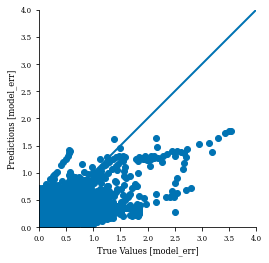

In [46]:
test_predictions = dnn_err_model.predict(test_features.to_numpy()[:, 0:165])

a = plt.axes(aspect='equal')
plt.scatter(test_features.to_numpy()[:, 165:], test_predictions)
plt.xlabel('True Values [model_err]')
plt.ylabel('Predictions [model_err]')
lims = [0, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

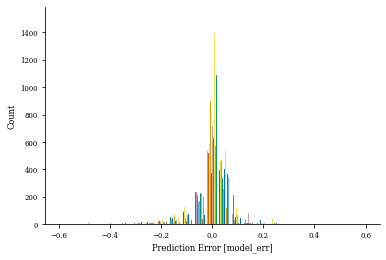

In [47]:
error = test_predictions - (test_features.to_numpy()[:, 165:])
plt.hist(error, bins=25, range=(-0.6,0.6))
plt.xlabel('Prediction Error [model_err]')
_ = plt.ylabel('Count')

In [50]:
'''2'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge['165.330.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                     0.008422
165.330.330.165.100e.0.5lr                 0.007676

In [51]:
'''3'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge['165.330.660.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                     0.008422
165.330.330.165.100e.0.5lr                 0.007676
165.330.660.165.100e.0.5lr                 0.007678

In [52]:
'''4'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge['165.330.660.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008422
165.330.330.165.100e.0.5lr                     0.007676
165.330.660.165.100e.0.5lr                     0.007678
165.330.660.330.165.100e.0.5lr                 0.007495

In [53]:
'''5'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=200, callbacks=[callback,reduce_lr])

test_results_ridge['165.330.660.330.165.200e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008422
165.330.330.165.100e.0.5lr                     0.007676
165.330.660.165.100e.0.5lr                     0.007678
165.330.660.330.165.100e.0.5lr                 0.007495
165.330.660.330.165.200e.0.5lr                 0.007544

In [54]:
'''6'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=50, callbacks=[callback,reduce_lr])

test_results_ridge['165.330.660.330.165.50e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008422
165.330.330.165.100e.0.5lr                     0.007676
165.330.660.165.100e.0.5lr                     0.007678
165.330.660.330.165.100e.0.5lr                 0.007495
165.330.660.330.165.200e.0.5lr                 0.007544
165.330.660.330.165.50e.0.5lr                  0.007227

In [55]:
'''7'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge['165.165.165.165.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008422
165.330.330.165.100e.0.5lr                     0.007676
165.330.660.165.100e.0.5lr                     0.007678
165.330.660.330.165.100e.0.5lr                 0.007495
165.330.660.330.165.200e.0.5lr                 0.007544
165.330.660.330.165.50e.0.5lr                  0.007227
165.165.165.165.165.100e.0.5lr                 0.007781

In [56]:
'''8'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape =(165,)))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge['165.330.660.660.330.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008422
165.330.330.165.100e.0.5lr                     0.007676
165.330.660.165.100e.0.5lr                     0.007678
165.330.660.330.165.100e.0.5lr                 0.007495
165.330.660.330.165.200e.0.5lr                 0.007544
165.330.660.330.165.50e.0.5lr                  0.007227
165.165.165.165.165.100e.0.5lr                 0.007781
165.330.660.660.330.100e.0.5lr                 0.007460

In [57]:
'''full profiles, no ridge, reshape so profiles are individ'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [58]:
dnn_err_model = build_and_compile_model()
#dnn_err_model.summary()

In [59]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [60]:
dnn_err_model = build_and_compile_model()

err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])
                                                     
test_results_reshape['165.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)
            
pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                 0.006049

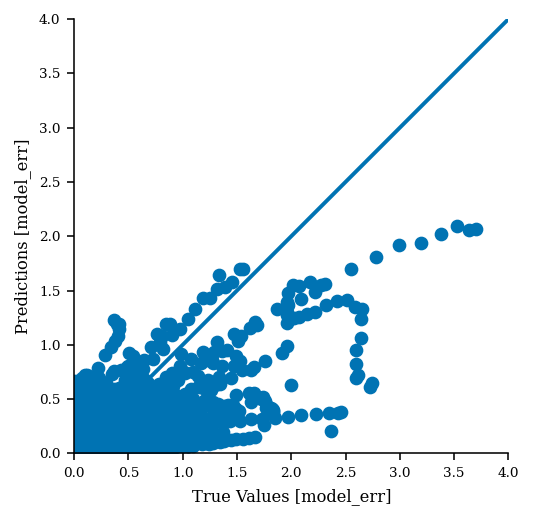

In [61]:
test_predictions = dnn_err_model.predict(test_features.to_numpy()[:, 0:165])

a = plt.axes(aspect='equal')
plt.scatter(test_features.to_numpy()[:, 165:], test_predictions)
plt.xlabel('True Values [model_err]')
plt.ylabel('Predictions [model_err]')
lims = [0, 4]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

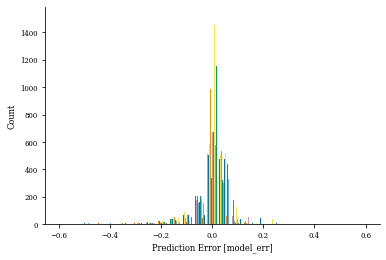

In [74]:
error = test_predictions - (test_features.to_numpy()[:, 165:])
plt.hist(error, bins=25, range=(-0.6,0.6))
plt.xlabel('Prediction Error [model_err]')
_ = plt.ylabel('Count')

In [62]:
'''2'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_reshape['165.330.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                     0.006049
165.330.330.165.100e.0.5lr                 0.005261

In [63]:
'''3'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_reshape['165.330.660.330.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                     0.006049
165.330.330.165.100e.0.5lr                 0.005261
165.330.660.330.100e.0.5lr                 0.005070

In [64]:
'''4'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_reshape['165.165.165.165.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006049
165.330.330.165.100e.0.5lr                     0.005261
165.330.660.330.100e.0.5lr                     0.005070
165.165.165.165.165.100e.0.5lr                 0.005550

In [65]:
'''5'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=200, callbacks=[callback,reduce_lr])

test_results_reshape['165.330.660.330.165.200e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006049
165.330.330.165.100e.0.5lr                     0.005261
165.330.660.330.100e.0.5lr                     0.005070
165.165.165.165.165.100e.0.5lr                 0.005550
165.330.660.330.165.200e.0.5lr                 0.004980

In [66]:
'''6'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=50, callbacks=[callback,reduce_lr])

test_results_reshape['165.330.660.330.165.50e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006049
165.330.330.165.100e.0.5lr                     0.005261
165.330.660.330.100e.0.5lr                     0.005070
165.165.165.165.165.100e.0.5lr                 0.005550
165.330.660.330.165.200e.0.5lr                 0.004980
165.330.660.330.165.50e.0.5lr                  0.004963

In [67]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3)

In [68]:
'''7'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_reshape['165.330.660.330.165.100e.0.7lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006049
165.330.330.165.100e.0.5lr                     0.005261
165.330.660.330.100e.0.5lr                     0.005070
165.165.165.165.165.100e.0.5lr                 0.005550
165.330.660.330.165.200e.0.5lr                 0.004980
165.330.660.330.165.50e.0.5lr                  0.004963
165.330.660.330.165.100e.0.7lr                 0.004848

In [69]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

In [70]:
'''8'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_reshape['165.330.660.330.165.100e.0.3lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.006049
165.330.330.165.100e.0.5lr                     0.005261
165.330.660.330.100e.0.5lr                     0.005070
165.165.165.165.165.100e.0.5lr                 0.005550
165.330.660.330.165.200e.0.5lr                 0.004980
165.330.660.330.165.50e.0.5lr                  0.004963
165.330.660.330.165.100e.0.7lr                 0.004848
165.330.660.330.165.100e.0.3lr                 0.005920

In [71]:
'''full profs, ridge 1000, and reshape'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

In [72]:
test_results_ridge_reshape['165.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)
            
pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [ridge_errs_1000]']).T

Custom loss [ridge_errs_1000]
165.330.165.100e.0.5lr                        0.00848

In [73]:
'''2'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge_reshape['165.330.660.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008480
165.330.660.330.165.100e.0.5lr                 0.007409

In [74]:
'''3'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge_reshape['165.165.165.165.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008480
165.330.660.330.165.100e.0.5lr                 0.007409
165.165.165.165.165.100e.0.5lr                 0.007554

In [75]:
'''4'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge_reshape['165.330.330.165.100e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008480
165.330.660.330.165.100e.0.5lr                 0.007409
165.165.165.165.165.100e.0.5lr                 0.007554
165.330.330.165.100e.0.5lr                     0.007565

In [76]:
'''5'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=200, callbacks=[callback,reduce_lr])

test_results_ridge_reshape['165.330.660.330.165.200e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008480
165.330.660.330.165.100e.0.5lr                 0.007409
165.165.165.165.165.100e.0.5lr                 0.007554
165.330.330.165.100e.0.5lr                     0.007565
165.330.660.330.165.200e.0.5lr                 0.007462

In [77]:
'''6'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=50, callbacks=[callback,reduce_lr])

test_results_ridge_reshape['165.330.660.330.165.50e.0.5lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008480
165.330.660.330.165.100e.0.5lr                 0.007409
165.165.165.165.165.100e.0.5lr                 0.007554
165.330.330.165.100e.0.5lr                     0.007565
165.330.660.330.165.200e.0.5lr                 0.007462
165.330.660.330.165.50e.0.5lr                  0.007266

In [78]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3)

In [79]:
'''7'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge_reshape['165.330.660.330.165.100e.0.7lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008480
165.330.660.330.165.100e.0.5lr                 0.007409
165.165.165.165.165.100e.0.5lr                 0.007554
165.330.330.165.100e.0.5lr                     0.007565
165.330.660.330.165.200e.0.5lr                 0.007462
165.330.660.330.165.50e.0.5lr                  0.007266
165.330.660.330.165.100e.0.7lr                 0.007291

In [80]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

In [81]:
'''8'''
def build_and_compile_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((5,33),input_shape =(165,)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(165, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(660, activation='relu'))
    model.add(tf.keras.layers.Dense(330, activation='relu'))
    model.add(tf.keras.layers.Dense(165, activation='relu'))
        
    model.compile(loss=custom_loss_function,optimizer=tf.keras.optimizers.Adam(0.001))

    return model

dnn_err_model = build_and_compile_model()
err_model = dnn_err_model.fit(train_features_ridge.to_numpy()[:, 0:165], 
                              train_features_ridge.to_numpy()[:, 165:], 
                              validation_split=1.0/9, 
                              verbose=0, 
                              epochs=100, callbacks=[callback,reduce_lr])

test_results_ridge_reshape['165.330.660.330.165.100e.0.3lr'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results_ridge_reshape, index=['Custom loss [model_err]']).T

Custom loss [model_err]
165.330.165.100e.0.5lr                         0.008480
165.330.660.330.165.100e.0.5lr                 0.007409
165.165.165.165.165.100e.0.5lr                 0.007554
165.330.330.165.100e.0.5lr                     0.007565
165.330.660.330.165.200e.0.5lr                 0.007462
165.330.660.330.165.50e.0.5lr                  0.007266
165.330.660.330.165.100e.0.7lr                 0.007291
165.330.660.330.165.100e.0.3lr                 0.007724

In [34]:
'''full profs model 2'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_err_model = build_and_compile_model()

In [35]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)

test_results['model.165.all'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                         0.055204
model.165.all                         0.055191

In [36]:
'''full profs model 3'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_err_model = build_and_compile_model()

In [37]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)

test_results['model.165.all.0.01'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                              0.055204
model.165.all                              0.055191
model.165.all.0.01                         0.055615

In [38]:
'''full profs model 4'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_err_model = build_and_compile_model()

In [39]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=200)

test_results['model.200e'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                              0.055204
model.165.all                              0.055191
model.165.all.0.01                         0.055615
model.200e                                 0.055145

In [40]:
'''full profs model 5'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_err_model = build_and_compile_model()

In [41]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=50)

test_results['model.50e'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                              0.055204
model.165.all                              0.055191
model.165.all.0.01                         0.055615
model.200e                                 0.055145
model.50e                                  0.055218

In [42]:
'''full profs model 6'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_err_model = build_and_compile_model()

In [43]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)

test_results['model.165.4'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                              0.055204
model.165.all                              0.055191
model.165.all.0.01                         0.055615
model.200e                                 0.055145
model.50e                                  0.055218
model.165.4                                0.055157

In [44]:
'''full profs model 7'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(330, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_err_model = build_and_compile_model()

In [45]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)

test_results['model.165.330.165.165'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                 0.055204
model.165.all                                 0.055191
model.165.all.0.01                            0.055615
model.200e                                    0.055145
model.50e                                     0.055218
model.165.4                                   0.055157
model.165.330.165.165                         0.055158

In [46]:
'''full profs model 8'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(330, activation='relu'),
      layers.Dense(330, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_err_model = build_and_compile_model()

In [47]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)

test_results['model.165.330.330.165'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                 0.055204
model.165.all                                 0.055191
model.165.all.0.01                            0.055615
model.200e                                    0.055145
model.50e                                     0.055218
model.165.4                                   0.055157
model.165.330.165.165                         0.055158
model.165.330.330.165                         0.055170

In [75]:
'''full profs model 9'''

def build_and_compile_model():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(165,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_err_model = build_and_compile_model()

In [76]:
err_model = dnn_err_model.fit(train_features.to_numpy()[:, 0:165], 
                              train_features.to_numpy()[:, 165:], 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=200)

test_results['model.165.4.220e'] = dnn_err_model.evaluate(
    test_features.to_numpy()[:, 0:165], test_features.to_numpy()[:,165:],
    verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                             0.055204
model.165.all                                             0.055191
model.165.all.0.01                                        0.055615
model.200e                                                0.055145
model.50e                                                 0.055218
model.165.4                                               0.055157
model.165.330.165.165                                     0.055158
model.165.330.330.165                                     0.055170
dnn_err_model_pca                                         0.054457
dnn_err_model_pca_0.01                                    0.055421
dnn_err_model_pca_165.all                                 0.054720
dnn_err_model_pca_25.165.165                              0.054860
dnn_err_model_pca_25.330.165                              0.054765
dnn_err_model_pca_25.25.165                               0.054841
dnn_err_model_pca_25.165.165.200e                         0.054809
dnn_err_model_pca_25.165.165.165                          0.054525
dnn_err_model_pca_25.165.165.50e                          0.054499
dnn_err_model_pca_25.165.330.165                          0.053955
model.165.4.220e                                          0.055165

In [48]:
'DNN using pca modes of full profiles to predict model errs'
dataset = []
counter = 0
# for profile in profiles:
#     if counter == 0:
#         dataset = np.concatenate((full_profiles[profile+""],model_err[profile+""]), axis=1)
#     else:
#         dataset = np.concatenate((dataset, np.concatenate((full_profiles[profile+""],model_err[profile+""]), axis = 1)),axis=0)
#     counter +=1
    
for profile in profiles:
    if counter == 0:
        dataset = coeff_og[profile+""]
    else:
        dataset = np.concatenate((dataset, coeff_og[profile+""]), axis=1)
    counter +=1


#dataset = full_profiles['dens']

dataset_tar = []
columns = []
counter2 = 0
for profile in profiles:
    if counter2 == 0:
        dataset_tar = model_err[profile+""]
    else:
        dataset_tar = np.concatenate((dataset_tar, model_err[profile+""]), axis=1)
    for i in range(33):
        columns.append(profile+str(i+1))
    counter2 +=1
    
# datadict = {}
# datadict['inputs'] = list(dataset)
# datadict['outputs'] = list(dataset_tar)
#(dataset, columns = ['dens 1', 'dens 2', 'dens 3', 'dens 4', 'dens 5', 'temp 1', 'temp 2', 'temp 3', 'temp 4', 'temp 5', 'q_EFIT01 1', 'q_EFIT01 2', 'q_EFIT01 3', 'q_EFIT01 4', 'q_EFIT01 5', 'rotation 1', 'rotation 2', 'rotation 3', 'rotation 4', 'rotation 5', 'press_EFIT01 1', 'press_EFITO1 2', 'press_EIFT01 3', 'press_EFIT01 4', 'press_EFIT01 5'])
    
#data = ['inputs': dataset, 'outputs': dataset_tar]
ds = pd.DataFrame(dataset)
print(ds)

train_dataset = ds.sample(frac=0.8, random_state=0)
test_dataset = ds.drop(train_dataset.index)

ds_err = pd.DataFrame(dataset_tar)
print(ds_err)

train_dataset_err = ds_err.sample(frac=0.8, random_state=0)
test_dataset_err = ds_err.drop(train_dataset.index)

pca_train_features = train_dataset.copy()
pca_test_features = test_dataset.copy()
pca_train_features_tar = train_dataset_err.copy()
pca_test_features_tar = test_dataset_err.copy()

             0         1         2         3         4         5         6   \
0     -5.055049 -0.016029  0.191518 -0.110740 -0.136174 -2.303258  0.374974   
1     -4.809450 -0.561397  0.263739 -0.186803 -0.216389 -2.086003 -0.060588   
2     -4.009712 -0.830768  0.367812 -0.204282 -0.337397 -1.755907 -0.261117   
3     -3.800621 -0.777478  0.273641 -0.201154 -0.214877 -1.996040 -0.168517   
4     -3.262928 -0.571563  0.403793 -0.080224 -0.215286 -1.998213 -0.197708   
...         ...       ...       ...       ...       ...       ...       ...   
15127  2.054825 -0.731936 -0.123594  0.727960 -0.230511 -2.516826  0.208948   
15128  1.881672 -0.767645 -0.123932  0.714049 -0.225281 -2.806627  0.075070   
15129  1.974323 -0.664670 -0.075729  0.634956 -0.198701 -2.586651  0.171786   
15130 -3.767430 -0.032649  0.100528  0.100502 -0.082013 -1.263438  0.720612   
15131 -3.459295  0.292848  0.149316  0.047476 -0.101117 -0.285491  0.905622   

             7         8         9   ...        15 

In [51]:
#print(train_dataset)
#print(train_dataset_err)

In [52]:
'''DNN w/pca coefs as inputs'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(320, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [53]:
dnn_err_model_pca = build_and_compile_model_pca()
dnn_err_model_pca.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 25)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 165)               4290      
_________________________________________________________________
dense_36 (Dense)             (None, 320)               53120     
_________________________________________________________________
dense_37 (Dense)             (None, 165)               52965     
Total params: 110,375
Trainable params: 110,375
Non-trainable params: 0
_________________________________________________________________


In [54]:
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)

In [55]:
test_results['dnn_err_model_pca'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)

In [56]:
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                 0.055204
model.165.all                                 0.055191
model.165.all.0.01                            0.055615
model.200e                                    0.055145
model.50e                                     0.055218
model.165.4                                   0.055157
model.165.330.165.165                         0.055158
model.165.330.330.165                         0.055170
dnn_err_model_pca                             0.054457

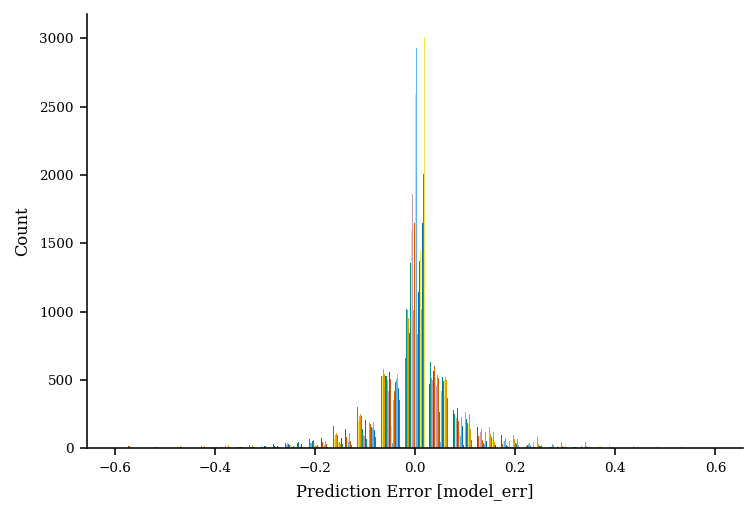

In [97]:
test_predictions = dnn_err_model_pca.predict(pca_test_features.to_numpy())

error = test_predictions - (pca_test_features_tar.to_numpy())
plt.hist(error, bins=25, range=(-0.6,0.6))
plt.xlabel('Prediction Error [model_err]')
_ = plt.ylabel('Count')

In [57]:
'''DNN w/pca coefs as inputs 2'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(320, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [58]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)
test_results['dnn_err_model_pca_0.01'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                  0.055204
model.165.all                                  0.055191
model.165.all.0.01                             0.055615
model.200e                                     0.055145
model.50e                                      0.055218
model.165.4                                    0.055157
model.165.330.165.165                          0.055158
model.165.330.330.165                          0.055170
dnn_err_model_pca                              0.054457
dnn_err_model_pca_0.01                         0.055421

In [59]:
'''DNN w/pca coefs as inputs 3'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [60]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)
test_results['dnn_err_model_pca_165.all'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                     0.055204
model.165.all                                     0.055191
model.165.all.0.01                                0.055615
model.200e                                        0.055145
model.50e                                         0.055218
model.165.4                                       0.055157
model.165.330.165.165                             0.055158
model.165.330.330.165                             0.055170
dnn_err_model_pca                                 0.054457
dnn_err_model_pca_0.01                            0.055421
dnn_err_model_pca_165.all                         0.054720

In [61]:
'''DNN w/pca coefs as inputs 4'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [62]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)
test_results['dnn_err_model_pca_25.165.165'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                        0.055204
model.165.all                                        0.055191
model.165.all.0.01                                   0.055615
model.200e                                           0.055145
model.50e                                            0.055218
model.165.4                                          0.055157
model.165.330.165.165                                0.055158
model.165.330.330.165                                0.055170
dnn_err_model_pca                                    0.054457
dnn_err_model_pca_0.01                               0.055421
dnn_err_model_pca_165.all                            0.054720
dnn_err_model_pca_25.165.165                         0.054860

In [63]:
'''DNN w/pca coefs as inputs 5'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(330, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [64]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)
test_results['dnn_err_model_pca_25.330.165'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                        0.055204
model.165.all                                        0.055191
model.165.all.0.01                                   0.055615
model.200e                                           0.055145
model.50e                                            0.055218
model.165.4                                          0.055157
model.165.330.165.165                                0.055158
model.165.330.330.165                                0.055170
dnn_err_model_pca                                    0.054457
dnn_err_model_pca_0.01                               0.055421
dnn_err_model_pca_165.all                            0.054720
dnn_err_model_pca_25.165.165                         0.054860
dnn_err_model_pca_25.330.165                         0.054765

In [65]:
'''DNN w/pca coefs as inputs 6'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(25, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [66]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)
test_results['dnn_err_model_pca_25.25.165'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                        0.055204
model.165.all                                        0.055191
model.165.all.0.01                                   0.055615
model.200e                                           0.055145
model.50e                                            0.055218
model.165.4                                          0.055157
model.165.330.165.165                                0.055158
model.165.330.330.165                                0.055170
dnn_err_model_pca                                    0.054457
dnn_err_model_pca_0.01                               0.055421
dnn_err_model_pca_165.all                            0.054720
dnn_err_model_pca_25.165.165                         0.054860
dnn_err_model_pca_25.330.165                         0.054765
dnn_err_model_pca_25.25.165                          0.054841

In [67]:
'''DNN w/pca coefs as inputs 7'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [68]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=200)
test_results['dnn_err_model_pca_25.165.165.200e'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                             0.055204
model.165.all                                             0.055191
model.165.all.0.01                                        0.055615
model.200e                                                0.055145
model.50e                                                 0.055218
model.165.4                                               0.055157
model.165.330.165.165                                     0.055158
model.165.330.330.165                                     0.055170
dnn_err_model_pca                                         0.054457
dnn_err_model_pca_0.01                                    0.055421
dnn_err_model_pca_165.all                                 0.054720
dnn_err_model_pca_25.165.165                              0.054860
dnn_err_model_pca_25.330.165                              0.054765
dnn_err_model_pca_25.25.165                               0.054841
dnn_err_model_pca_25.165.165.200e                         0.054809

In [69]:
'''DNN w/pca coefs as inputs 8'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [70]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=100)
test_results['dnn_err_model_pca_25.165.165.165'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                             0.055204
model.165.all                                             0.055191
model.165.all.0.01                                        0.055615
model.200e                                                0.055145
model.50e                                                 0.055218
model.165.4                                               0.055157
model.165.330.165.165                                     0.055158
model.165.330.330.165                                     0.055170
dnn_err_model_pca                                         0.054457
dnn_err_model_pca_0.01                                    0.055421
dnn_err_model_pca_165.all                                 0.054720
dnn_err_model_pca_25.165.165                              0.054860
dnn_err_model_pca_25.330.165                              0.054765
dnn_err_model_pca_25.25.165                               0.054841
dnn_err_model_pca_25.165.165.200e                         0.054809
dnn_err_model_pca_25.165.165.165                          0.054525

In [79]:
'''DNN w/pca coefs as inputs 9'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [80]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=50)
test_results['dnn_err_model_pca_25.165.165.50e'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                                0.055204
model.165.all                                                0.055191
model.165.all.0.01                                           0.055615
model.200e                                                   0.055145
model.50e                                                    0.055218
model.165.4                                                  0.055157
model.165.330.165.165                                        0.055158
model.165.330.330.165                                        0.055170
dnn_err_model_pca                                            0.054457
dnn_err_model_pca_0.01                                       0.055421
dnn_err_model_pca_165.all                                    0.054720
dnn_err_model_pca_25.165.165                                 0.054860
dnn_err_model_pca_25.330.165                                 0.054765
dnn_err_model_pca_25.25.165                                  0.054841
dnn_err_model_pca_25.165.165.200e                            0.054809
dnn_err_model_pca_25.165.165.165                             0.054525
dnn_err_model_pca_25.165.165.50e                             0.054242
dnn_err_model_pca_25.165.330.165                             0.053955
model.165.4.220e                                             0.055165
dnn_err_model_pca_25.165.330.165.50e                         0.054582

In [73]:
'''DNN w/pca coefs as inputs 10'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(330, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [74]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=200)
test_results['dnn_err_model_pca_25.165.330.165'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                             0.055204
model.165.all                                             0.055191
model.165.all.0.01                                        0.055615
model.200e                                                0.055145
model.50e                                                 0.055218
model.165.4                                               0.055157
model.165.330.165.165                                     0.055158
model.165.330.330.165                                     0.055170
dnn_err_model_pca                                         0.054457
dnn_err_model_pca_0.01                                    0.055421
dnn_err_model_pca_165.all                                 0.054720
dnn_err_model_pca_25.165.165                              0.054860
dnn_err_model_pca_25.330.165                              0.054765
dnn_err_model_pca_25.25.165                               0.054841
dnn_err_model_pca_25.165.165.200e                         0.054809
dnn_err_model_pca_25.165.165.165                          0.054525
dnn_err_model_pca_25.165.165.50e                          0.054499
dnn_err_model_pca_25.165.330.165                          0.053955

In [77]:
'''DNN w/pca coefs as inputs 11'''

def build_and_compile_model_pca():
  model = keras.Sequential([
      #norm,
      layers.Flatten(input_shape =(25,)),
      layers.Dense(25, activation='relu'),
      layers.Dense(165, activation='relu'),
      layers.Dense(330, activation='relu'),
      layers.Dense(165)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [78]:
dnn_err_model_pca = build_and_compile_model_pca()
err_model_pca = dnn_err_model_pca.fit(pca_train_features.to_numpy(), 
                              pca_train_features_tar.to_numpy(), 
                              validation_split=0.2, 
                              verbose=0, 
                              epochs=50)
test_results['dnn_err_model_pca_25.165.330.165.50e'] = dnn_err_model_pca.evaluate(
    pca_test_features.to_numpy(), pca_test_features_tar.to_numpy(),
    verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [model_err]']).T

Mean absolute error [model_err]
dnn_err_model                                                0.055204
model.165.all                                                0.055191
model.165.all.0.01                                           0.055615
model.200e                                                   0.055145
model.50e                                                    0.055218
model.165.4                                                  0.055157
model.165.330.165.165                                        0.055158
model.165.330.330.165                                        0.055170
dnn_err_model_pca                                            0.054457
dnn_err_model_pca_0.01                                       0.055421
dnn_err_model_pca_165.all                                    0.054720
dnn_err_model_pca_25.165.165                                 0.054860
dnn_err_model_pca_25.330.165                                 0.054765
dnn_err_model_pca_25.25.165                                  0.054841
dnn_err_model_pca_25.165.165.200e                            0.054809
dnn_err_model_pca_25.165.165.165                             0.054525
dnn_err_model_pca_25.165.165.50e                             0.054499
dnn_err_model_pca_25.165.330.165                             0.053955
model.165.4.220e                                             0.055165
dnn_err_model_pca_25.165.330.165.50e                         0.054582

In [15]:
# fig, axes = plt.subplots(1,2)
# points = coeff_err['dens'][:,0]
# df = pd.DataFrame(points)
# df.hist(ax=axes[0])
# points2 = coeff_err['temp'][:,0]
# df2 = pd.DataFrame(points)
# df2.hist(ax=axes[1])

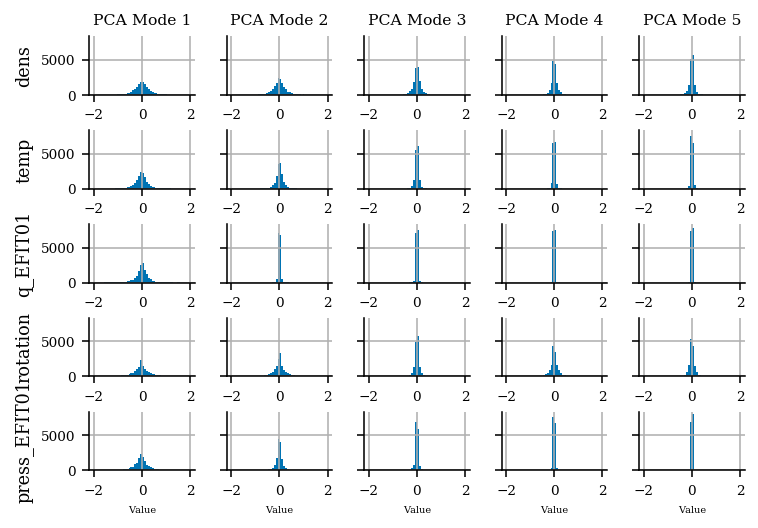

In [18]:
'''histograms of the error pca coefficients'''

labels = profiles
fig, axes = plt.subplots(5,5, sharey=True)

counter = 0

for profile in profiles:
    for i in range(5):
        ax = axes[counter,i]
        points = coeff_err[profile][:,i]
        df = pd.DataFrame(points)
        df.hist(ax=axes[counter][i], bins=50, range=[-2,2])
        if counter==0:
            ax.set_title('PCA Mode {}'.format(i+1), size=8)
        else:
            ax.set_title('')
        if i==0:
            ax.set_ylabel(labels[counter], size=9)
        ax.set_xlabel('Value',size=5)
    counter += 1
plt.subplots_adjust(wspace=0.3, 
                    hspace=0.6)
plt.show()

In [17]:
print(len(coeff_og['dens']))
print(len(coeff_og['dens'][0]))
# print(len(full_pca_fitters['dens'].components_))
# print(len(full_pca_fitters['dens'].components_[0]))
# print(len(full))
# print(len(full[0]))
# print(len(model_err['dens']))
# print(len(model_err['dens'][0]))
print(len(np.corrcoef(coeff_og['dens'], coeff_err['dens'], rowvar=False)))
print(len(np.corrcoef(coeff_og['dens'], coeff_err['dens'], rowvar=False)[0]))

15132
5
10
10


In [47]:
corrcoef = np.corrcoef(coeffs_og['dens'], coeffs_err['dens'])

NameError: name 'coeffs_og' is not defined

In [42]:
#testcc3 = np.corrcoef(coeff_og['dens'], coeff_err['dens'],rowvar=False)
#plt.imshow(testcc3)

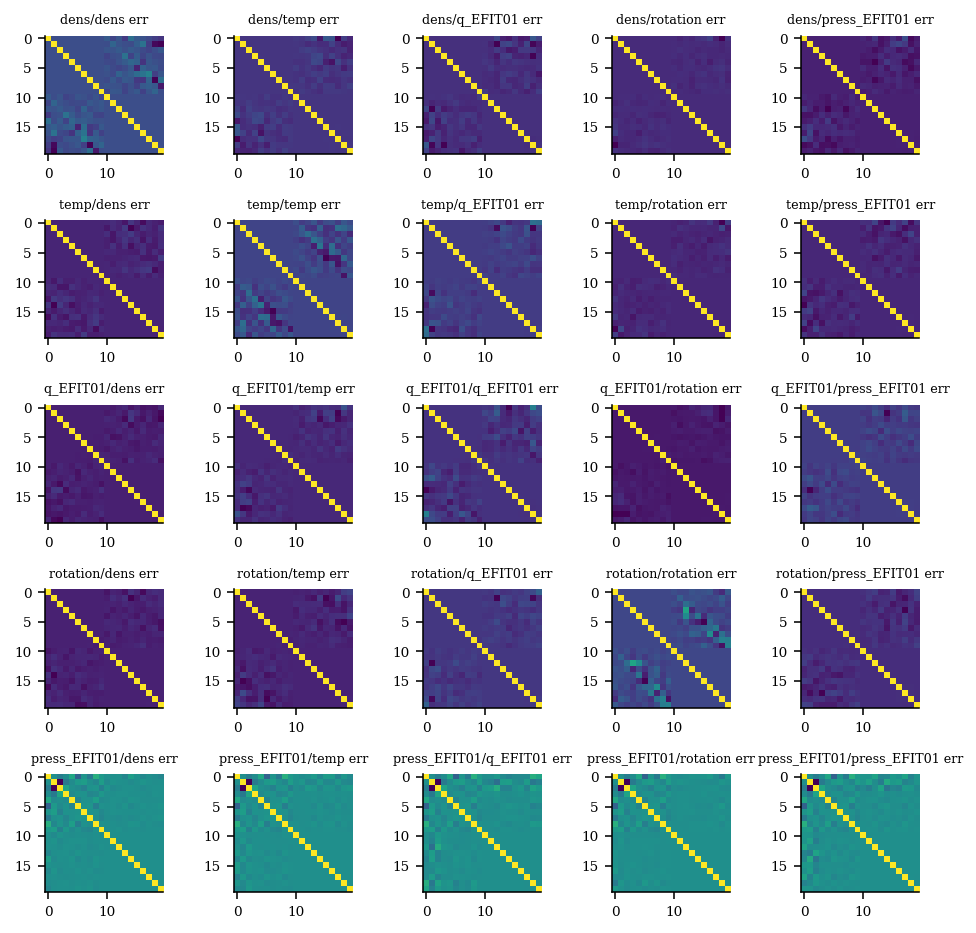

In [41]:
'''correlation coefficient graphs for pca modes'''
#fig1, ax1 = plt.subplots(5,5, sharey=True)
# ncols = 5
# ylabels = profiles
# fig, axes = plt.subplots(len(profiles*2),ncols, sharex=True, sharey=True,figsize=(10,20))
# w = 10
# h = 10
fig = plt.figure(figsize=(8,8))
#fig, ax = plt.subplots(10,10,sharex=True, sharey=True, figsize=(8,8))
columns = 5
rows = 5
counter = 1
ax = []
for profile in profiles:
    for profile2 in profiles:
        corrcoef = np.corrcoef(coeff_og[profile], coeff_err[profile2], rowvar=False)
        #fig.add_subplot(rows, columns, counter)
        ax.append(fig.add_subplot(rows, columns, counter))
        ax[-1].set_title(profile+ "/" + profile2 + " err", fontsize=6.5)
        plt.imshow(corrcoef)
        counter += 1
plt.subplots_adjust(wspace=0.6, 
                    hspace=0.42)
plt.show()
        #ax1[profiles.index(profile), profiles.index(profile2)] = plt.imshow(corrcoef)
        #plt.title("corrcoeff between "+profile+" and "+profile2+" err: " + corrcoef)
        #plt.show()
        #print("corrcoeff between "+profile+" and "+profile2+" err: " + corrcoef)
# for profile in profiles:
#     for profile2 in profiles:
#         corrcoef = np.corrcoef(coeff_og[profile], coeff_err_abs[profile2])
#         corrcoef2 = np.corrcoef(coeff_og[profile], coeff_err_abs[profile2])
#         ax1[profiles.index(profile), profiles.index(profile2)] = plt.imshow(corrcoef)
#         plt.colorbar(graph)
#         graph = plt.imshow(corrcoef)            
#         plt.colorbar(graph)
#         plt.title("corrcoef between "+profile+" and "+profile2+" abs err: " + corrcoef)
#         plt.show()
#         #print("corrcoef between "+profile+" and "+profile2+" abs err: " + corrcoef)

In [26]:
# w2 = 10
# h2 = 10
# fig2 = plt.figure(figsize=(8,8))
# columns2 = 5
# rows2 = 5
# counter2 = 1
# ax2 = []
# for profile in profiles:
#     for profile2 in profiles:
#         corrcoef = np.corrcoef(coeff_og[profile], coeff_err_abs[profile2], rowvar=False)
#         #fig.add_subplot(rows, columns, counter)
#         ax2.append(fig2.add_subplot(rows2, columns2, counter2))
#         ax2[-1].set_title(profile+ " vs. " + profile2 + " abs err")
#         plt.imshow(corrcoef)
#         counter += 1
# #plt.colorbar(fig)
# plt.show()

In [38]:
'''total error in predictions by profile'''
for profile in profiles:
    print("Sum of errors for " + profile + ": " +str(np.sum(model_err_abs[profile])))
    print("Mean error: " + str(np.sum(model_err_abs[profile]/(33*15132))))

Sum of errors for dens: 36745.863
Mean error: 0.07358650004214146
Sum of errors for temp: 23256.012
Mean error: 0.04657199700644966
Sum of errors for q_EFIT01: 15360.515
Mean error: 0.030760649587082443
Sum of errors for rotation: 40884.17
Mean error: 0.08187379505248944
Sum of errors for press_EFIT01: 23917.285
Mean error: 0.04789625344027893


In [19]:
'''stats for error predictions of signed err values'''
for profile in profiles:
    print("Sum of errors for " + profile + ": " +str(np.sum(model_err[profile])))
    print("Mean error: " + str(np.sum(model_err[profile]/(33*15132))))

Sum of errors for dens: 730.13184
Mean error: 0.0014621469767533391
Sum of errors for temp: 1114.4929
Mean error: 0.002231860425361567
Sum of errors for q_EFIT01: -794.82764
Mean error: -0.0015917052577531835
Sum of errors for rotation: 1923.6844
Mean error: 0.0038523306883642226
Sum of errors for press_EFIT01: 1495.6423
Mean error: 0.002995141910571135


In [40]:
#re-do-- they're big bc these are already normalized to 1 so dividing by v small numbers?
'''error statstic from papers'''
N = 15132 * 33 * 5
num = 0
denom = 0
for sig in scenario['target_profile_names']:
    dev_sum = (baseline[sig]-predictions[sig])**2
    num += sum([sum(i) for i in dev_sum]) 
    base_sum = baseline[sig]**2
    denom += sum([sum(i) for i in base_sum])
    rms_err = math.sqrt(num/N)/(math.sqrt(denom/N))
    print("rms error for "+sig+": " + str(rms_err))

rms error for dens: 0.5549836261349682
rms error for temp: 0.5434340844358296
rms error for q_EFIT01: 0.5536987252219678
rms error for rotation: 0.5483247320641026
rms error for press_EFIT01: 0.5288661418696574


In [41]:
print(len(dev_sum))
print(len(dev_sum[0]))
print(type(dev_sum))
print(scenario['target_profile_names'])
print(len(baseline['dens']))
print(len(baseline['dens'][0]))
print(baseline['dens']-predictions['dens'])
print(baseline['dens'])
print(type(num))

15132
33
<class 'numpy.ndarray'>
['dens', 'temp', 'q_EFIT01', 'rotation', 'press_EFIT01']
15132
33
[[ 0.19179958  0.19223334  0.19640946 ...  0.1098856   0.03226465
   0.02188868]
 [ 0.0478818   0.04380314  0.02780144 ...  0.13400455  0.06712984
   0.02198739]
 [ 0.1991896   0.19252226  0.16520612 ...  0.05804776  0.02607584
   0.00591751]
 ...
 [ 0.00967051  0.02349196  0.03609432 ... -0.00894899  0.05536461
   0.0131079 ]
 [-0.45543927 -0.4040034  -0.43631768 ...  0.36123222 -0.09981668
  -0.2603584 ]
 [-0.37330377 -0.33623952 -0.348154   ...  0.5923842  -0.12958738
  -0.27777648]]
[[ 0.27830762  0.27361178  0.26199228 ...  0.323932    0.15936363
   0.08228159]
 [ 0.21064976  0.21116665  0.21284616 ...  0.27609217  0.16264677
   0.07161725]
 [ 0.33343336  0.32846856  0.31545442 ...  0.14000714  0.08731616
   0.03879404]
 ...
 [-0.01119584 -0.01101595 -0.01051414 ... -0.00422618  0.05458818
   0.0100553 ]
 [ 0.14575903  0.1486083   0.1569422  ...  0.79734296  0.15189701
  -0.1389929 ]

In [ ]:
base_sum = 0
for sig in scenario['target_profile_names']:
    base_sum += baseline[sig]**2

In [81]:
'''relative error in predictions by profile'''
#big_base = {}
#big_pred = {}

# print(sig)
# print(baseline[sig])
# print(len(baseline[sig]))
# print(len(baseline[sig][0]))
# print(baseline[sig][0][0])

# for sig in scenario['target_profile_names']:
#     big_base[sig] = baseline[sig] * 10000
#     big_pred[sig] = predictions[sig] * 10000
#     for i in range(15132):
#         for j in range(33):
#             if baseline[sig][i][j] < 10**-6:
#                 big_base[sig][i][j] = np.inf

#true-predicted/avg of (abs(true+predicted))
#print(big_base)
percent_model_err_abs = {sig: np.abs(baseline[sig]-predictions[sig])/(abs(baseline[sig])+abs(predictions[sig])/2) for sig in scenario['target_profile_names']}
#print(percent_model_err_abs)

for profile in profiles:
    print("Sum of errors for " + profile + ": " +str(np.sum(percent_model_err_abs[profile])))
    print(np.sum(percent_model_err_abs[profile]/(33*15132)))

# for sig in scenario['target_profile_names']:
#     for i in range(15132):
#         for j in range(33):
#             if big_base[sig][i][j] == np.inf:
#                 percent_model_err_abs = {sig: 0}
#             else:
#                 percent_model_err_abs = {sig: np.abs((big_pred[sig] - big_base[sig])/big_base[sig])}
                

Sum of errors for dens: 326764.6
0.6543718273100095
Sum of errors for temp: 349627.8
0.7001575243986293
Sum of errors for q_EFIT01: 328899.28
0.6586468844236691
Sum of errors for rotation: 412259.47
0.8255822431483832
Sum of errors for press_EFIT01: 348514.56
0.6979279555426368


In [22]:
#print(full_pca_fitters)

{'dens': IncrementalPCA(batch_size=None, copy=True, n_components=10, whiten=False), 'temp': IncrementalPCA(batch_size=None, copy=True, n_components=10, whiten=False), 'q_EFIT01': IncrementalPCA(batch_size=None, copy=True, n_components=10, whiten=False), 'rotation': IncrementalPCA(batch_size=None, copy=True, n_components=10, whiten=False), 'press_EFIT01': IncrementalPCA(batch_size=None, copy=True, n_components=10, whiten=False)}


In [38]:
# print(len(full_pca_fitters))
# print(len(full_pca_fitters[0]))
# print(len(full_pca_fitter_errs))
# print(len(full_pca_fitter_errs[0]))
# print(len(full_pca_fitter_errs_abs))
# print(len(full_pca_fitter_errs_abs[0]))


In [68]:
# '''COVARIANCE MATRICES'''
# #print(full_pca_fitters['dens'].components_[0])
# #print(pca_og.components_[0])

# for profile in profiles:
#     for i in range(5):
#         pca_og=full_pca_fitters[profile].components_[i]
#         pca=full_pca_fitter_errs[profile].components_[i]
# #       print("OG")
# #       print(pca_og)
# #       print("pca")
# #       print(pca)
# #       print('abs')
# #       print(pca_abs)
#         cov1 = np.cov(pca_og,pca)
#         print("Covariance between PCA components of "+profile+" and PCA components of its errors, PCA Mode " +str(i)+ ": ")
#         print(cov1)

        
# for profile in profiles:
#     for i in range(5):
#         pca_og=full_pca_fitters[profile].components_[i]
#         pca_abs=full_pca_fitter_errs_abs[profile].components_[i]
#         cov2 = np.cov(pca_og, pca_abs)
#         print("Covariance between PCA components of "+profile+" and PCA components of the abs values of its errors, PCA Mode "+str(i)+ ": ")
#         print(cov2)
        

In [ ]:
'''SCRATCH WORK BELOW'''

In [ ]:
'''plot pca mode and abs error pca modes together'''
ncols = 5
ylabels = profiles
fig, axes = plt.subplots(len(profiles),ncols, sharex=True, sharey=True,figsize=(10,10))
# fig, axes = plt.subplots(nrows,ncols, sharex=True, sharey=False,figsize=(6,5))

psi = np.linspace(0,1,33)
labels = profiles
for i,profile in enumerate(profiles):            
    pca_abs=full_pca_fitter_errs_abs[profile]
    for j in range(ncols):
        ax1= axes[i,j]
        ax1.plot(psi,pca_abs.components_[j],lw=2)
        ax1.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca_abs.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax1.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('(abs) PCA Mode {}'.format(j+1), size=8)
        ax1.set_xlabel('$\psi$',size=8)
        ax1.set_ylim(-.4,.4)
        ax1.tick_params(axis='both', which='major', labelsize=ticksize)
        ax1.set_xticks([0,.5,1])
        ax1.set_xlim(0,1)
        
    pca_og=full_pca_fitters[profile]
    for j in range(ncols):
        ax= axes[i,j]
        ax.plot(psi,pca_og.components_[j],lw=2)
        ax.text(0.4,0.3,'$\hat{\sigma}^2$' + ' = {:.3f}'.format(pca_og.explained_variance_ratio_[j]),fontsize=labelsize)
        if j==0:
            ax.set_ylabel(labels[i], size=labelsize)
        if i==0:
            ax.set_title('PCA Mode {}'.format(j+1), size=8)
        ax.set_xlabel('$\psi$',size=8)
        ax.set_ylim(-.4,.4)
        ax.tick_params(axis='both', which='major', labelsize=ticksize)
        ax.set_xticks([0,.5,1])
        ax.set_xlim(0,1)

        ax.axhline(0,c='k',lw=1)

        ax1.axhline(0,c='k',lw=1)

In [63]:
print("dimensions: ")
print(len(full_err))
print(len(full_err[0]))
print(full_err)
print("***full starts below:***")
print("dimensions: ")
print(len(full))
print(len(full[0]))
print(full)

dimensions: 
15132
33
[[-5.1872993e-01 -3.3506826e-01 -3.1389165e-01 ...  3.4220427e-02
   1.5933022e-02 -3.6089122e-04]
 [-2.0140204e-01 -2.7304441e-02  1.0433793e-03 ...  2.6246004e-02
   1.2358747e-02 -5.4255128e-04]
 [-1.5203921e-01 -1.6584247e-02  5.4800212e-03 ...  3.1954277e-02
   1.5970487e-02 -5.6850165e-04]
 ...
 [ 2.7582880e-02  1.4043264e-02  2.5487520e-02 ...  1.5226826e-03
   1.4524609e-03  5.7137385e-04]
 [-2.4676967e-01 -1.9976234e-01 -1.9731760e-01 ...  1.8483542e-02
  -1.2314979e-02 -9.2230700e-03]
 [-8.5466623e-02 -8.8830709e-02 -6.9409370e-02 ...  7.5552464e-03
  -1.9245051e-02 -2.1727383e-04]]
***full starts below:***
dimensions: 
15132
33
[[-0.89701074 -0.8326257  -0.7718486  ... -0.5349326  -0.5787871
  -0.6262496 ]
 [-0.38331944 -0.35605612 -0.33104149 ... -0.5436054  -0.5838032
  -0.6262496 ]
 [-0.24669036 -0.22478117 -0.2050507  ... -0.5371651  -0.58061796
  -0.6262496 ]
 ...
 [ 0.7348012   0.6689635   0.60462934 ... -0.5862902  -0.6070217
  -0.6262496 ]
 [ 0.

In [58]:
cov = np.cov(full, full_err)
#print(len(cov))
print(cov)

[[ 2.87039762e-02  7.71196748e-03  3.90729056e-03 ... -6.62903127e-04
   7.31551005e-03  8.20446192e-04]
 [ 7.71196748e-03  1.39383517e-02  1.67029863e-02 ...  2.24792774e-04
  -4.01604984e-03 -8.66883332e-04]
 [ 3.90729056e-03  1.67029863e-02  2.11804019e-02 ...  4.41233927e-04
  -6.89456359e-03 -1.32262125e-03]
 ...
 [-6.62903127e-04  2.24792774e-04  4.41233927e-04 ...  4.36747136e-05
  -3.71306594e-04 -8.10166813e-05]
 [ 7.31551005e-03 -4.01604984e-03 -6.89456359e-03 ... -3.71306594e-04
   5.41314367e-03  1.20177288e-03]
 [ 8.20446192e-04 -8.66883332e-04 -1.32262125e-03 ... -8.10166813e-05
   1.20177288e-03  1.22396359e-03]]


In [4]:
print(scenario['target_profile_names'])
print(scenario['input_profile_names'])

['dens', 'temp', 'q_EFIT01', 'rotation', 'press_EFIT01']
['dens', 'temp', 'q_EFIT01', 'rotation', 'press_EFIT01']


In [39]:
all_profiles = ['C_coil_method', 'I_coil_method', 'bt', 'curr', 'curr_target', 'dens', 'density_estimate', 'dud_trip', 'ech', 'gas_feedback', 'kappa_EFIT01', 'li_EFIT01', 'pinj', 'press_EFIT01', 'q_EFIT01', 'rotation', 'shotnum', 'target_density', 'temp', 'time', 'tinj', 'triangularity_bot_EFIT01', 'triangularity_top_EFIT01', 'volume_EFIT01']
print(len(all_profiles))
print(all_profiles)

24
['C_coil_method', 'I_coil_method', 'bt', 'curr', 'curr_target', 'dens', 'density_estimate', 'dud_trip', 'ech', 'gas_feedback', 'kappa_EFIT01', 'li_EFIT01', 'pinj', 'press_EFIT01', 'q_EFIT01', 'rotation', 'shotnum', 'target_density', 'temp', 'time', 'tinj', 'triangularity_bot_EFIT01', 'triangularity_top_EFIT01', 'volume_EFIT01']


In [37]:
print(len(traindata))
type(traindata)
print(traindata.keys())
#print(traindata)

24
dict_keys(['C_coil_method', 'I_coil_method', 'bt', 'curr', 'curr_target', 'dens', 'density_estimate', 'dud_trip', 'ech', 'gas_feedback', 'kappa_EFIT01', 'li_EFIT01', 'pinj', 'press_EFIT01', 'q_EFIT01', 'rotation', 'shotnum', 'target_density', 'temp', 'time', 'tinj', 'triangularity_bot_EFIT01', 'triangularity_top_EFIT01', 'volume_EFIT01'])


In [ ]:
num_components=10
full_pca_fitters = {}
#delta_pca_fitters = {}

for profile in profiles:
    full = np.array([train_generator[i][0]['input_' + profile] for i in range(len(train_generator))]).squeeze()
    #delta = np.array([train_generator[i][1]['target_' + profile] for i in range(len(train_generator))]).squeeze()
    #print(profile, ' made arrays')
    full_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(full)
    print(profile, ' done full')
    #delta_pca_fitters[profile] = decomposition.IncrementalPCA(n_components=num_components).fit(delta)
    #print(profile, ' done deltas')

In [45]:
traindata1 = {sig:traindatafull[sig][:,-1,::2] for sig in scenario['target_profile_names']}
print(traindata1)

{'dens': array([[-0.195062  , -0.20461328, -0.22976841, ..., -0.78402895,
        -1.0075897 , -1.1384112 ],
       [-0.376789  , -0.3780584 , -0.3816446 , ..., -0.76138556,
        -1.0061336 , -1.1727377 ],
       [-0.14288217, -0.14974312, -0.16833942, ..., -0.78833115,
        -1.0191795 , -1.1692569 ],
       ...,
       [ 0.63449407,  0.63451976,  0.6344923 , ..., -0.03772957,
        -0.2258674 , -0.6445465 ],
       [-0.13542716, -0.13455987, -0.13208579, ..., -0.10248552,
        -0.8181779 , -1.2297409 ],
       [ 0.02578991,  0.02714519,  0.03102903, ...,  0.14513491,
        -0.8488001 , -1.247724  ]], dtype=float32), 'temp': array([[ 0.2683741 ,  0.2653372 ,  0.2565707 , ..., -0.8834674 ,
        -0.96611726, -0.97837335],
       [ 0.26876998,  0.2657547 ,  0.2570475 , ..., -0.8573218 ,
        -0.9643934 , -0.98062027],
       [ 0.25744706,  0.25448227,  0.24592371, ..., -0.86246866,
        -0.9494128 , -0.9776318 ],
       ...,
       [ 0.13749744,  0.13451457,  0.12588